Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!
  
  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 21

In [1]:
%autosave 360

Autosaving every 360 seconds


In [2]:
num_days_R_prediction=21
num_BackTrack_Days=2

In [3]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [4]:
%%R
max_days_prediction<-num_days_R_prediction

In [5]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=12 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=0   => 22/01
## DROP_N=15  => 06/02
## DROP_N=45  => 08/03
## DROP_N=75  => 07/04
## DROP_N=145 => 08/06
## DROP_N=175 => 15/07
## DROP_N=237 => 15/09/2020
## DROP_N=447 => 13/04/2021
## DROP_N=480 => 16/05/2021
## DROP_N=495 => 31/05/2021
## DROP_N=520 => 25/06/2021
#
drop_n_dataset_days=520
#

### Load Data from Github - John Hopkins Institute 

In [6]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [7]:
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN     Antigua and Barbuda   
6                                             NaN               Argentina   
7                                             NaN                 Armenia   
8                    Australian Capital Territory               Australia   
9                                 New South Wales               Australia   
10                             Northern Territory               Australia   
11                                     Queensland               Australia   
12                                South Australia               Australia   
13                                       Tasmania               Australia   
14                                       Victoria               Australia   
15                              Western Australia               Australia   
16                                            NaN                 Austria   
17                                            NaN              Azerbaijan   
18                                            NaN                 Bahamas   
19                                            NaN                 Bahrain   
20                                            NaN              Bangladesh   
21                                            NaN                Barbados   
22                                            NaN                 Belarus   
23                                            NaN                 Belgium   
24                                            NaN                  Belize   
25                                            NaN                   Benin   
26                                            NaN                  Bhutan   
27                                            NaN                 Bolivia   
28                                            NaN  Bosnia and Herzegovina   
29                                            NaN                Botswana   
..                                            ...                     ...   
250                                           NaN                    Togo   
251                                           NaN                   Tonga   
252                                           NaN     Trinidad and Tobago   
253                                           NaN                 Tunisia   
254                                           NaN                  Turkey   
255                                           NaN           United States   
256                                           NaN                  Uganda   
257                                           NaN                 Ukraine   
258                                           NaN    United Arab Emirates   
259                                      Anguilla          United Kingdom   
260                                       Bermuda          United Kingdom   
261                        British Virgin Islands          United Kingdom   
262                                Cayman Islands          United Kingdom   
263                               Channel Islands          United Kingdom   
264                   Falkland Islands (Malvinas)          United Kingdom   
265                                     Gibraltar          United Kingdom   
266                                   Isle of Man          United Kingdom   
267                                    Montserrat          United Kingdom   
268  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
269                      Turks and Caicos Islands          United Kingdom   
270                            

## Get Population

In [8]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [9]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN     Antigua and Barbuda   
6                                             NaN               Argentina   
7                                             NaN                 Armenia   
8                    Australian Capital Territory               Australia   
9                                 New South Wales               Australia   
10                             Northern Territory               Australia   
11                                     Queensland               Australia   
12                                South Australia               Australia   
13                                       Tasmania               Australia   
14                                       Victoria               Australia   
15                              Western Australia               Australia   
16                                            NaN                 Austria   
17                                            NaN              Azerbaijan   
18                                            NaN                 Bahamas   
19                                            NaN                 Bahrain   
20                                            NaN              Bangladesh   
21                                            NaN                Barbados   
22                                            NaN                 Belarus   
23                                            NaN                 Belgium   
24                                            NaN                  Belize   
25                                            NaN                   Benin   
26                                            NaN                  Bhutan   
27                                            NaN                 Bolivia   
28                                            NaN  Bosnia and Herzegovina   
29                                            NaN                Botswana   
..                                            ...                     ...   
256                                           NaN                    Togo   
257                                           NaN                   Tonga   
258                                           NaN     Trinidad and Tobago   
259                                           NaN                 Tunisia   
260                                           NaN                  Turkey   
261                                           NaN           United States   
262                                           NaN                  Uganda   
263                                           NaN                 Ukraine   
264                                           NaN    United Arab Emirates   
265                                      Anguilla          United Kingdom   
266                                       Bermuda          United Kingdom   
267                        British Virgin Islands          United Kingdom   
268                                Cayman Islands          United Kingdom   
269                               Channel Islands          United Kingdom   
270                   Falkland Islands (Malvinas)          United Kingdom   
271                                     Gibraltar          United Kingdom   
272                                   Isle of Man          United Kingdom   
273                                    Montserrat          United Kingdom   
274  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
275                      Turks and Caicos Islands          United Kingdom   
276                            

In [10]:
# merge region death
death.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN             Malta  35.937500   14.375400        0        0   
186            NaN  Marshall Islands   7.131500  171.184500        0        0   
187            NaN        Mauritania  21.007900  -10.940800        0        0   
188            NaN         Mauritius -20.348404   57.552152        0        0   
189            NaN            Mexico  23.634500 -102.552800        0        0   
190            NaN        Micronesia   7.425600  150.550800        0        0   
191            NaN           Moldova  47.411600   28.369900        0        0   
192            NaN            Monaco  43.733300    7.416700        0        0   
193            NaN          Mongolia  46.862500  103.846700        0        0   
194            NaN        Montenegro  42.708678   19.374390        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  1/15/22  1/16/22  1/17/22  \
185        0        0        0        0  ...      504      506      506   
186        0        0        0        0  ...        0        0        0   
187        0        0        0        0  ...      903      908      909   
188        0        0        0        0  ...      240      240      240   
189        0        0        0        0  ...   301334   301410   301469   
190        0        0        0        0  ...        0        0        0   
191        0        0        0        0  ...    10437    10444    10452   
192        0        0        0        0  ...       44       44       44   
193        0        0        0        0  ...     2085     2086     2089   
194        0        0        0        0  ...     2466     2474     2479   

     1/18/22  1/19/22  1/20/22  1/21/22  1/22/22   Population   \
185      509      514      520      521      525       441,543   
186        0        0        0        0        0           NaN   
187      911      914      916      920      924     4,649,658   
188      240      240      240      240      240     1,273,985   
189   301469   302112   302112   302721   302721   128,640,794   
190        0        0        0        0        0           NaN   
191    10462    10470    10488    10501    10513     4,035,942   
192       44       44       45       45       45        39,183   
193     2089     2092     2092     2093     2094     3,278,290   
194     2485     2493     2496     2505     2507       622 500   

                   region  
185             Malta_nan  
186  Marshall Islands_nan  
187        Mauritania_nan  
188         Mauritius_nan  
189            Mexico_nan  
190        Micronesia_nan  
191           Moldova_nan  
192            Monaco_nan  
193          Mongolia_nan  
194        Montenegro_nan  

[10 rows x 738 columns]

In [11]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat       Long  \
175                               NaN         Monaco  43.733300    7.41670   
176                               NaN       Mongolia  46.862500  103.84670   
177                               NaN     Montenegro  42.708678   19.37439   
178                               NaN        Morocco  31.791700   -7.09260   
179                               NaN     Mozambique -18.665700   35.52960   
180                               NaN        Namibia -22.957600   18.49040   
181                               NaN          Nepal  28.166700   84.25000   
182                             Aruba    Netherlands  12.521100  -69.96830   
183  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.23850   
184                           Curacao    Netherlands  12.169600  -68.99000   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  1/15/22  \
175        0        0        0        0        0        0  ...        0   
176        0        0        0        0        0        0  ...        0   
177        0        0        0        0        0        0  ...        0   
178        0        0        0        0        0        0  ...        0   
179        0        0        0        0        0        0  ...        0   
180        0        0        0        0        0        0  ...        0   
181        0        0        0        0        0        0  ...        0   
182        0        0        0        0        0        0  ...        0   
183        0        0        0        0        0        0  ...        0   
184        0        0        0        0        0        0  ...        0   

     1/16/22  1/17/22  1/18/22  1/19/22  1/20/22  1/21/22  1/22/22  \
175        0        0        0        0        0        0        0   
176        0        0        0        0        0        0        0   
177        0        0        0        0        0        0        0   
178        0        0        0        0        0        0        0   
179        0        0        0        0        0        0        0   
180        0        0        0        0        0        0        0   
181        0        0        0        0        0        0        0   
182        0        0        0        0        0        0        0   
183        0        0        0        0        0        0        0   
184        0        0        0        0        0        0        0   

      Population                                         region  
175        39,183                                    Monaco_nan  
176     3,278,290                                  Mongolia_nan  
177       622 500                                Montenegro_nan  
178    36,817,128                                   Morocco_nan  
179    31,542,919                                Mozambique_nan  
180     2,540,905                                   Namibia_nan  
181    29,300,000                                     Nepal_nan  
182       116,600                             Netherlands_Aruba  
183        26,000  Netherlands_Bonaire, Sint Eustatius and Saba  
184       158,665                           Netherlands_Curacao  

[10 rows x 738 columns]

In [12]:
confirmed.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN             Malta  35.937500   14.375400        0        0   
186            NaN  Marshall Islands   7.131500  171.184500        0        0   
187            NaN        Mauritania  21.007900  -10.940800        0        0   
188            NaN         Mauritius -20.348404   57.552152        0        0   
189            NaN            Mexico  23.634500 -102.552800        0        0   
190            NaN        Micronesia   7.425600  150.550800        0        0   
191            NaN           Moldova  47.411600   28.369900        0        0   
192            NaN            Monaco  43.733300    7.416700        0        0   
193            NaN          Mongolia  46.862500  103.846700        0        0   
194            NaN        Montenegro  42.708678   19.374390        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  1/15/22  1/16/22  1/17/22  \
185        0        0        0        0  ...    63409    63710    63998   
186        0        0        0        0  ...        7        7        7   
187        0        0        0        0  ...    54393    54991    55395   
188        0        0        0        0  ...    24609    24850    24903   
189        0        0        0        0  ...  4349182  4368314  4385415   
190        0        0        0        0  ...        1        1        1   
191        0        0        0        0  ...   387920   388959   390742   
192        0        0        0        0  ...     6610     6756     6837   
193        0        0        0        0  ...   407542   409215   411350   
194        0        0        0        0  ...   202348   203746   204862   

     1/18/22  1/19/22  1/20/22  1/21/22  1/22/22   Population   \
185    64377    64719    65005    65311    65596       441,543   
186        7        7        7        7        7           NaN   
187    55858    56296    56666    56946    57172     4,649,658   
188    24903    24903    24903    24903    25159     1,273,985   
189  4385415  4495310  4495310  4595589  4595589   128,640,794   
190        1        1        1        1        1           NaN   
191   393423   396678   400585   404556   407003     4,035,942   
192     6943     7041     7160     7304     7451        39,183   
193   414438   417557   417557   423495   426261     3,278,290   
194   206676   208171   209719   210931   212144       622 500   

                   region  
185             Malta_nan  
186  Marshall Islands_nan  
187        Mauritania_nan  
188         Mauritius_nan  
189            Mexico_nan  
190        Micronesia_nan  
191           Moldova_nan  
192            Monaco_nan  
193          Mongolia_nan  
194        Montenegro_nan  

[10 rows x 738 columns]

In [13]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                          Portugal  39.399900   -8.224500   
221            NaN                             Qatar  25.354800   51.183900   
222            NaN                           Romania  45.943200   24.966800   
223            NaN                            Russia  61.524010  105.318756   
224            NaN                            Rwanda  -1.940300   29.873900   
225            NaN             Saint Kitts and Nevis  17.357822  -62.782998   
226            NaN                       Saint Lucia  13.909400  -60.978900   
227            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   
228            NaN                             Samoa -13.759000 -172.104600   
229            NaN                        San Marino  43.942400   12.457800   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...   1/15/22  \
220        0        0        0        0        0        0  ...   1852703   
221        0        0        0        0        0        0  ...    295221   
222        0        0        0        0        0        0  ...   1895833   
223        0        0        0        0        0        0  ...  10592433   
224        0        0        0        0        0        0  ...    124802   
225        0        0        0        0        0        0  ...      4882   
226        0        0        0        0        0        0  ...     16969   
227        0        0        0        0        0        0  ...      6581   
228        0        0        0        0        0        0  ...         3   
229        0        0        0        0        0        0  ...     10350   

      1/16/22   1/17/22   1/18/22   1/19/22   1/20/22   1/21/22   1/22/22  \
220   1884974   1906891   1950620   2003169   2059595   2118125   2176256   
221    299242    303240    307056    310779    314073    317277    320364   
222   1903428   1911546   1928306   1944916   1964021   1983670   2003041   
223  10621410  10651867  10682826  10716397  10754905  10804032  10860799   
224    125166    125568    126133    126685    127227    127655    127902   
225      4933      4968      5026      5065      5141      5190      5230   
226     17250     17531     17666     17871     18322     18746     19468   
227      6581      6599      6604      6604      6615      6615      6615   
228         3         3         3         3        13        13        18   
229     10350     10641     10856     11077     11278     11466     11466   

      Population                                 region  
220    10,290,000                          Portugal_nan  
221     2,870,256                             Qatar_nan  
222    19,530,000                           Romania_nan  
223   144,500,000                            Russia_nan  
224    12,952,218                            Rwanda_nan  
225        53,673             Saint Kitts and Nevis_nan  
226       184,106                       Saint Lucia_nan  
227       110,940  Saint Vincent and the Grenadines_nan  
228           NaN                             Samoa_nan  
229        33,916                        San Marino_nan  

[10 rows x 738 columns]

## Create Time Series + Plots

In [14]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [15]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [16]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

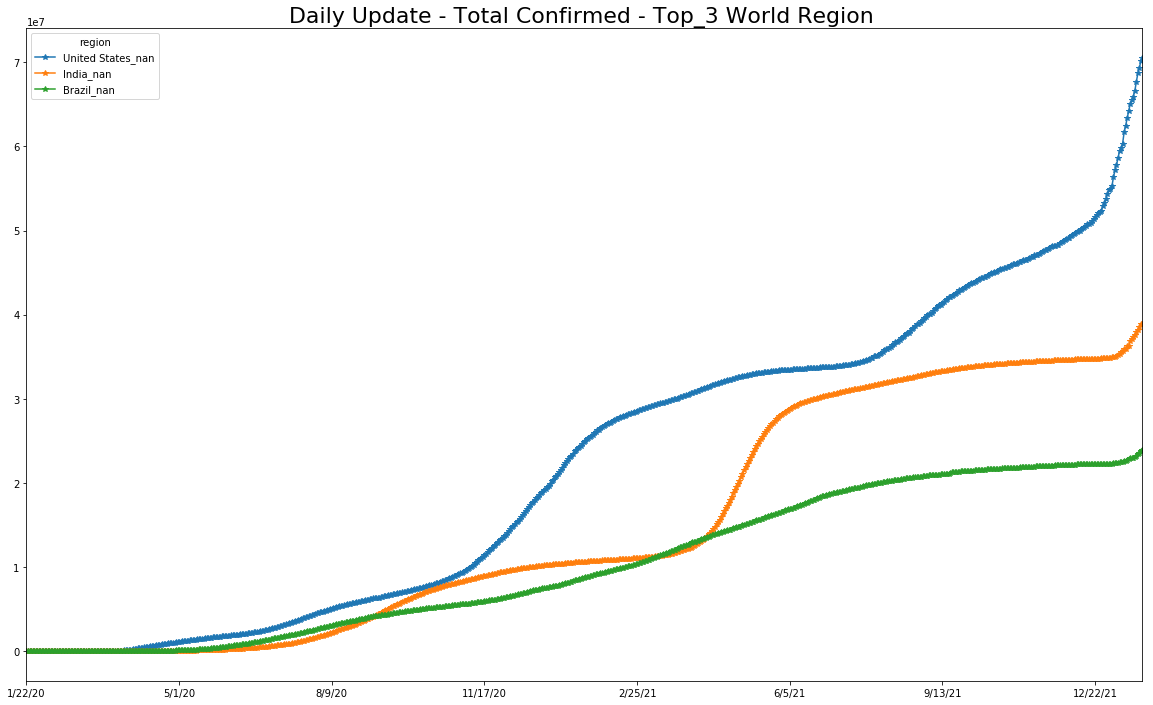

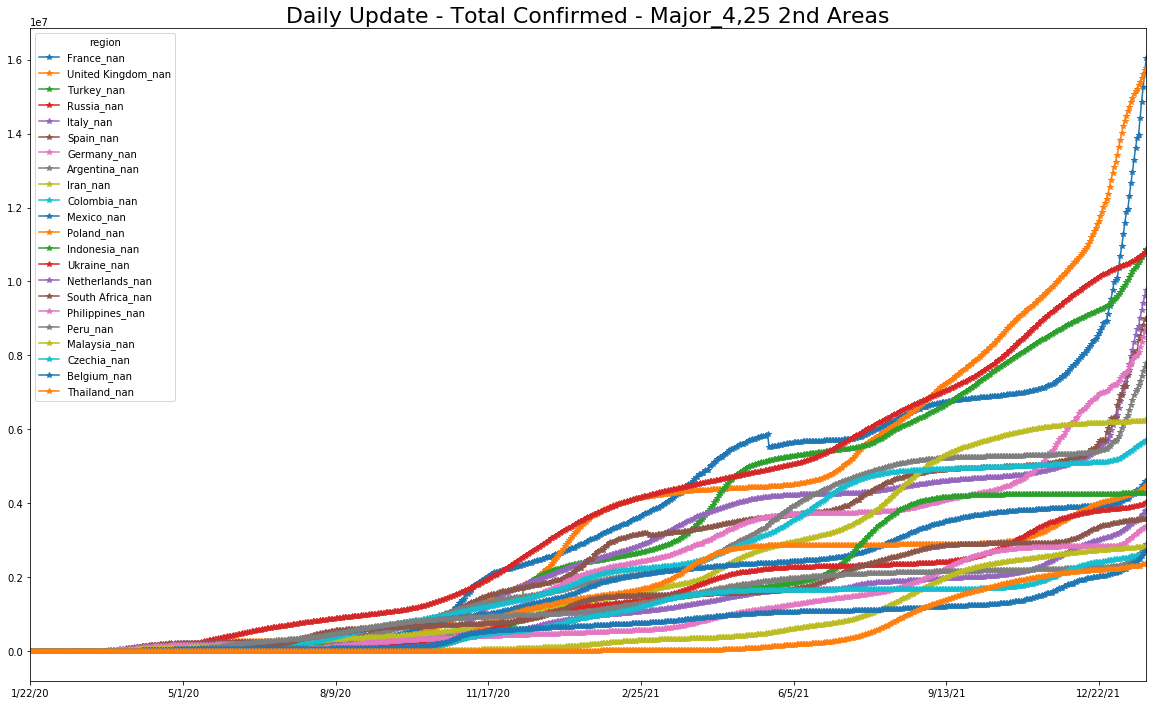

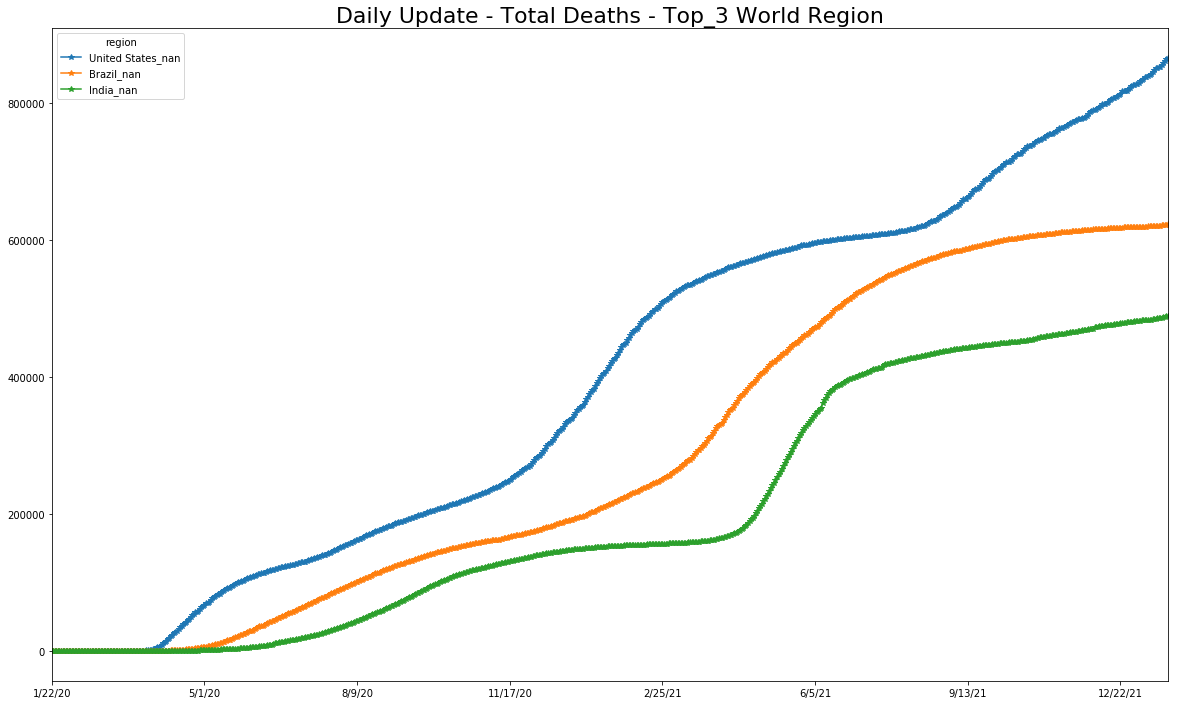

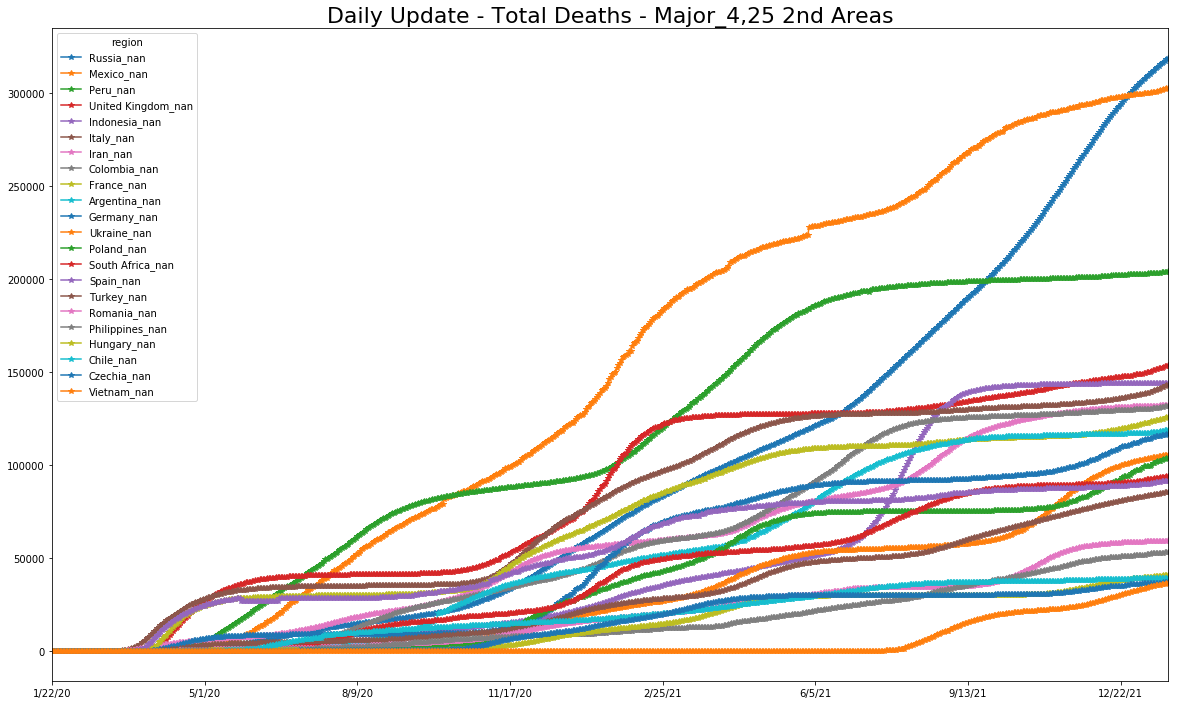

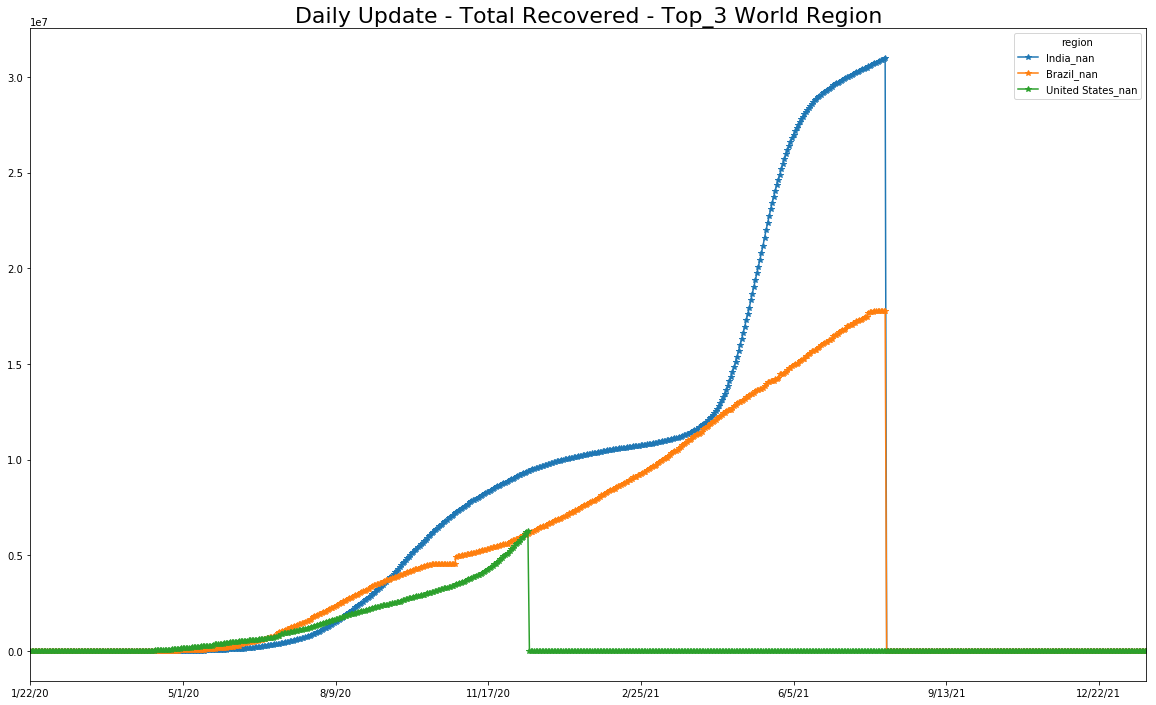

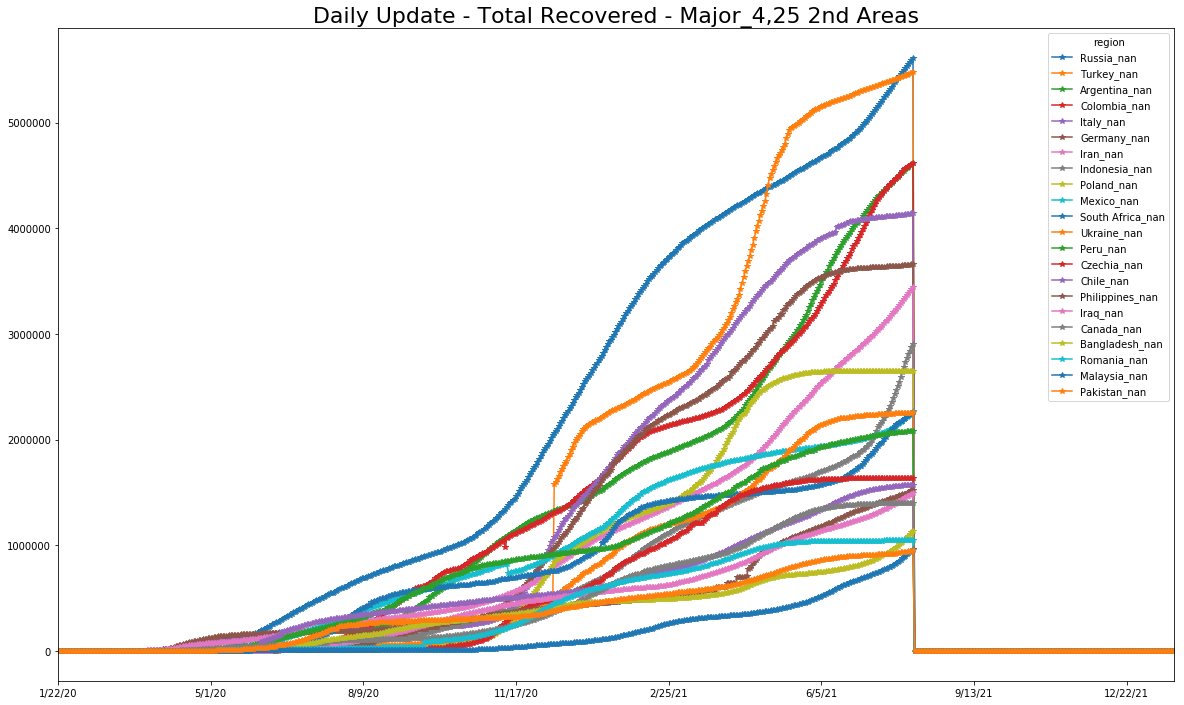

In [17]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [18]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [19]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [20]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2022/01/23


In [21]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [22]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [23]:
# Joao - FIX - Improve Performance 
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [24]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
6/25/21           111592       132506       137772        13882       38371   
6/26/21           113124       132509       138113        13882       38528   
6/27/21           114220       132512       138465        13882       38556   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
6/25/21                     1263        4374587       224635   
6/26/21                     1263        4393142       224728   
6/27/21                     1263        4405247       224797   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
6/25/21                                     124                       5725   
6/26/21                                     124                       5756   
6/27/21                                     124                       5778   

region   ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
6/25/21  ...           33729952       363580          108184            4   
6/26/21  ...           33739268       364859          108730            4   
6/27/21  ...           33743792       365866          109223            4   

region   Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
6/25/21         266952        14537                  313520       6905   
6/26/21         268349        15325                  313520       6906   
6/27/21         269635        15740                  313721       6908   

region   Zambia_nan  Zimbabwe_nan  
6/25/21      143215         45217  
6/26/21      146031         46018  
6/27/21      148568         46442  

[3 rows x 280 columns]

In [25]:
ts[-4:]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
1/19/22           159070       239129       228918        29888       94779   
1/20/22           159303       241512       230470        32201       95220   
1/21/22           159516       244182       232325        33025       95676   
1/22/22           159548       246412       234536        33025       95902   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
1/19/22                     5741        7446626       348708   
1/20/22                     5741        7576335       349329   
1/21/22                     5815        7694506       349957   
1/22/22                     5931        7792652       350897   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
1/19/22                                   28510                     895004   
1/20/22                                   28472                     919876   
1/21/22                                   29240                     939615   
1/22/22                                   30634                     960099   

region   ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
1/19/22  ...           68684431       543166          208271            7   
1/20/22  ...           69329860       556163          209578            7   
1/21/22  ...           70209840       569037          210899            7   
1/22/22  ...           70494744       580066          212289            7   

region   Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
1/19/22         461059      2078087                  478084      10449   
1/20/22         463145      2094802                  479343      10507   
1/21/22         465463      2110737                  480583      10585   
1/22/22         467864      2126444                  480583      10585   

region   Zambia_nan  Zimbabwe_nan  
1/19/22      299172        226887  
1/20/22      299971        227552  
1/21/22      300587        227961  
1/22/22      301203        228179  

[4 rows x 280 columns]

In [26]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [27]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [28]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [29]:
p=%R pred_all

In [30]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [31]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [32]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [33]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [34]:
w_in_model.tail(2)

date       region   min   max
8379 2020-05-10  Vietnam_nan  26.9  33.0
8380 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [35]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [36]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [37]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2021-06-26  Afghanistan_nan     113124             0             0   
2     2021-06-27  Afghanistan_nan     114220          1532             0   
3     2021-06-28  Afghanistan_nan     115751          1096             0   
4     2021-06-29  Afghanistan_nan     117158          1531          4159   
5     2021-06-30  Afghanistan_nan     118659          1407          4034   
6     2021-07-01  Afghanistan_nan     120216          1501          4439   
7     2021-07-02  Afghanistan_nan     122156          1557          4465   
8     2021-07-03  Afghanistan_nan     123485          1940          4998   
9     2021-07-04  Afghanistan_nan     124748          1329          4826   
10    2021-07-05  Afghanistan_nan     125937          1263          4532   
11    2021-07-06  Afghanistan_nan     127464          1189          3781   
12    2021-07-07  Afghanistan_nan     129021          1527          3979   
13    2021-07-08  Afghanistan_nan     130113          1557          4273   
14    2021-07-09  Afghanistan_nan     131586          1092          4176   
15    2021-07-10  Afghanistan_nan     132777          1473          4122   
16    2021-07-11  Afghanistan_nan     133578          1191          3756   
17    2021-07-12  Afghanistan_nan     134653           801          3465   
18    2021-07-13  Afghanistan_nan     135889          1075          3067   
19    2021-07-14  Afghanistan_nan     136643          1236          3112   
20    2021-07-15  Afghanistan_nan     137853           754          3065   
21    2021-07-16  Afghanistan_nan     139051          1210          3200   
22    2021-07-17  Afghanistan_nan     140224          1198          3162   
23    2021-07-18  Afghanistan_nan     140602          1173          3581   
24    2021-07-19  Afghanistan_nan     141499           378          2749   
25    2021-07-20  Afghanistan_nan     142414           897          2448   
26    2021-07-21  Afghanistan_nan     142762           915          2190   
27    2021-07-22  Afghanistan_nan     143183           348          2160   
28    2021-07-23  Afghanistan_nan     143439           421          1684   
29    2021-07-24  Afghanistan_nan     143666           256          1025   
30    2021-07-25  Afghanistan_nan     143871           227           904   
...          ...              ...        ...           ...           ...   
60888 2021-12-25     Zimbabwe_nan     203746          1392          4968   
60889 2021-12-26     Zimbabwe_nan     204351          1010          4342   
60890 2021-12-27     Zimbabwe_nan     205449           605          3007   
60891 2021-12-28     Zimbabwe_nan     207548          1098          2713   
60892 2021-12-29     Zimbabwe_nan     207548          2099          3802   
60893 2021-12-30     Zimbabwe_nan     211728             0          3197   
60894 2021-12-31     Zimbabwe_nan     213258          4180          6279   
60895 2022-01-01     Zimbabwe_nan     214214          1530          5710   
60896 2022-01-02     Zimbabwe_nan     214214           956          6666   
60897 2022-01-03     Zimbabwe_nan     216087             0          2486   
60898 2022-01-04     Zimbabwe_nan     217678          1873          2829   
60899 2022-01-05     Zimbabwe_nan     219057          1591          3464   
60900 2022-01-06     Zimbabwe_nan     220178          1379          4843   
60901 2022-01-07     Zimbabwe_nan     221282          1121          4091   
60902 2022-01-08     Zimbabwe_nan     221918          1104          3604   
60903 2022-01-09     Zimbabwe_nan     221918           636          2861   
60904 2022-01-10     Zimbabwe_nan     223000             0          1740   
60905 2022-01-11     Zimbabwe_nan     223000          1082          1718   
60906 2022-01-12     Zimbabwe_nan     224433             0          1082   
60907 2022-01-13     Zimbabwe_nan     225084          1433          2515   
60908 2022-01-14     Zimbabwe_nan     225637           651  

In [38]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [39]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
60917 2022-01-23  Zimbabwe_nan          0           218          1292   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
60917          2542         100.095635         100.569451         101.126593   

       last_day  kalman_prediction  population  infected_rate  min  max  
60917    228179           228562.0    14862924       0.000154  NaN  NaN

In [40]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
60917 2022-01-23  Zimbabwe_nan          0           218          1292   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
60917          2542         100.095635         100.569451         101.126593   

       last_day  kalman_prediction  population  infected_rate  min  max  
60917    228179           228562.0    14862924       0.000154  NaN  NaN

In [41]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
### Assumption : Each affected person can contact up to 9 others that not report or are assimptomatic COVID19 cases.
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=np.clip(ratiod['infected_rate']*900,0.0,1.0)
#
ratiod['delta : pred new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : pred new_cases per 1M hab']=ratiod['delta : pred new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
59637  2022-01-21  Zimbabwe_nan     227961           665          1092   
59638  2022-01-22  Zimbabwe_nan     228179           409          1501   
59639  2022-01-23  Zimbabwe_nan          0           218          1292   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
59637          2468         100.293102         100.482209         101.096484   
59638          2324         100.179744         100.662815         101.029977   
59639          2542         100.095635         100.569451         101.126593   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
59637               227552  ...    14862924       0.000153  NaN  NaN   
59638               227961  ...    14862924       0.000153  NaN  NaN   
59639               228179  ...    14862924       0.000154  NaN  NaN   

       population_percentage : infected_rate confirmed  \
59637                                         0.015310   
59638                                         0.015338   
59639                                         0.015352   

       population_percentage : factor 9/10 infected_rate confirmed  \
59637                                           0.137791             
59638                                           0.138039             
59639                                           0.138171             

       delta : pred new_cases  delta : pred new_cases per 1M hab  \
59637                   215.0                          14.465525   
59638                   263.0                          17.695038   
59639                   383.0                          25.768819   

       delta : roling 7day AVG  \
59637               352.571429   
59638               332.000000   
59639               363.142857   

       delta : aprox 14-day case notification rate per 100k hab  
59637                                          33.210154         
59638                                          31.272447         
59639                                          34.205921         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse            mae
270  United States_nan  2.425328e+13  4.924762e+06  452233.636792


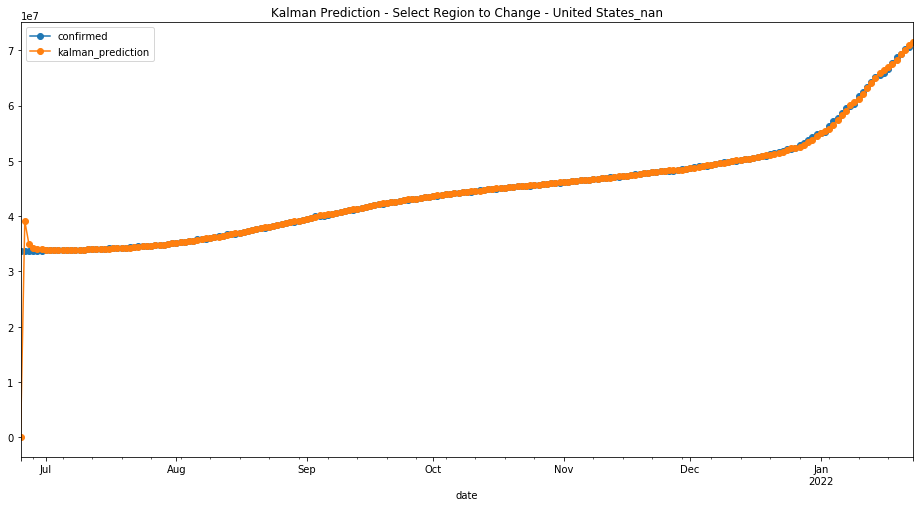

In [42]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse           rmse           mae
217  Russia_nan  5.621401e+11  749760.013574  59624.528302


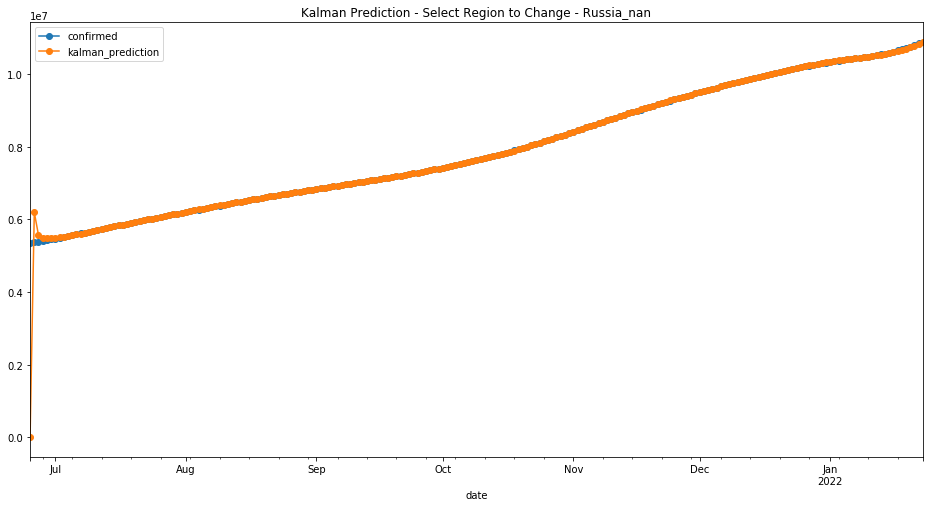

In [43]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse          rmse            mae
30  Brazil_nan  2.767462e+12  1.663569e+06  147405.575472


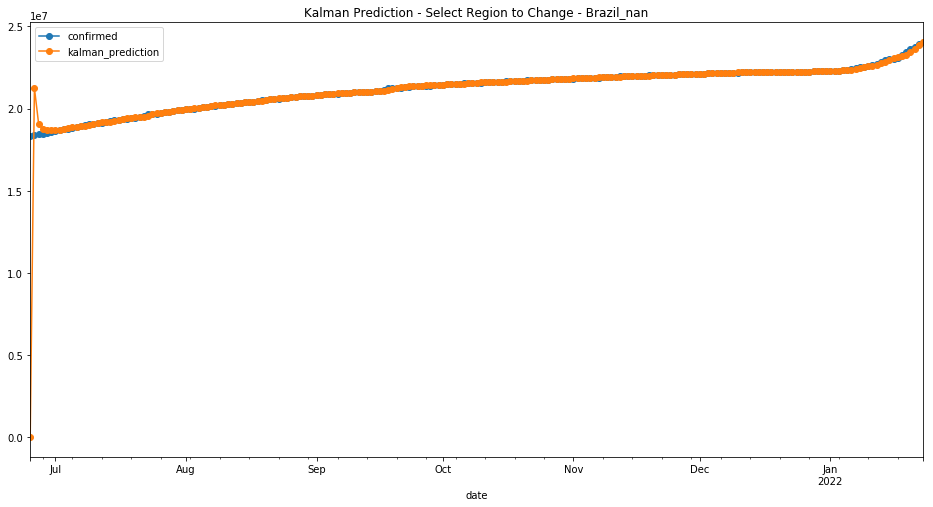

In [44]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse          rmse           mae
269  United Kingdom_nan  1.192925e+12  1.092211e+06  92397.254717


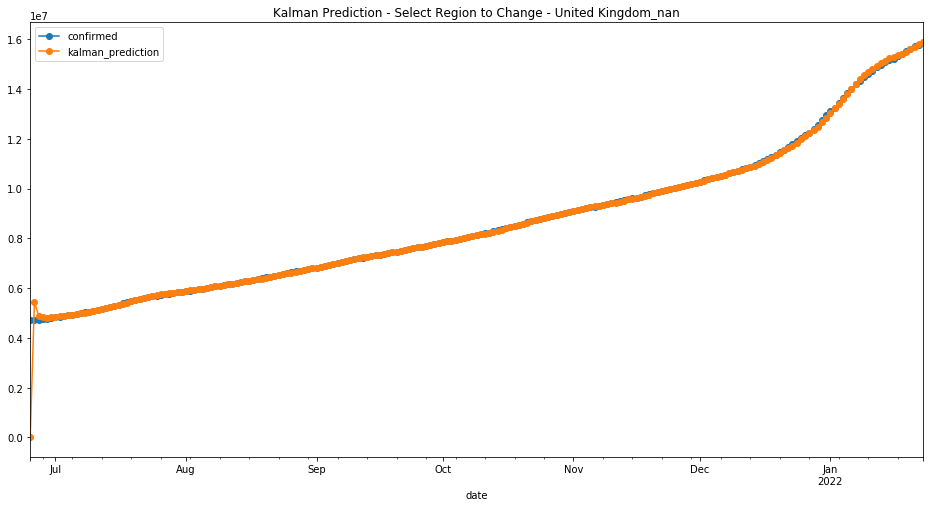

In [45]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [46]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment (build 11.0.13+8-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.13+8-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp01ih99xf
  JVM stdout: /tmp/tmp01ih99xf/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp01ih99xf/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ----------------------------------------
H2O cluster uptime:         01 secs
H2O cluster timezone:       Etc/GMT
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.0.1
H2O cluster version age:    3 years, 2 months and 27 days !!!
H2O cluster name:           H2O_from_python_unknownUser_rfydr9
H2O cluster total nodes:    1
H2O cluster free memory:    3.541 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.7 final
--------------------------  ----------------------------------------

In [47]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2022-01-11
last_train_date= 2022-01-22
first_bootstrap_date= 2022-01-14
boost_bootstrap_date= 2022-01-19
first_test_date= 2022-01-13
last_test_date= 2022-01-23
first_valid_date= 2022-01-21


In [48]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [49]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [50]:
pred2.iloc[:25]

0  confirmed       date           region
0   160365.0     158639 2022-01-14  Afghanistan_nan
1   160435.0     158678 2022-01-15  Afghanistan_nan
2   160485.0     158717 2022-01-16  Afghanistan_nan
3   160527.0     158826 2022-01-17  Afghanistan_nan
4   160599.0     158974 2022-01-18  Afghanistan_nan
5   160724.0     159070 2022-01-19  Afghanistan_nan
6   160856.0     159303 2022-01-20  Afghanistan_nan
7   161038.0     159516 2022-01-21  Afghanistan_nan
8   161276.0     159548 2022-01-22  Afghanistan_nan
9   161436.0          0 2022-01-23  Afghanistan_nan
10  229077.0     228777 2022-01-14      Albania_nan
11  231356.0     230940 2022-01-15      Albania_nan
12  233617.0     232637 2022-01-16      Albania_nan
13  235541.0     233654 2022-01-17      Albania_nan
14  236821.0     236486 2022-01-18      Albania_nan
15  239065.0     239129 2022-01-19      Albania_nan
16  241550.0     241512 2022-01-20      Albania_nan
17  244049.0     244182 2022-01-21      Albania_nan
18  246784.0     246412 2022-01-22      Albania_nan
19  249269.0          0 2022-01-23      Albania_nan
20  226464.0     224979 2022-01-14      Algeria_nan
21  227092.0     225484 2022-01-15      Algeria_nan
22  227660.0     226057 2022-01-16      Algeria_nan
23  228242.0     226749 2022-01-17      Algeria_nan
24  228904.0     227559 2022-01-18      Algeria_nan

In [51]:
pred2.iloc[175:195]

0  confirmed       date          region
175  628780.0     628166 2022-01-19  Azerbaijan_nan
176  629892.0     629352 2022-01-20  Azerbaijan_nan
177  631090.0     630420 2022-01-21  Azerbaijan_nan
178  632245.0     632034 2022-01-22  Azerbaijan_nan
179  633980.0          0 2022-01-23  Azerbaijan_nan
180   31520.0      29908 2022-01-14     Bahamas_nan
181   32039.0      30655 2022-01-15     Bahamas_nan
182   30021.0      30850 2022-01-16     Bahamas_nan
183   32015.0      30850 2022-01-17     Bahamas_nan
184   32689.0      31105 2022-01-18     Bahamas_nan
185   31902.0      31549 2022-01-19     Bahamas_nan
186   31634.0      31693 2022-01-20     Bahamas_nan
187   32828.0      31915 2022-01-21     Bahamas_nan
188   32804.0      31999 2022-01-22     Bahamas_nan
189   33257.0          0 2022-01-23     Bahamas_nan
190  301922.0     302872 2022-01-14     Bahrain_nan
191  304297.0     305414 2022-01-15     Bahrain_nan
192  306910.0     308008 2022-01-16     Bahrain_nan
193  309606.0     310906 2022-01-17     Bahrain_nan
194  312585.0     313925 2022-01-18     Bahrain_nan

In [52]:
pred2.iloc[220:240]

0  confirmed       date       region
220   713606.0     713002 2022-01-14  Belarus_nan
221   714839.0     714295 2022-01-15  Belarus_nan
222   716136.0     715643 2022-01-16  Belarus_nan
223   717542.0     717034 2022-01-17  Belarus_nan
224   719018.0     718098 2022-01-18  Belarus_nan
225   720168.0     719485 2022-01-19  Belarus_nan
226   721665.0     721103 2022-01-20  Belarus_nan
227   723311.0     722939 2022-01-21  Belarus_nan
228   725177.0     724903 2022-01-22  Belarus_nan
229   727208.0          0 2022-01-23  Belarus_nan
230  2368498.0    2410731 2022-01-14  Belgium_nan
231  2445378.0    2410731 2022-01-15  Belgium_nan
232  2433465.0    2410731 2022-01-16  Belgium_nan
233  2439238.0    2484027 2022-01-17  Belgium_nan
234  2522259.0    2521462 2022-01-18  Belgium_nan
235  2546933.0    2575313 2022-01-19  Belgium_nan
236  2608050.0    2642761 2022-01-20  Belgium_nan
237  2681638.0    2697239 2022-01-21  Belgium_nan
238  2740245.0    2697239 2022-01-22  Belgium_nan
239  2740773.0          0 2022-01-23  Belgium_nan

In [53]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [54]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  114529266150.3218
# MSE on the validation data =  70907965510083.4
# R^2 on the training data =  0.9987555657480196
# R^2 on the validation data =  0.43331525443540053


In [55]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1642922762080_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 114529266150.3218
RMSE: 338421.72824793885
MAE: 22545.65303594214
RMSLE: 0.5433943583428803
Mean Residual Deviance: 114529266150.3218

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 70907965510083.4
RMSE: 8420686.760002619
MAE: 2377478.487496773
RMSLE: 8.266960979679828
Mean Residual Deviance: 70907965510083.4
Scoring History: 


timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse    validation_mae      validation_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------  -----------------  ------------------  ---------------------
     2022-01-23 07:26:09  0.073 sec   0.0                nan                 nan                 nan                  nan                nan                 nan
     2022-01-23 07:26:10  0.464 sec   1.0                410269.2883103266   60074.93410810159   168320888930.66187   8309459.106681504  2391535.3004469313  69047110645612.18
     2022-01-23 07:26:10  0.624 sec   2.0                291945.9625877868   43454.08310364911   85232445071.30939    8402503.97573193   2375210.6117819366  70602073062190.89
     2022-01-23 07:26:10  0.849 sec   3.0                418188.88845168706  45100.47273630003   174881946424.45758   8388848.230391532  2375408.126463859   70372774632543.16
     2022-01-23 07:26:10  0.946 sec   4.0                403991.7237799816   45841.844401026465  163209312882.72098   8407311.88894046   2372379.785261635   70682893197919.6
---  ---                  ---         ---                ---                 ---                 ---                  ---                ---                 ---
     2022-01-23 07:26:17  8.047 sec   120.0              294187.87531585275  23674.399565095857  86546505982.85574    8390621.78935993   2378119.623592663   70402534012081.64
     2022-01-23 07:26:21  12.080 sec  220.0              295519.17002742336  22457.054054448785  87331579853.69714    8418331.457532099  2377479.0958808577  70868304528874.52
     2022-01-23 07:26:25  16.100 sec  318.0              313347.2186517605   22409.39365562274   98186479436.79419    8433216.296147773  2379184.3297603843  71119137097612.36
     2022-01-23 07:26:29  20.109 sec  413.0              330246.8390444746   22366.370024415195  109062974698.86711   8414195.801354157  2374505.484495406   70798690983525.9
     2022-01-23 07:26:33  23.884 sec  500.0              338421.72824793885  22545.65303594214   114529266150.3218    8420686.760002619  2377478.487496773   70907965510083.4


See the whole table with table.as_data_frame()
Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
region             1.1591e+20             1                    0.343188
kalman_prediction  1.00507e+20            0.867106             0.29758
last_day           7.24375e+19            0.624944             0.214473
7_day_change       2.06391e+19            0.178061             0.0611082
3_day_change       1.29049e+19            0.111335             0.038209
infected_rate      6.53311e+18            0.0563635            0.0193432
1_day_change       6.16559e+18            0.0531927            0.0182551
7_day_change_rate  1.71816e+18            0.0148232            0.00508713
3_day_change_rate  6.60804e+17            0.00570099           0.00195651
1_day_change_rate  2.70187e+17            0.002331             0.00079997

In [56]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0             region         1.159104e+20           1.000000    0.343188
1  kalman_prediction         1.005066e+20           0.867106    0.297580
2           last_day         7.243749e+19           0.624944    0.214473
3       7_day_change         2.063908e+19           0.178061    0.061108
4       3_day_change         1.290494e+19           0.111335    0.038209
5      infected_rate         6.533112e+18           0.056363    0.019343
6       1_day_change         6.165593e+18           0.053193    0.018255
7  7_day_change_rate         1.718161e+18           0.014823    0.005087
8  3_day_change_rate         6.608038e+17           0.005701    0.001957
9  1_day_change_rate         2.701869e+17           0.002331    0.000800

In [57]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


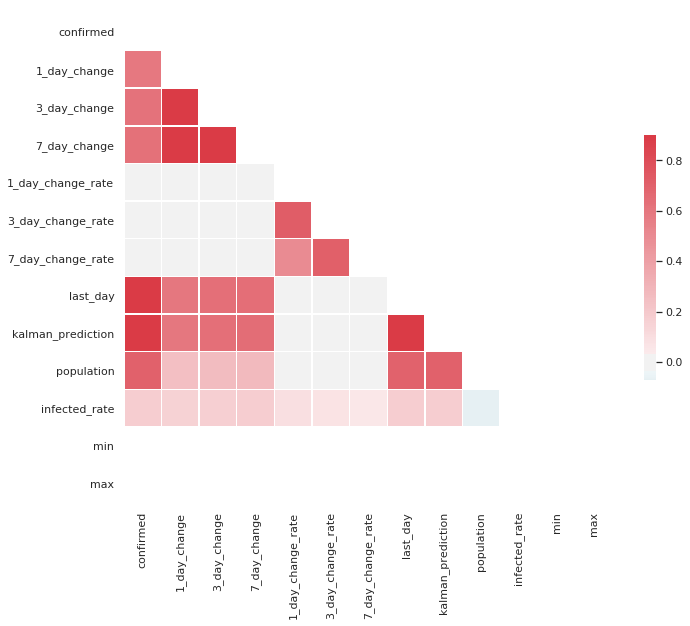

In [58]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [59]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.595598
3_day_change         0.619736
7_day_change         0.629965
1_day_change_rate    0.014042
3_day_change_rate    0.007023
7_day_change_rate   -0.000710
last_day             0.991850
kalman_prediction    0.993312
population           0.704352
infected_rate        0.177134
min                       NaN
max                       NaN
Name: confirmed, dtype: float64


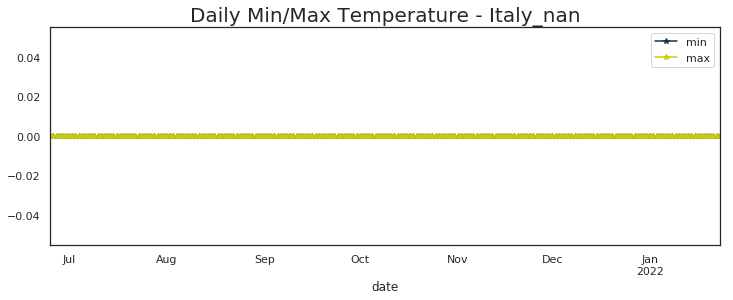

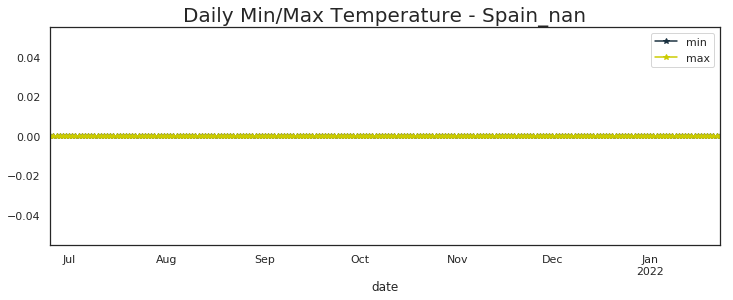

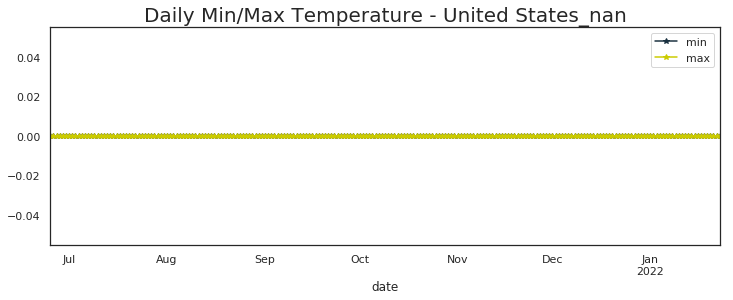

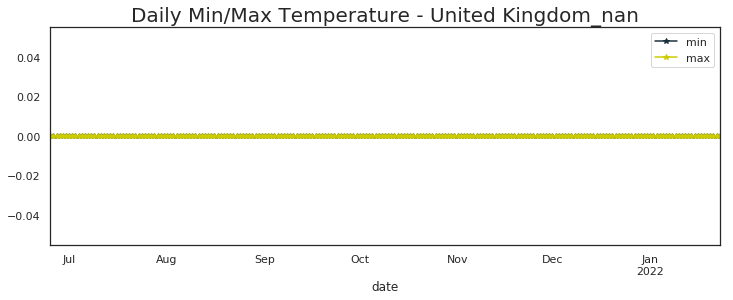

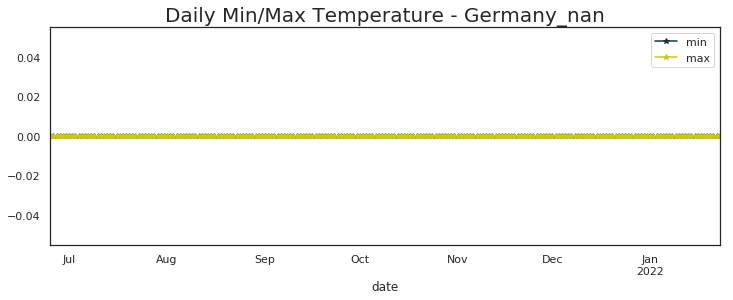

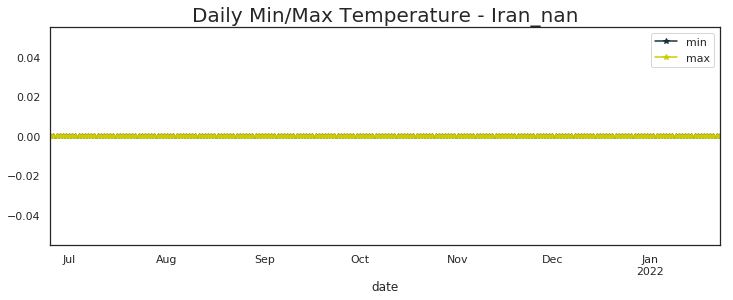

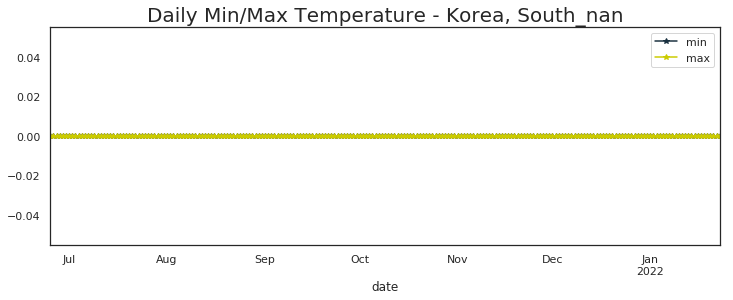

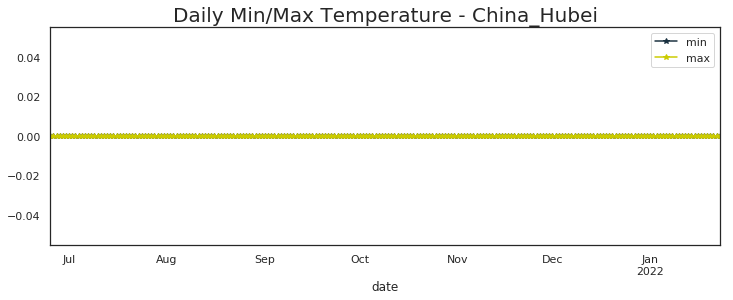

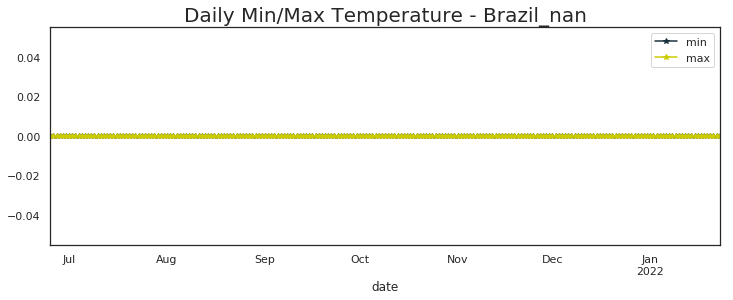

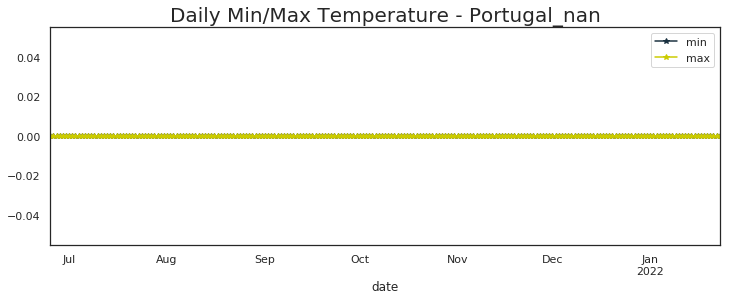

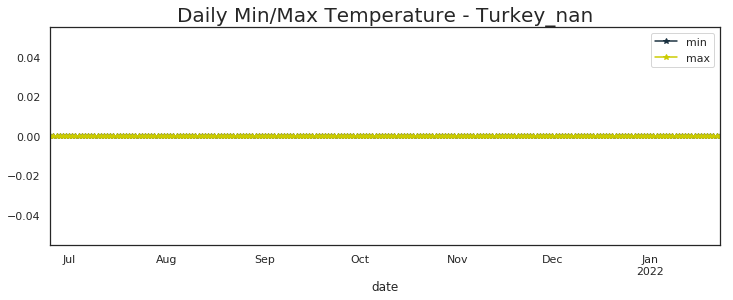

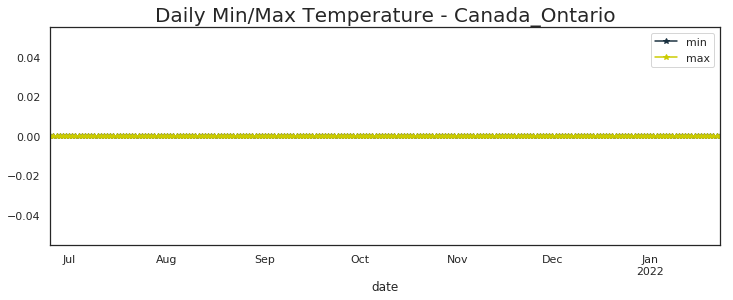

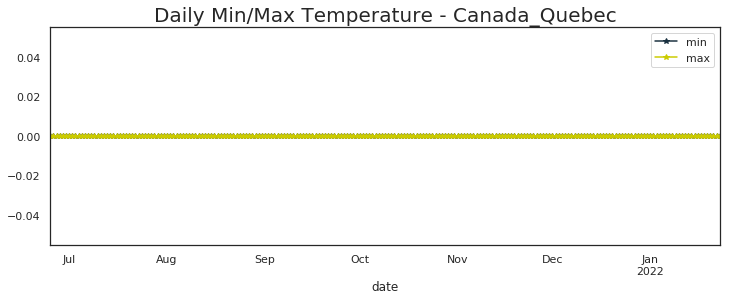

In [60]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [61]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                            min  max
region                              
United States_nan           0.0  0.0
India_nan                   0.0  0.0
Brazil_nan                  0.0  0.0
France_nan                  0.0  0.0
United Kingdom_nan          0.0  0.0
Turkey_nan                  0.0  0.0
Russia_nan                  0.0  0.0
Italy_nan                   0.0  0.0
Spain_nan                   0.0  0.0
Germany_nan                 0.0  0.0
Argentina_nan               0.0  0.0
Iran_nan                    0.0  0.0
Colombia_nan                0.0  0.0
Mexico_nan                  0.0  0.0
Poland_nan                  0.0  0.0
Indonesia_nan               0.0  0.0
Ukraine_nan                 0.0  0.0
Netherlands_nan             0.0  0.0
South Africa_nan            0.0  0.0
Philippines_nan             0.0  0.0
Peru_nan                    0.0  0.0
Malaysia_nan                0.0  0.0
Czechia_nan                 0.0  0.0
Belgium_nan                 0.0  0.0
Th

### Kalman X Days Ahead Prediction

In [62]:
%%R

#install.packages('reshape')

NULL


In [63]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [64]:
all_new=%R all_new

In [65]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

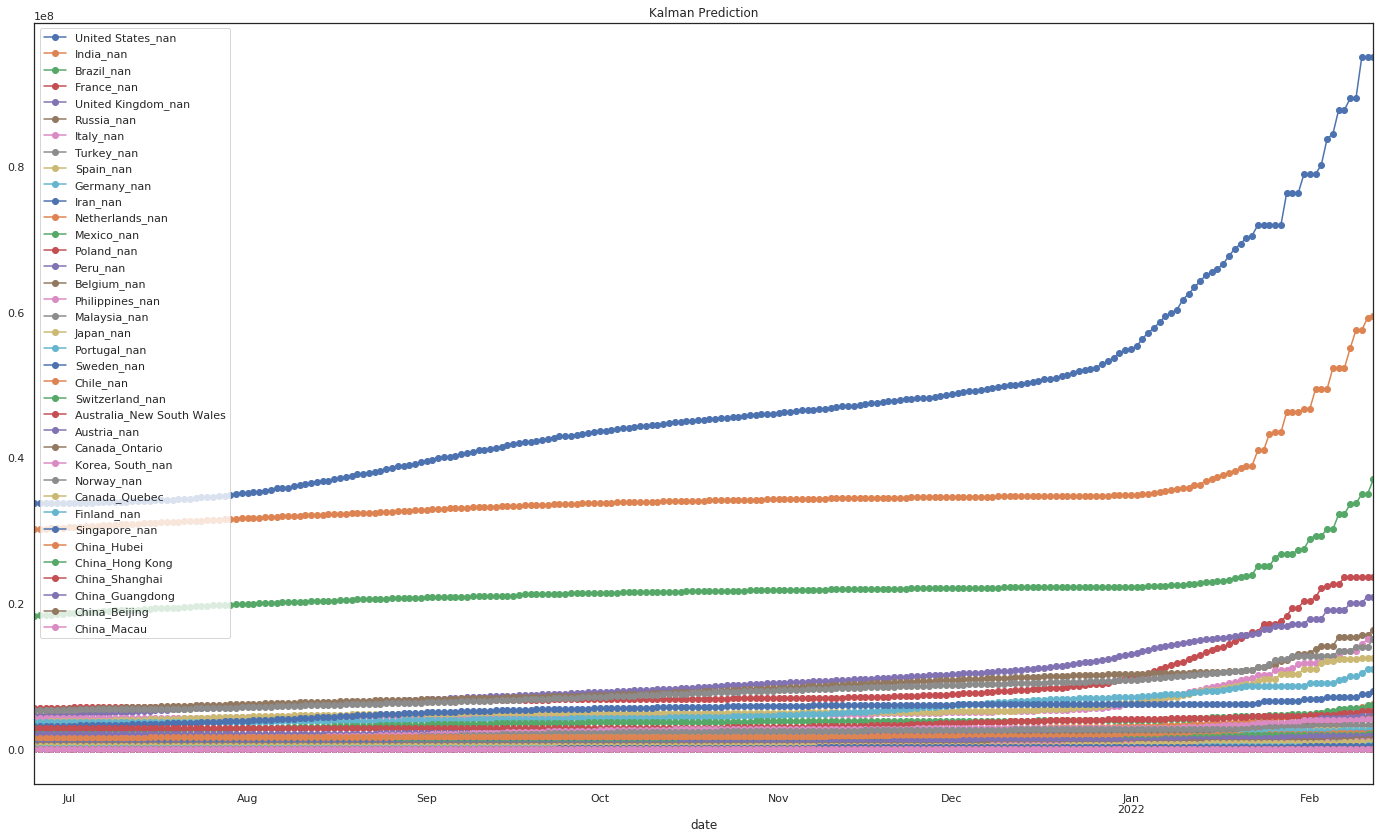

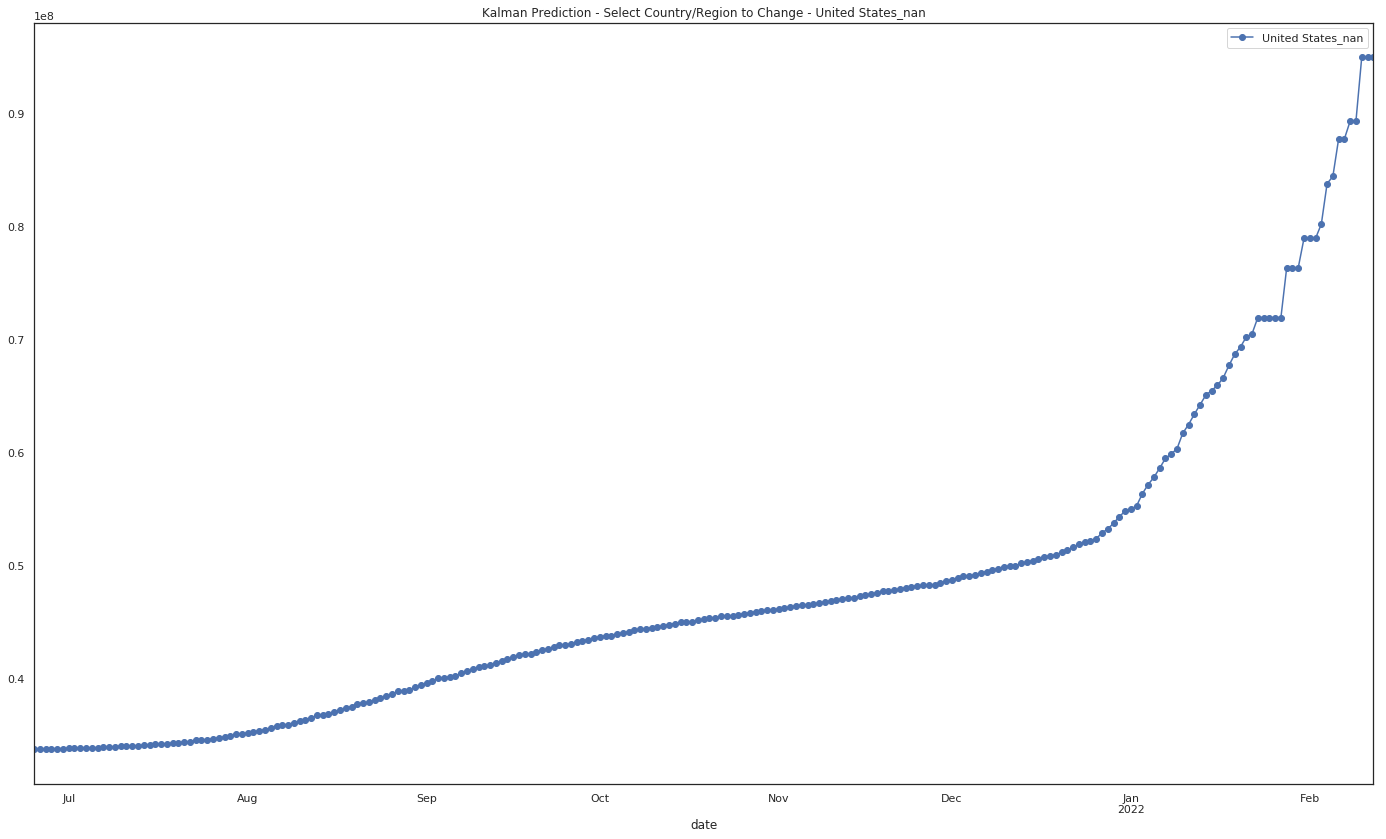

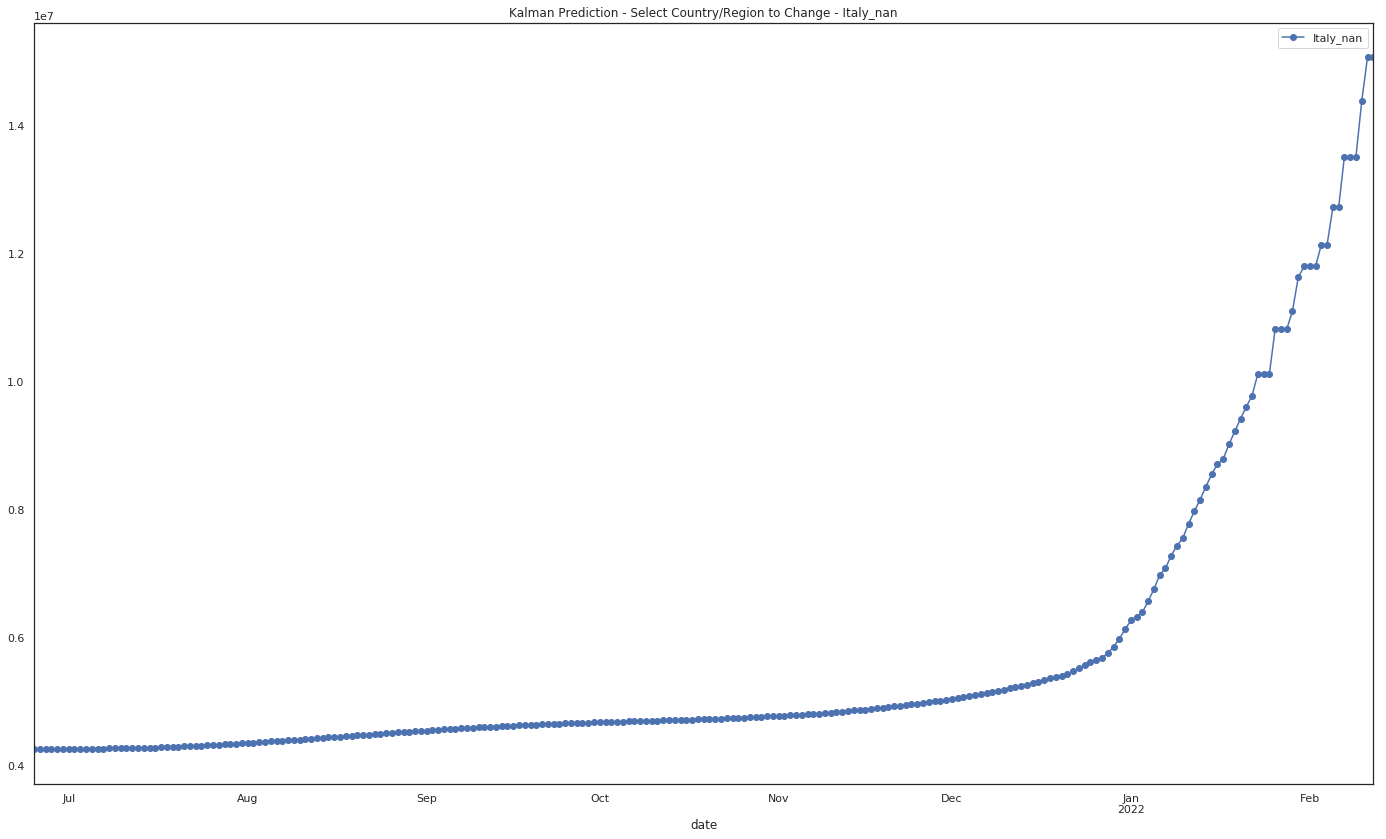

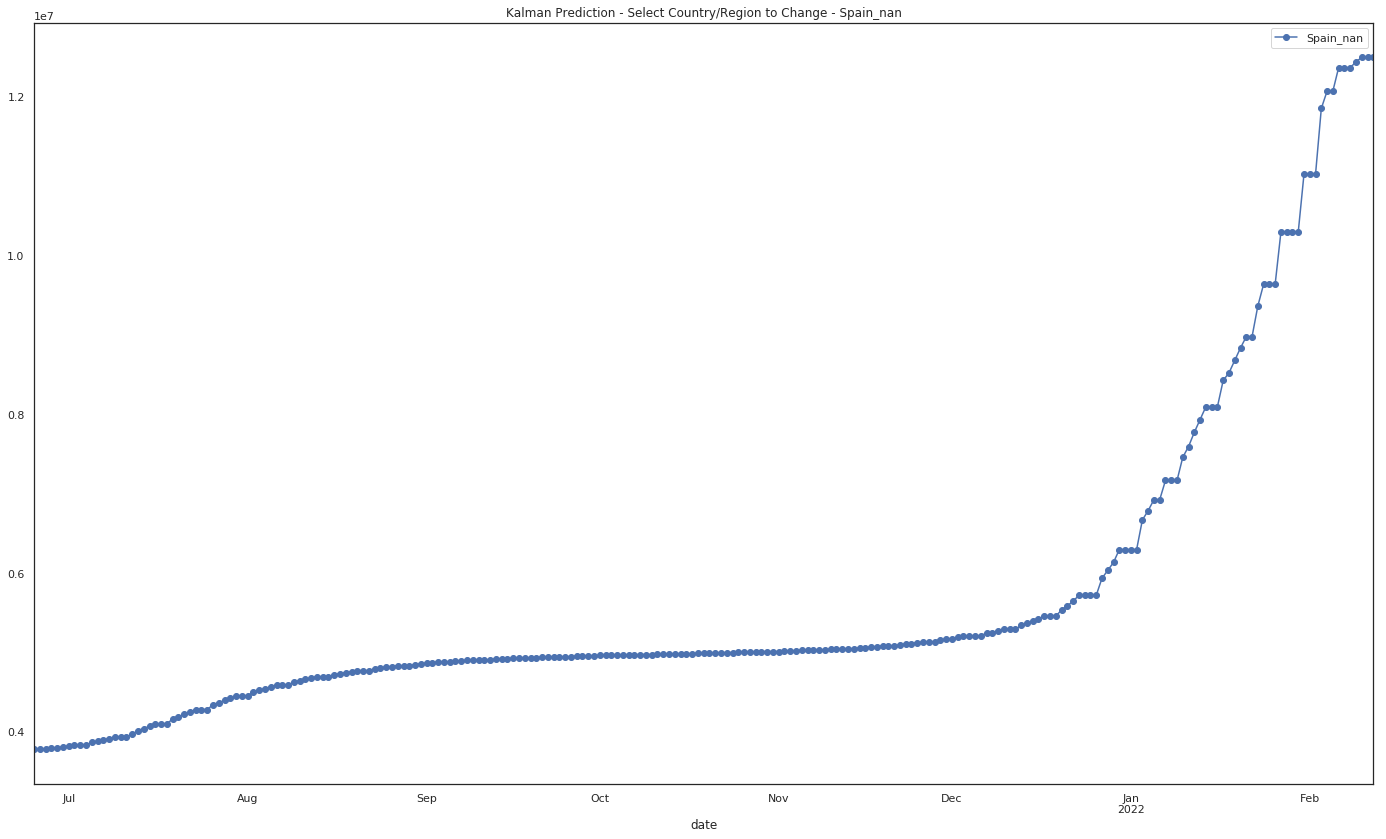

In [66]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


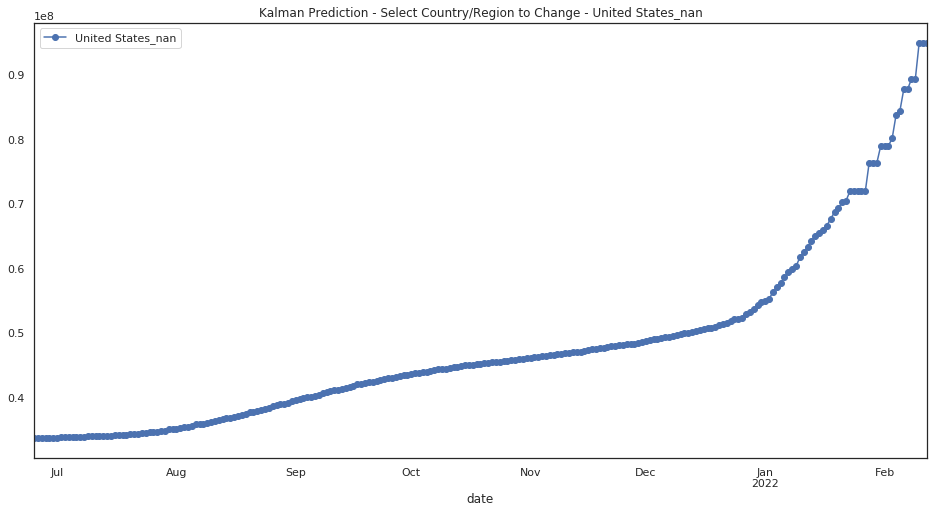

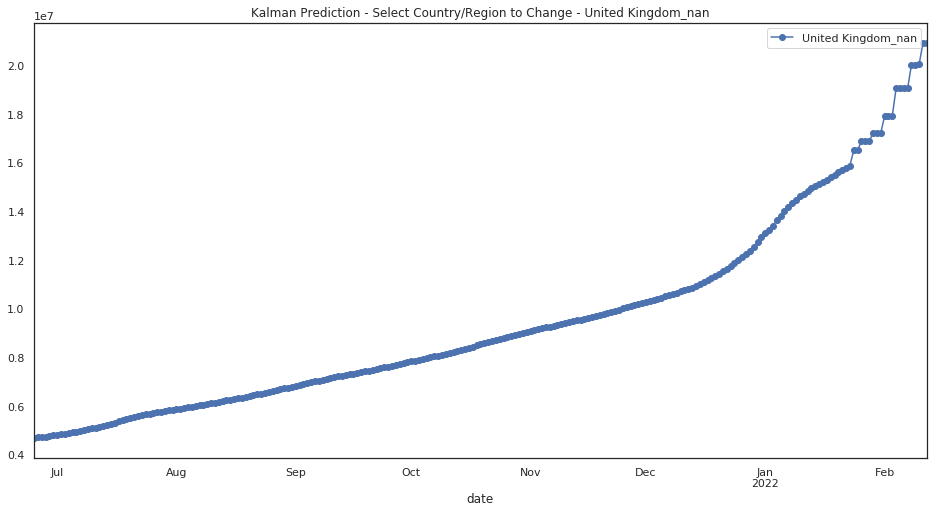

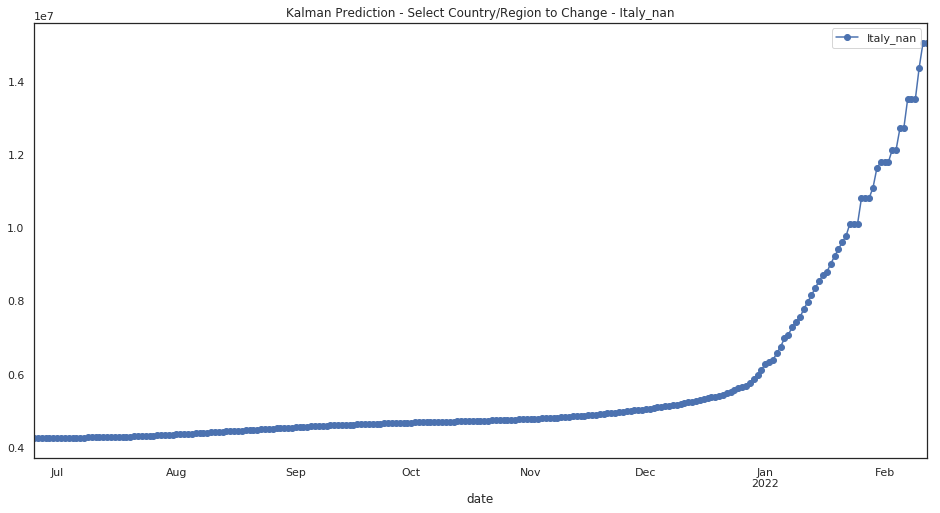

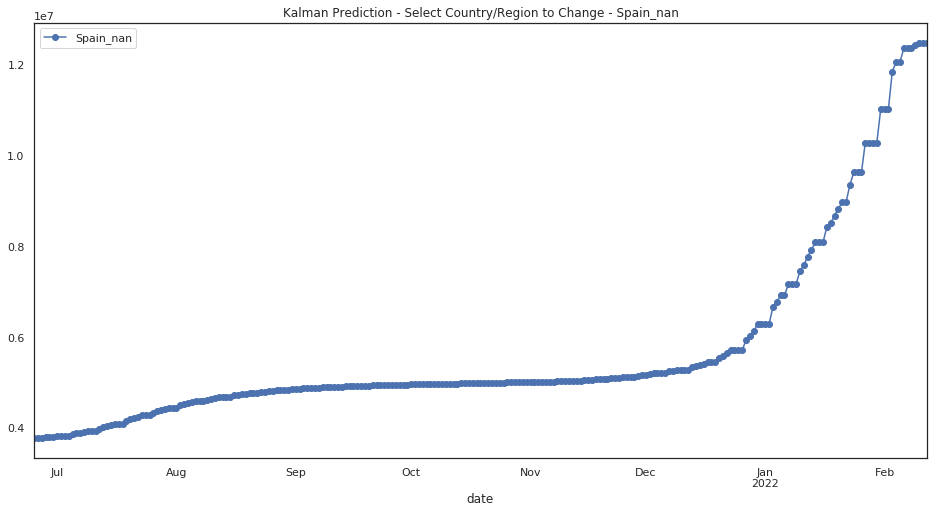

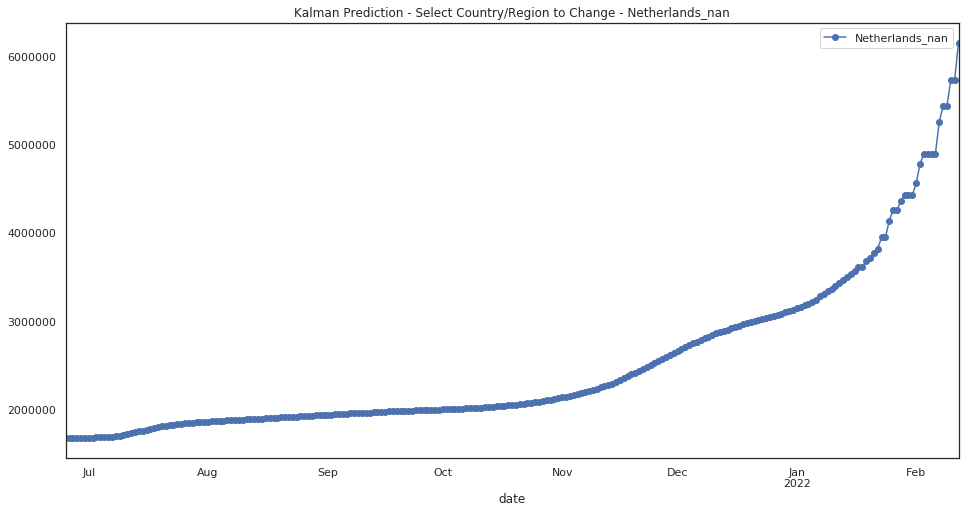

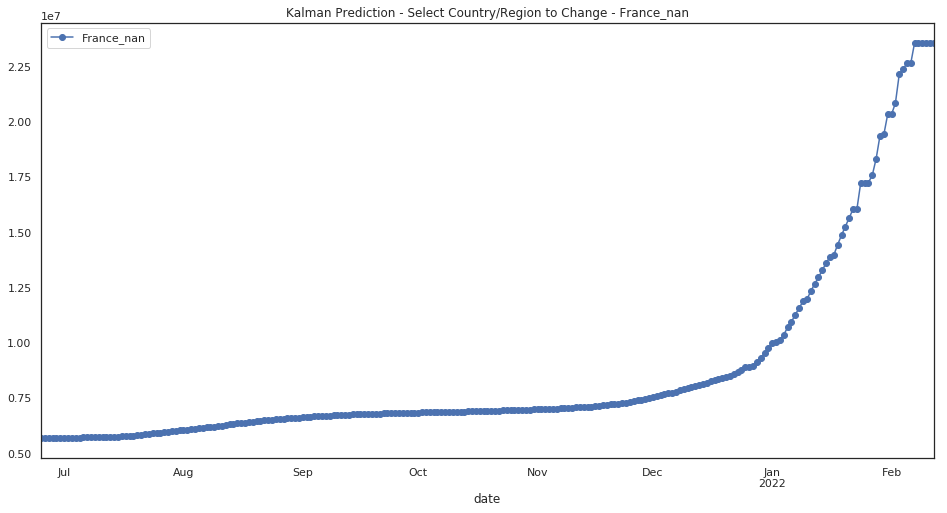

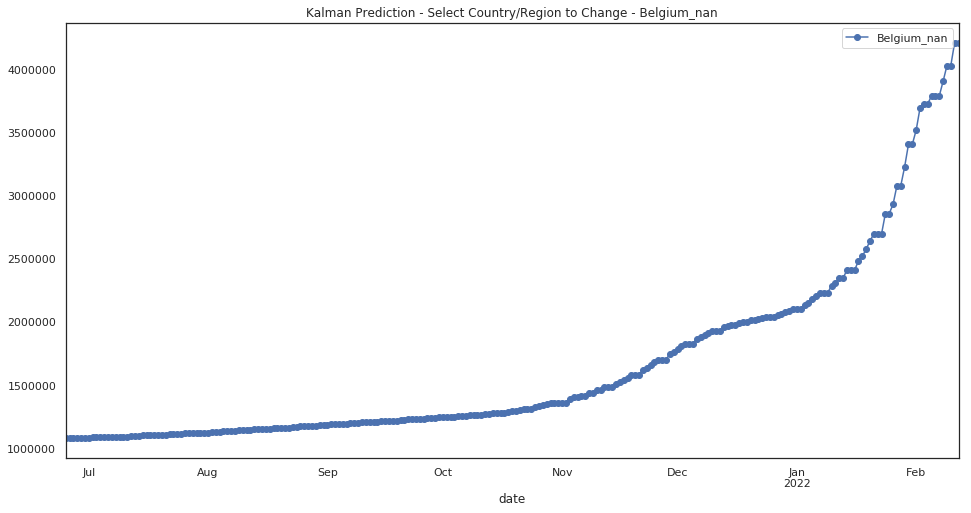

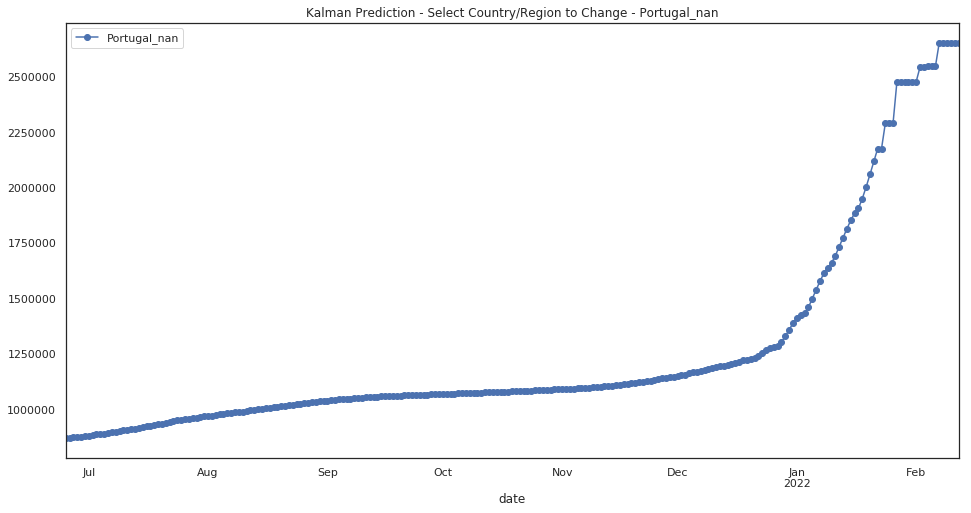

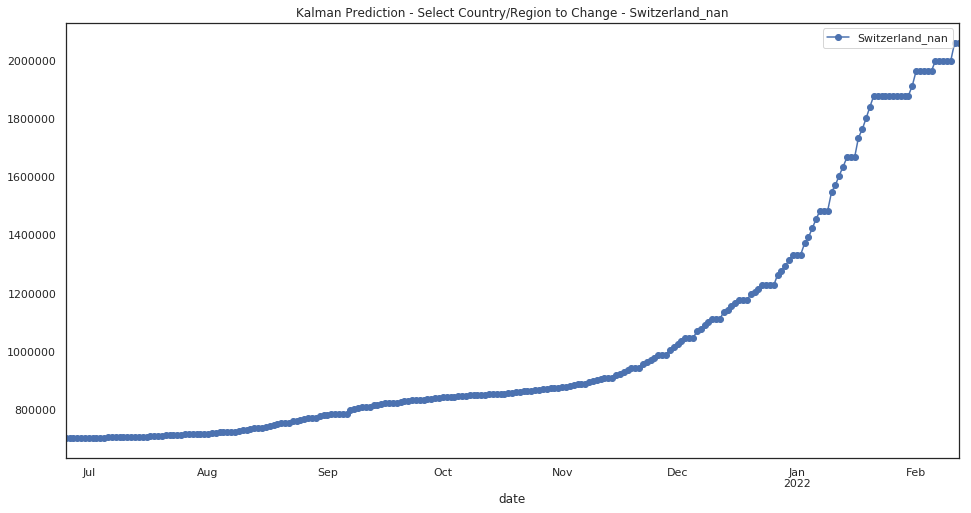

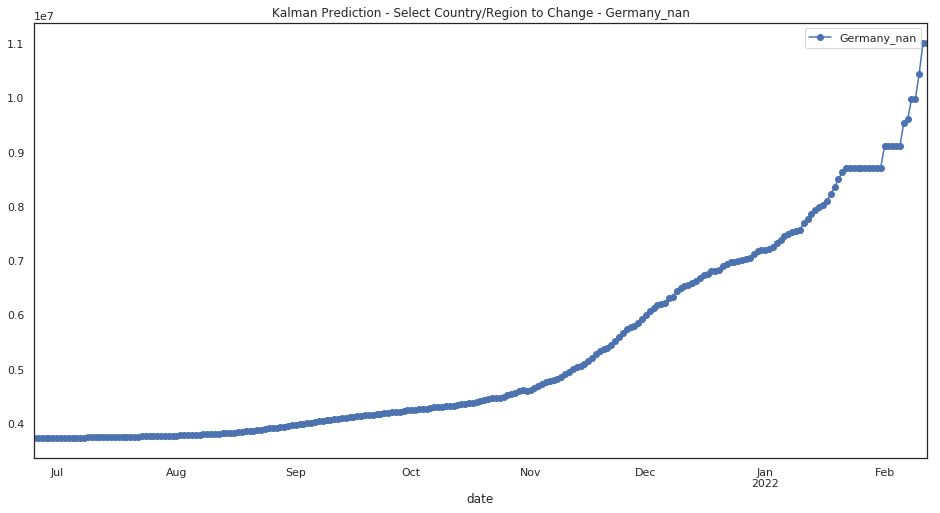

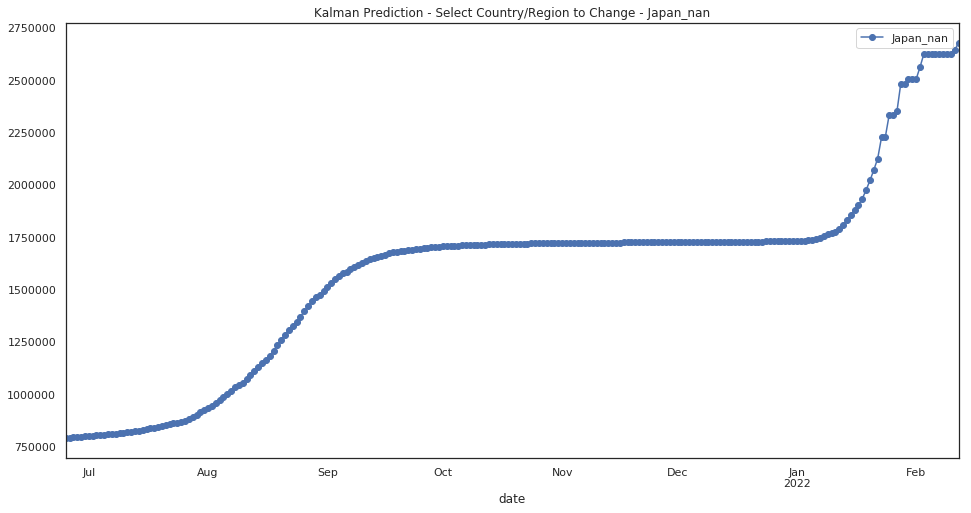

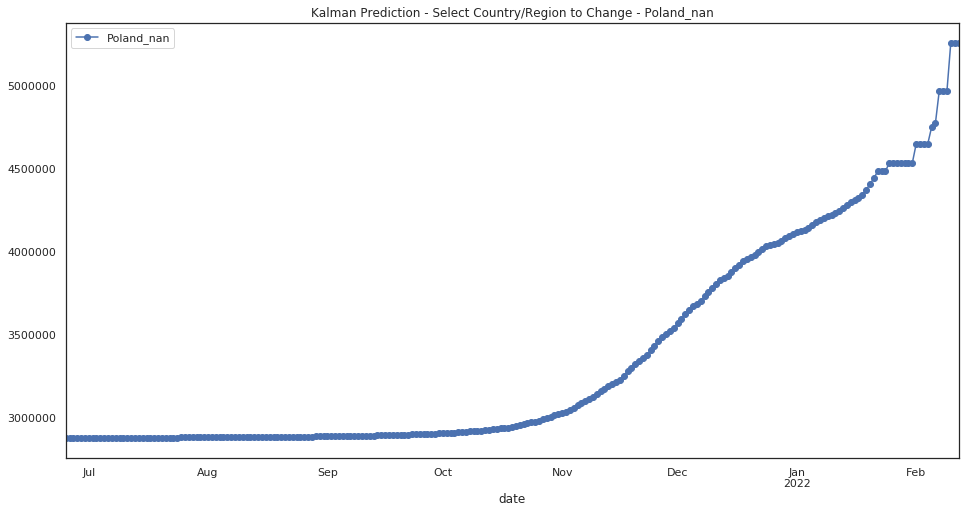

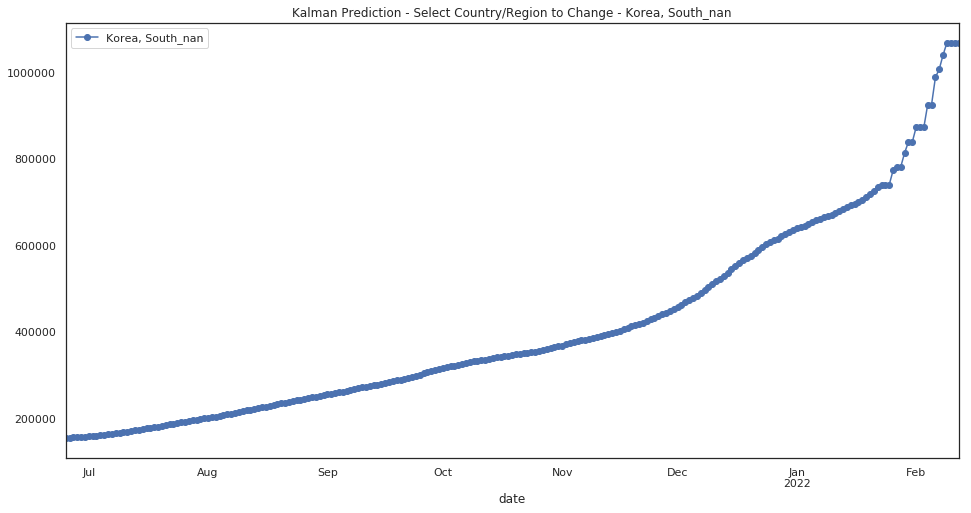

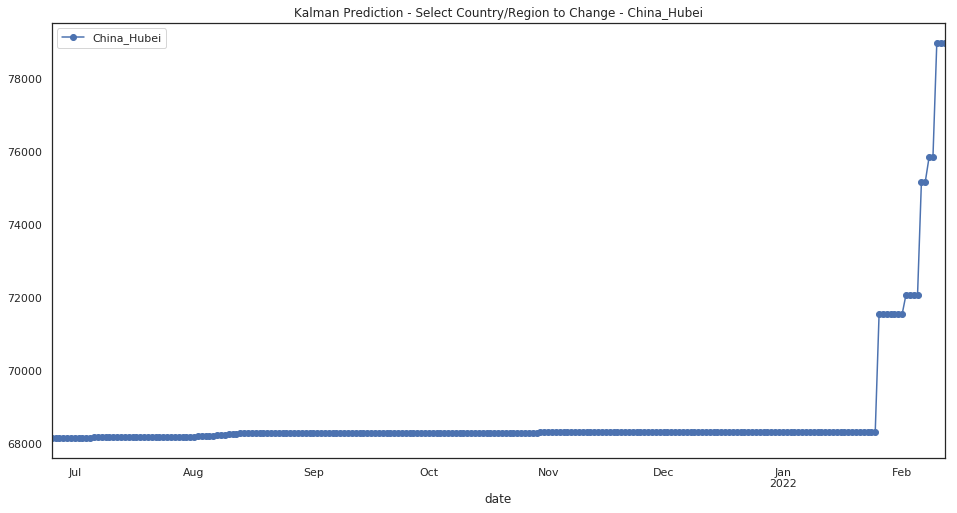

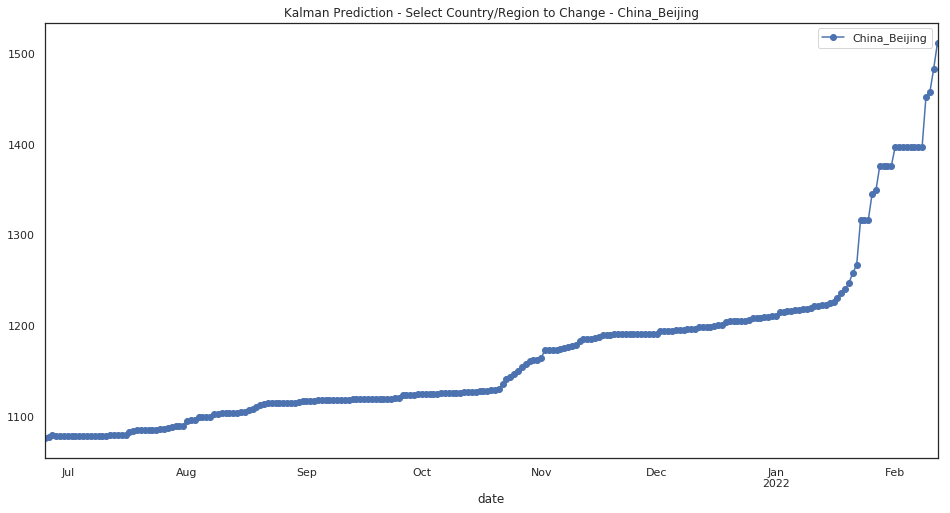

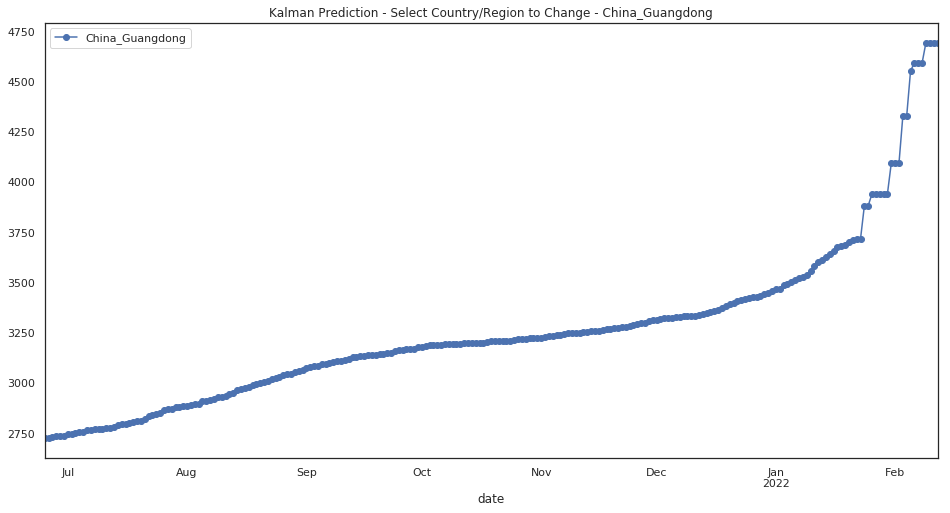

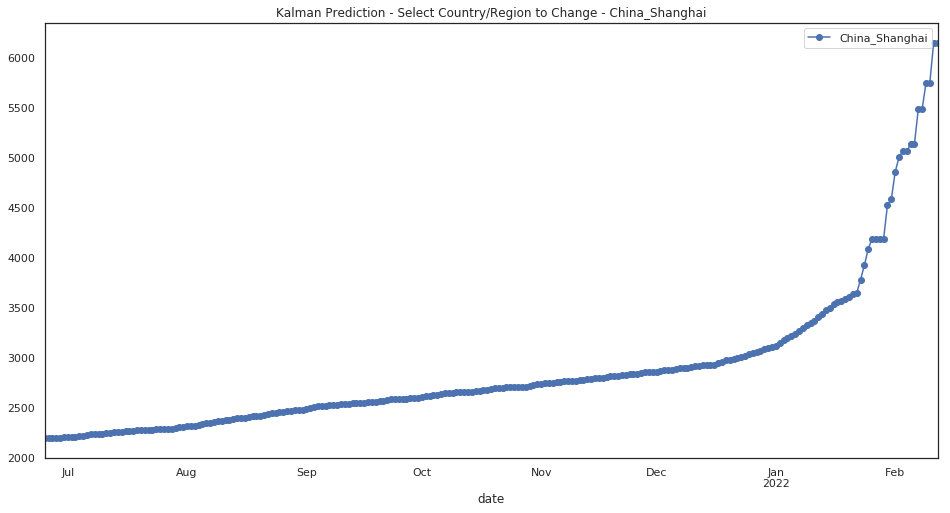

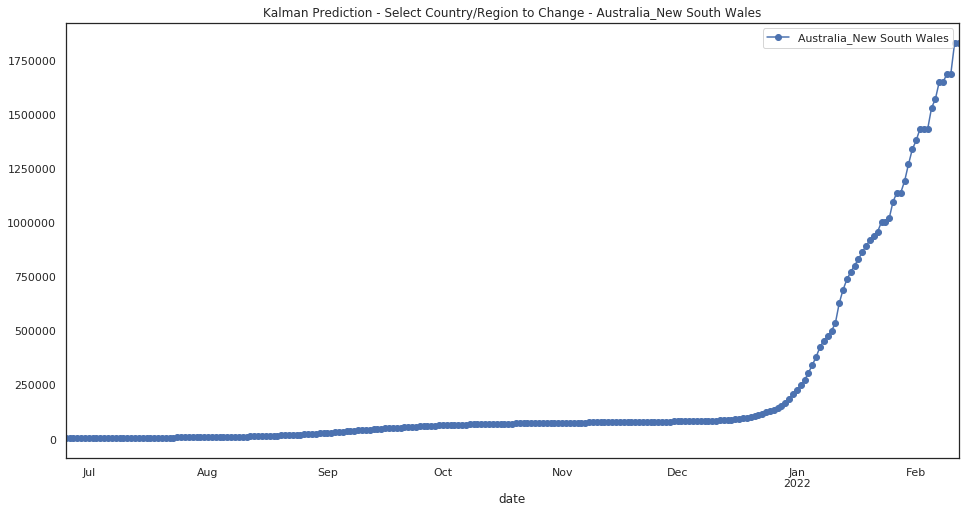

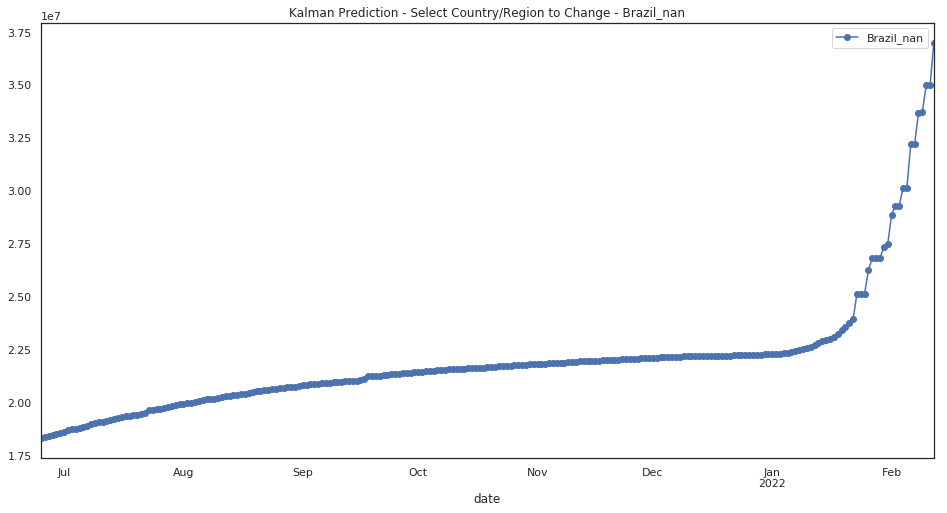

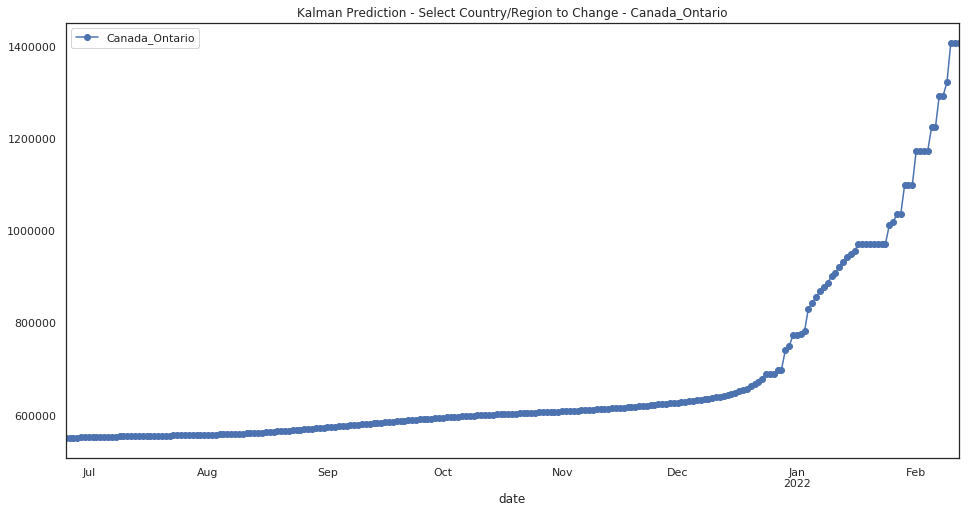

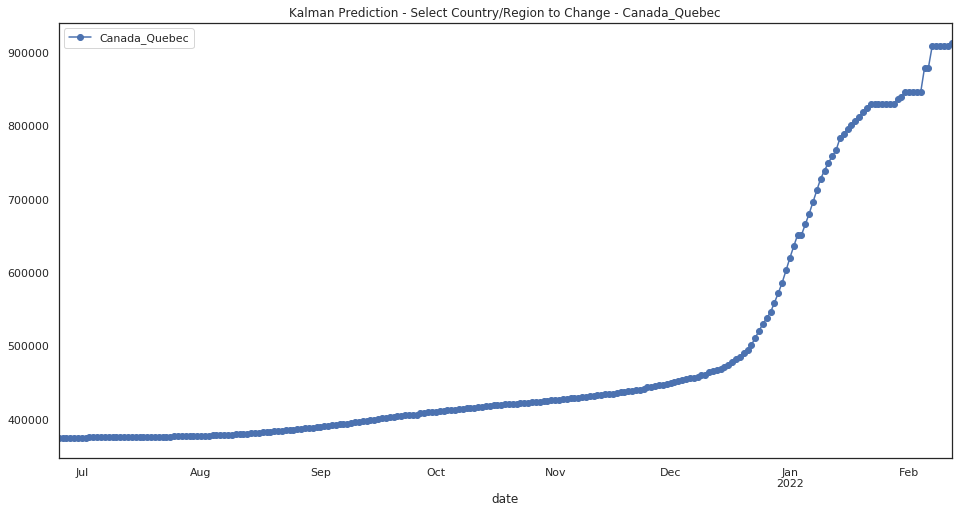

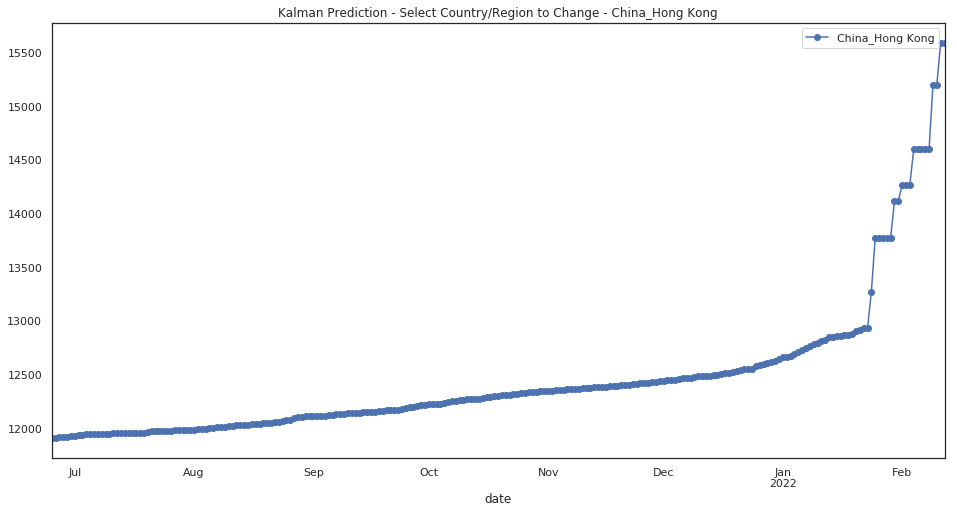

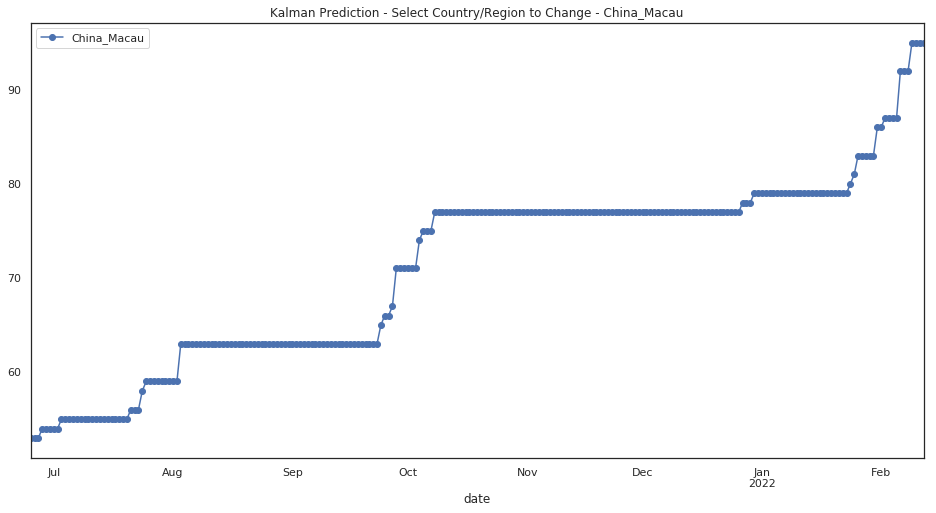

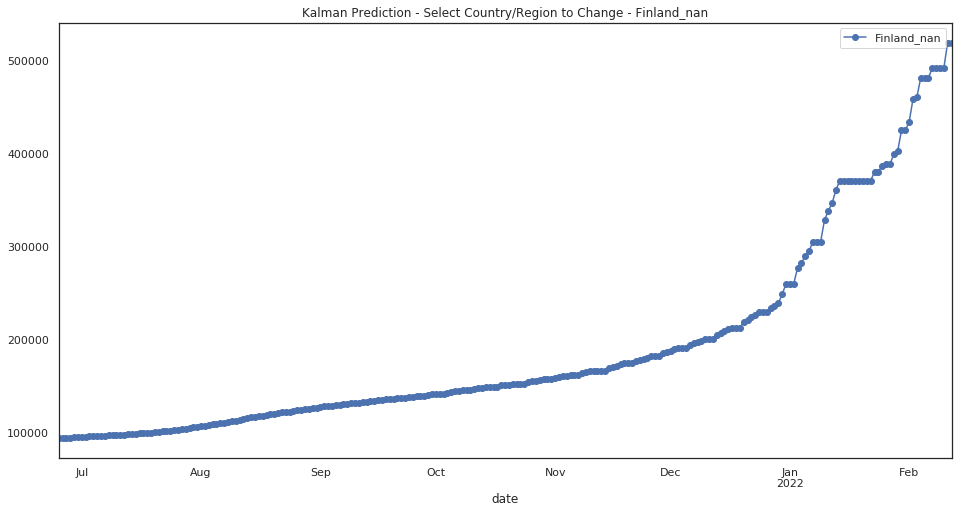

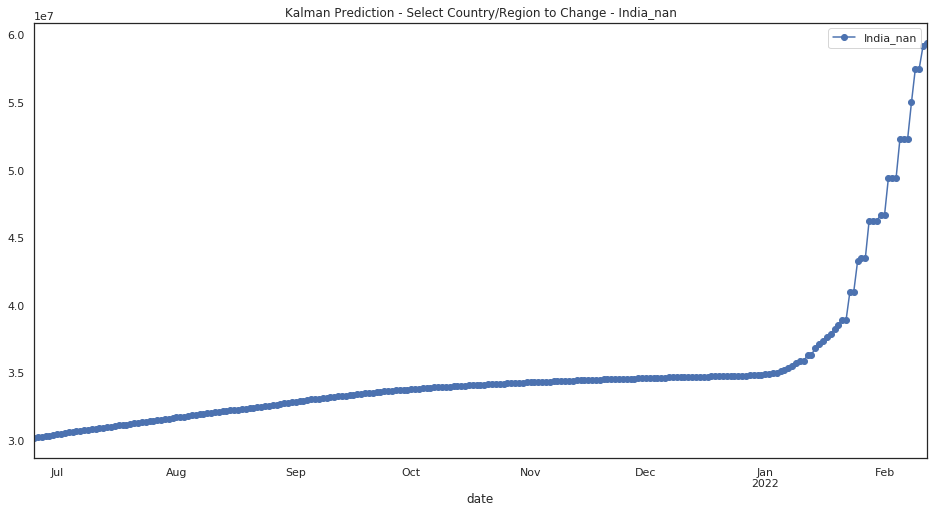

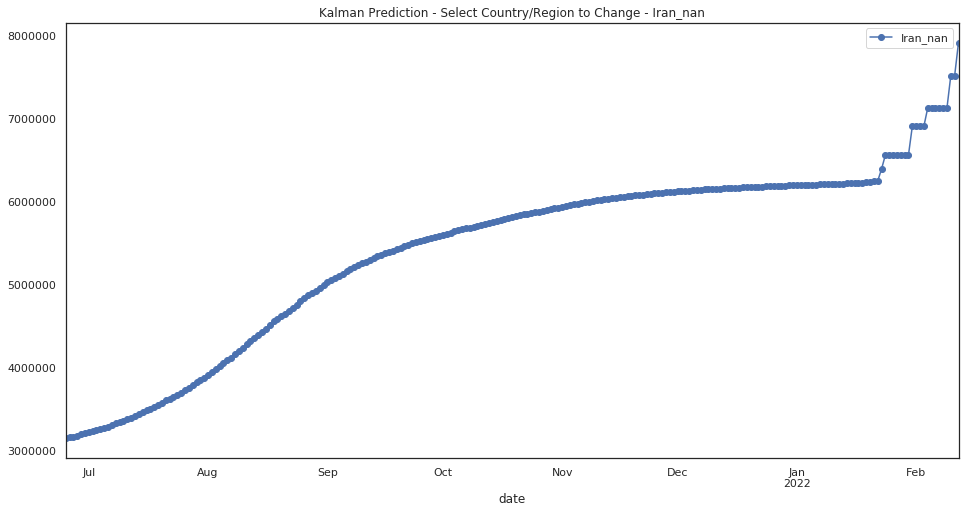

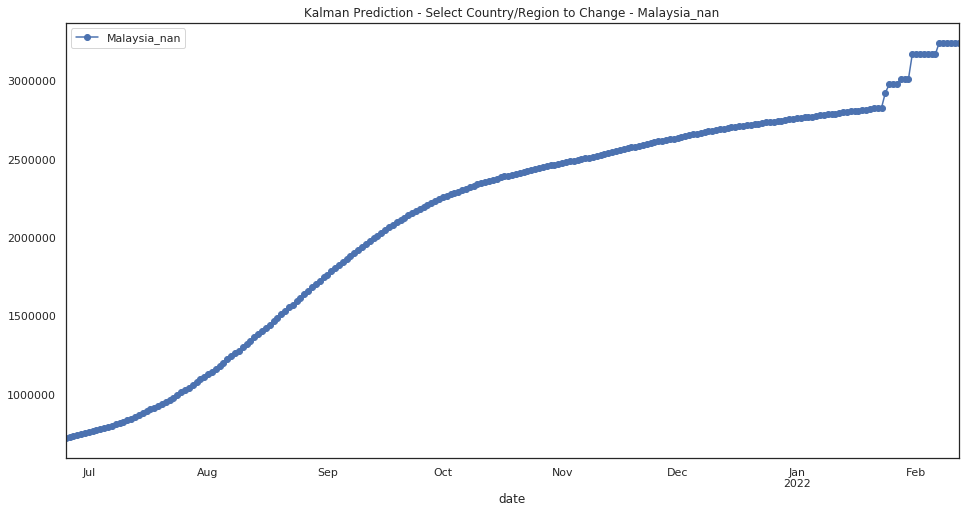

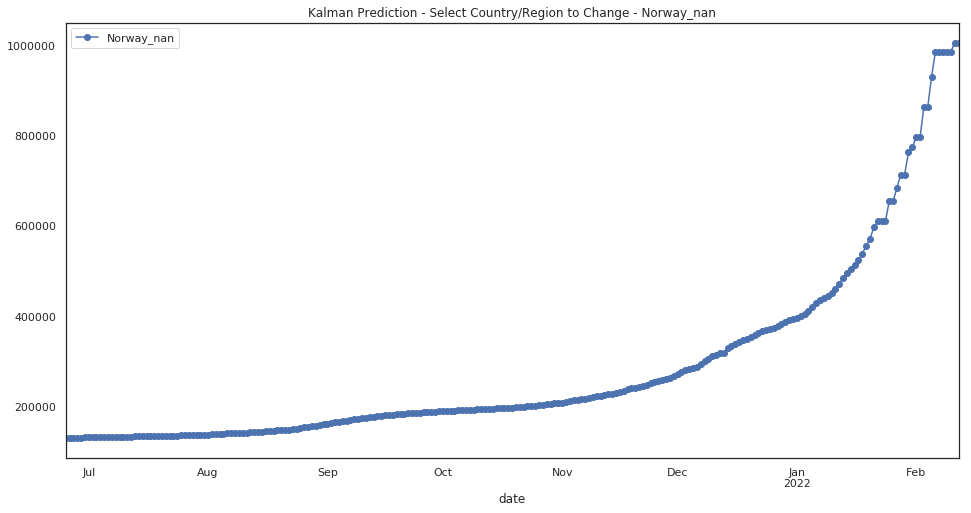

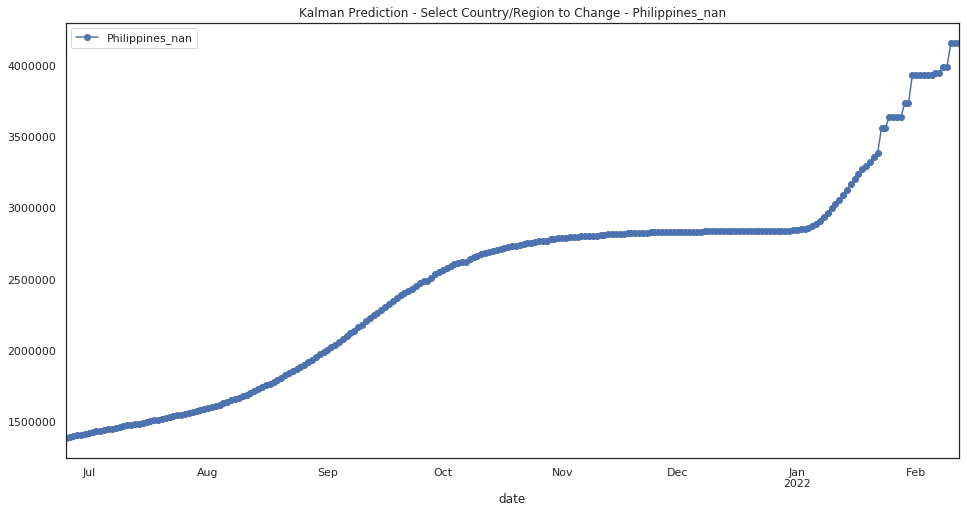

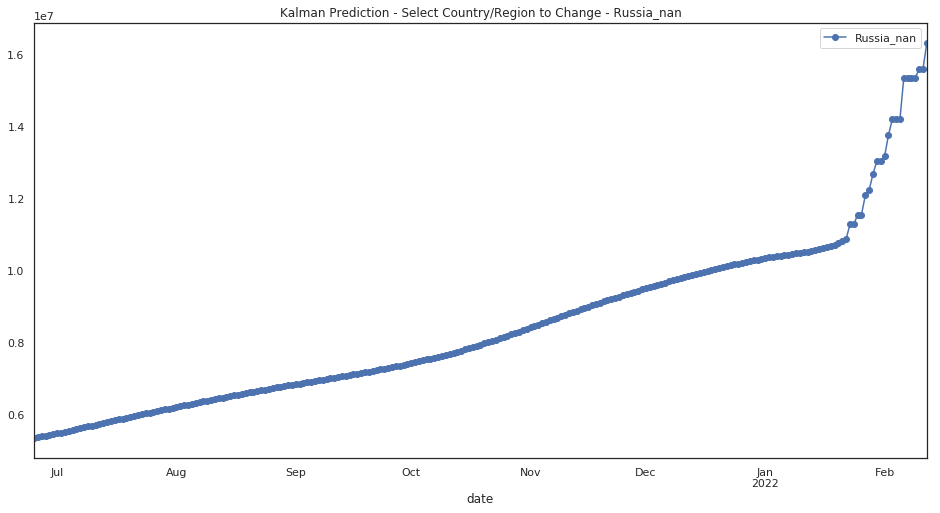

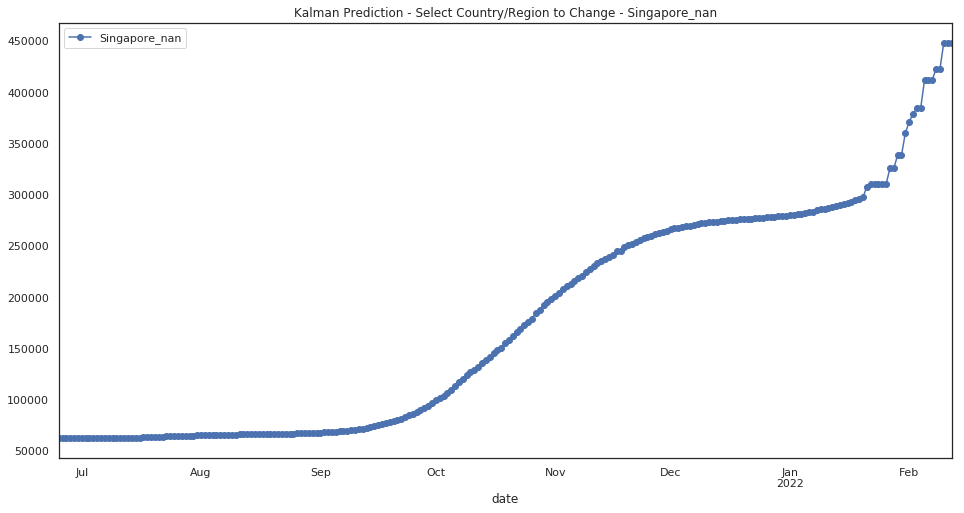

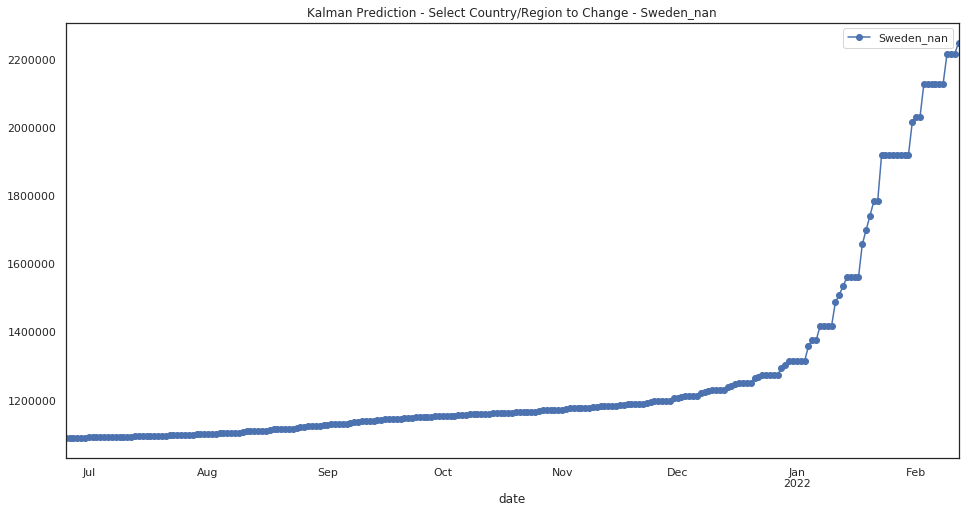

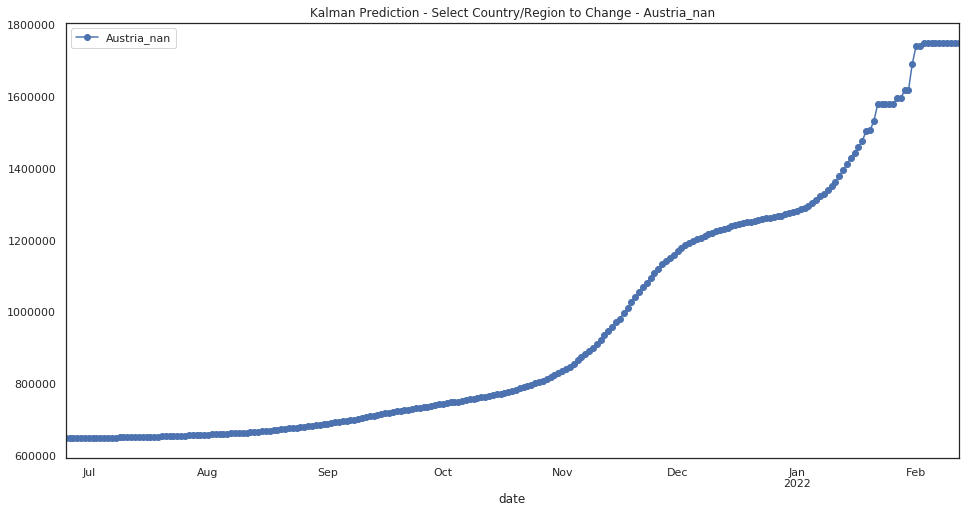

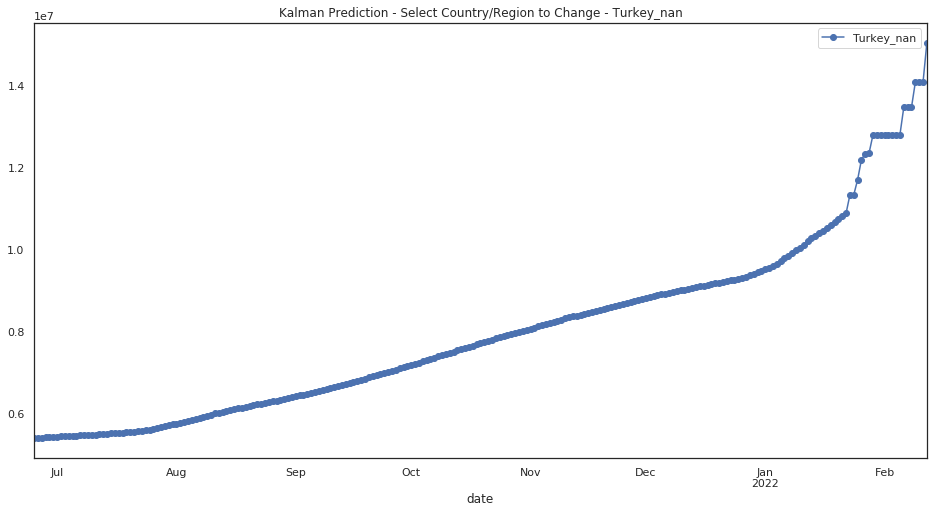

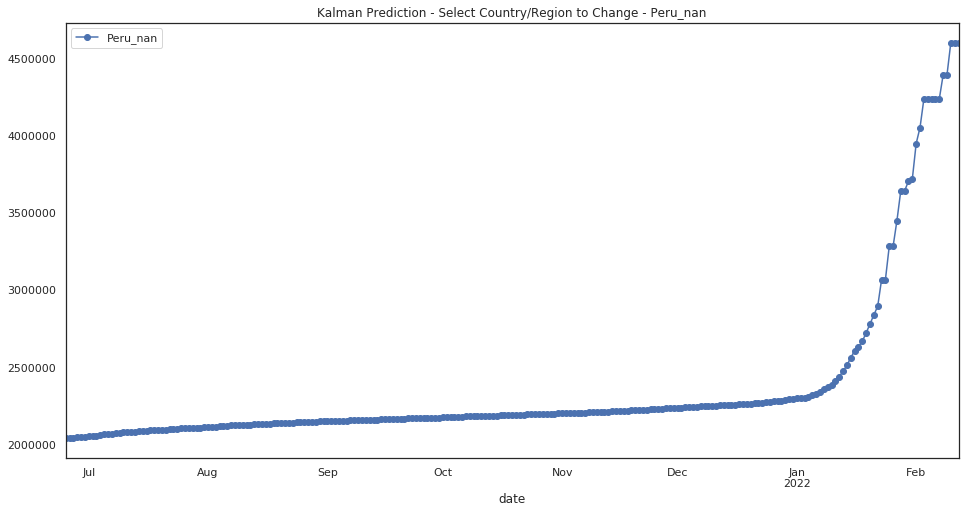

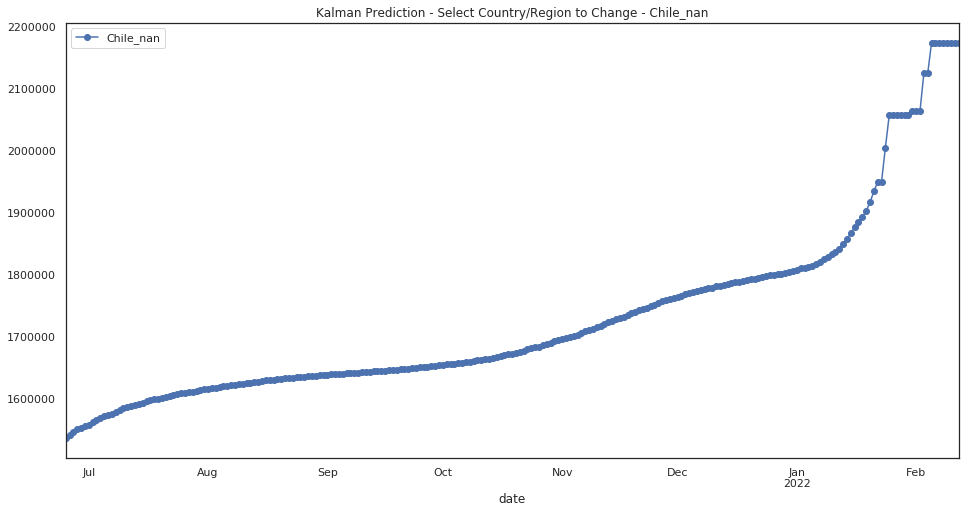

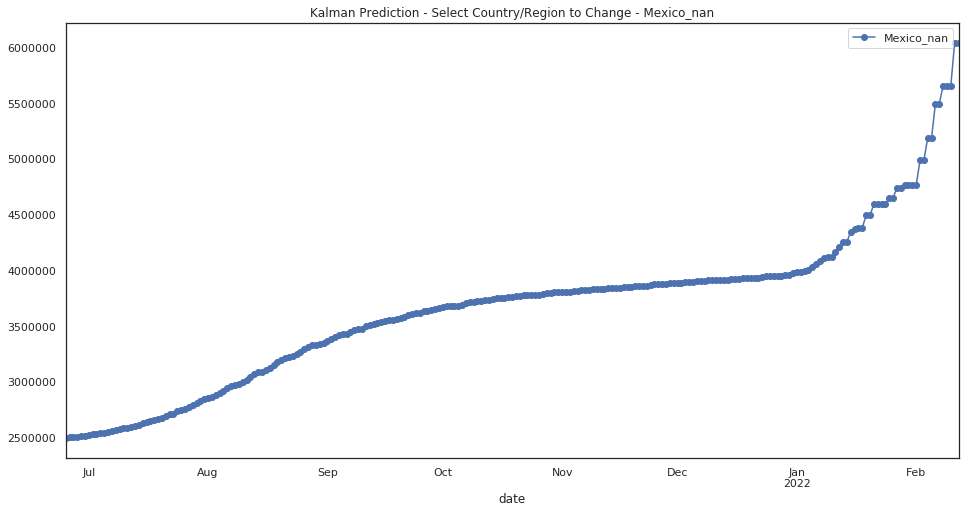

In [67]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [68]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2022-02-12 00:00:00
dtype: object


0  pred_confirmed
United States_nan                                   NaN      94967172.0
India_nan                                           NaN      59441237.0
Brazil_nan                                          NaN      37008075.0
France_nan                                          NaN      23566988.0
United Kingdom_nan                                  NaN      20939175.0
Russia_nan                                          NaN      16325424.0
Italy_nan                                           NaN      15066918.0
Turkey_nan                                          NaN      15050845.0
Spain_nan                                           NaN      12493734.0
Germany_nan                                         NaN      11021804.0
Argentina_nan                                       NaN       9652729.0
Iran_nan                                            NaN       7913658.0
Netherlands_nan                                     NaN       6153821.0
Ukraine_nan                                         NaN       6115212.0
Mexico_nan                                          NaN       6044838.0
Colombia_nan                                        NaN       6009055.0
Poland_nan                                          NaN       5259447.0
Indonesia_nan                                       NaN       5208854.0
Czechia_nan                                         NaN       5115640.0
Peru_nan                                            NaN       4600689.0
South Africa_nan                                    NaN       4327320.0
Belgium_nan                                         NaN       4211962.0
Philippines_nan                                     NaN       4162259.0
Malaysia_nan                                        NaN       3244804.0
Israel_nan                                          NaN       3051294.0
Japan_nan                                           NaN       2679239.0
Portugal_nan                                        NaN       2654118.0
Iraq_nan                                            NaN       2625217.0
Thailand_nan                                        NaN       2492390.0
Vietnam_nan                                         NaN       2487968.0
...                                                 ...             ...
Solomon Islands_nan                                 NaN           982.0
Palau_nan                                           NaN           824.0
Diamond Princess_nan                                NaN           779.0
China_Jilin                                         NaN           673.0
China_Chongqing                                     NaN           644.0
France_Wallis and Futuna                            NaN           637.0
China_Gansu                                         NaN           408.0
China_Shanxi                                        NaN           280.0
China_Hainan                                        NaN           212.0
China_Guizhou                                       NaN           186.0
United Kingdom_Montserrat                           NaN           180.0
China_Ningxia                                       NaN           157.0
China_Unknown                                       NaN           105.0
United Kingdom_Falkland Islands (Malvinas)          NaN           102.0
China_Macau                                         NaN            95.0
Samoa_nan                                           NaN            53.0
Holy See_nan                                        NaN            40.0
China_Qinghai                                       NaN            34.0
Canada_Repatriated Travellers                       NaN            18.0
Canada_Grand Princess                               NaN            14.0
MS Zaandam_nan                                      NaN             9.0
Vanuatu_nan                                         NaN             7.0
Marshall Islands_nan                                NaN             7.0
United Kingdom_Saint Helena, Ascension and Tris...  NaN             4.0
Kiribati_nan          

In [69]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [70]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [71]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [72]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [73]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [74]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-06-25         208683.0     226590.0     231099.0     125021.0   
2021-06-26         209995.0     226593.0     231391.0     125021.0   
2021-06-27         113124.0     132509.0     138113.0      13882.0   
2021-06-28         114220.0     132512.0     138465.0      13882.0   
2021-06-29         115751.0     132513.0     138840.0      13882.0   
2021-06-30         117158.0     132514.0     139229.0      13900.0   
2021-07-01         118659.0     132521.0     139626.0      13911.0   
2021-07-02         120216.0     132523.0     140075.0      13918.0   
2021-07-03         124415.0     133917.0     142607.0      14102.0   
2021-07-04         125966.0     133917.0     143077.0      14099.0   
2021-07-05         127200.0     133922.0     143567.0      14097.0   
2021-07-06         128703.0     133927.0     144042.0      14160.0   
2021-07-07         130129.0     133938.0     144618.0      13991.0   
2021-07-08         131290.0     133945.0     145206.0      14021.0   
2021-07-09         132888.0     133960.0     145999.0      14060.0   
2021-07-10         133976.0     133966.0     146761.0      14087.0   
2021-07-11         134940.0     133974.0     147546.0      14277.0   
2021-07-12         136110.0     133980.0     148426.0      14338.0   
2021-07-13         137225.0     133990.0     149333.0      14155.0   
2021-07-14         137995.0     133996.0     150240.0      14277.0   
2021-07-15         139297.0     134010.0     151334.0      14426.0   
2021-07-16         140351.0     134025.0     152475.0      14239.0   
2021-07-17         141535.0     134041.0     153581.0      14273.0   
2021-07-18         142043.0     134062.0     154711.0      14472.0   
2021-07-19         143102.0     134074.0     155884.0      14528.0   
2021-07-20         143855.0     134115.0     157152.0      14359.0   
2021-07-21         144278.0     134130.0     158364.0      14414.0   
2021-07-22         144852.0     134170.0     159598.0      14641.0   
2021-07-23         145102.0     134198.0     160935.0      14464.0   
2021-07-24         145370.0     134224.0     162222.0      14498.0   
...                     ...          ...          ...          ...   
2022-01-15         160432.0     231642.0     227131.0      29888.0   
2022-01-16         160471.0     233401.0     227693.0      29888.0   
2022-01-17         160569.0     234509.0     228369.0      29888.0   
2022-01-18         160698.0     237063.0     229163.0      29888.0   
2022-01-19         160794.0     239784.0     230444.0      29888.0   
2022-01-20         161018.0     242193.0     231975.0      30188.0   
2022-01-21         161207.0     244804.0     233787.0      32201.0   
2022-01-22         161270.0     247110.0     235950.0      33025.0   
2022-01-23         161310.0     247409.0     236276.0      33025.0   
2022-01-24         162560.0     257817.0     239877.0      33631.0   
2022-01-25         163820.0     267444.0     240632.0      34889.0   
2022-01-26         169510.0     274629.0     242102.0      34889.0   
2022-01-27         169576.0     275553.0     242452.0      34889.0   
2022-01-28         170749.0     274903.0     246282.0      36532.0   
2022-01-29         170744.0     293584.0     247132.0      36820.0   
2022-01-30         170735.0     298865.0     248569.0      36820.0   
2022-01-31         177351.0     299950.0     260822.0      36869.0   
2022-02-01         180217.0     302029.0     269022.0      39263.0   
2022-02-02         181492.0     301932.0     269561.0      39263.0   
2022-02-03         181900.0     301801.0     268989.0      39970.0   
2022-02-04         186357.0     301838.0     269074.0      39970.0   
2022-02-05         192346.0     315248.0     278524.0      39970.0   
2022-02-06         193273.0     319681.0     288116.0      39970.0   
2022-02-07         193919.0     317313.0     289375.0      42711.0   
2022-02-08

In [75]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [76]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'France_nan',
 'United Kingdom_nan',
 'Russia_nan',
 'Italy_nan',
 'Turkey_nan',
 'Spain_nan',
 'Germany_nan',
 'Argentina_nan',
 'Iran_nan',
 'Netherlands_nan',
 'Ukraine_nan',
 'Mexico_nan',
 'Colombia_nan',
 'Poland_nan',
 'Indonesia_nan',
 'Czechia_nan',
 'Peru_nan',
 'South Africa_nan',
 'Belgium_nan',
 'Philippines_nan',
 'Malaysia_nan',
 'Israel_nan',
 'Japan_nan',
 'Portugal_nan',
 'Iraq_nan',
 'Thailand_nan',
 'Vietnam_nan',
 'Romania_nan',
 'Sweden_nan',
 'Hungary_nan',
 'Chile_nan',
 'Switzerland_nan',
 'Greece_nan',
 'Serbia_nan',
 'Bangladesh_nan',
 'Australia_New South Wales',
 'Austria_nan',
 'Ireland_nan',
 'Slovakia_nan',
 'Morocco_nan',
 'Denmark_nan',
 'Pakistan_nan',
 'Kazakhstan_nan',
 'Jordan_nan',
 'Cuba_nan',
 'Canada_Ontario',
 'Croatia_nan',
 'Georgia_nan',
 'Bolivia_nan',
 'Tunisia_nan',
 'Lebanon_nan',
 'Australia_Victoria',
 'Korea, South_nan',
 'Nepal_nan',
 'United Arab Emirates_nan',
 'Norway_nan',
 'Bu

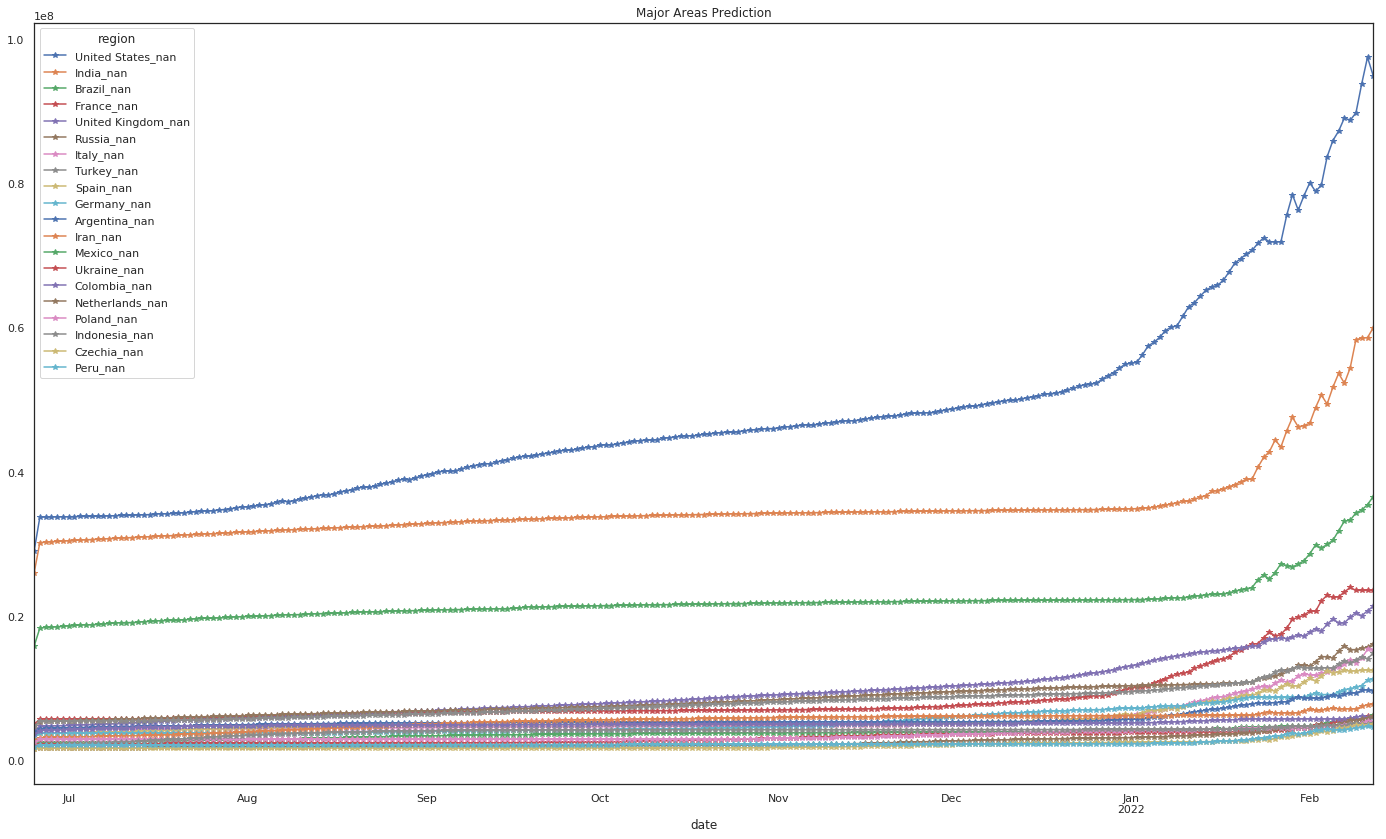

In [77]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

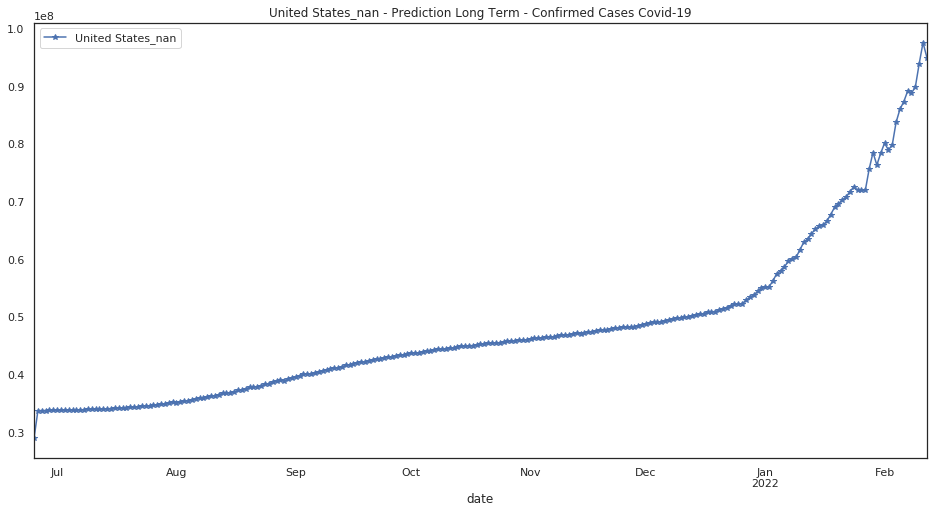

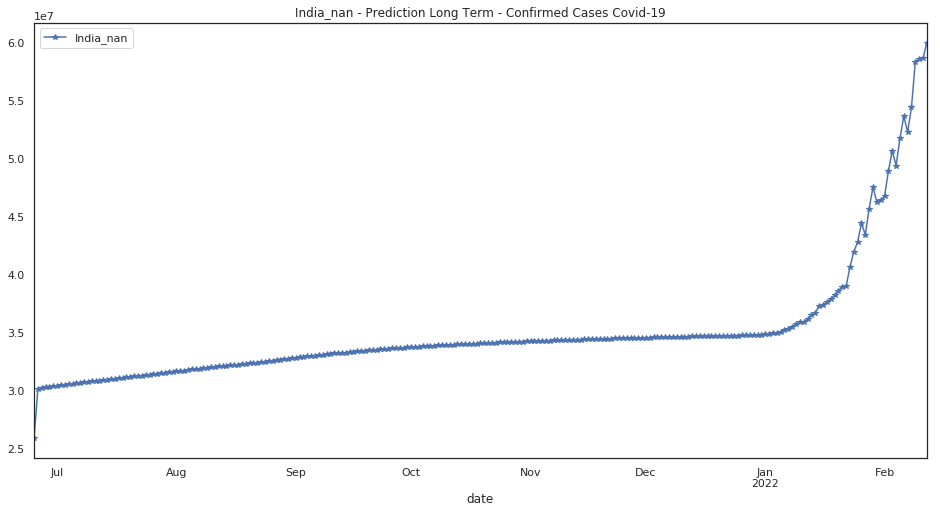

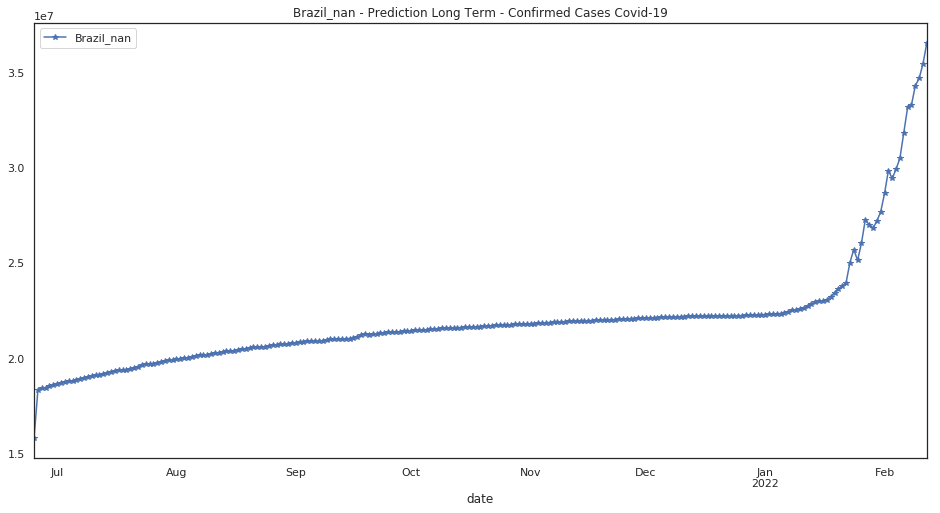

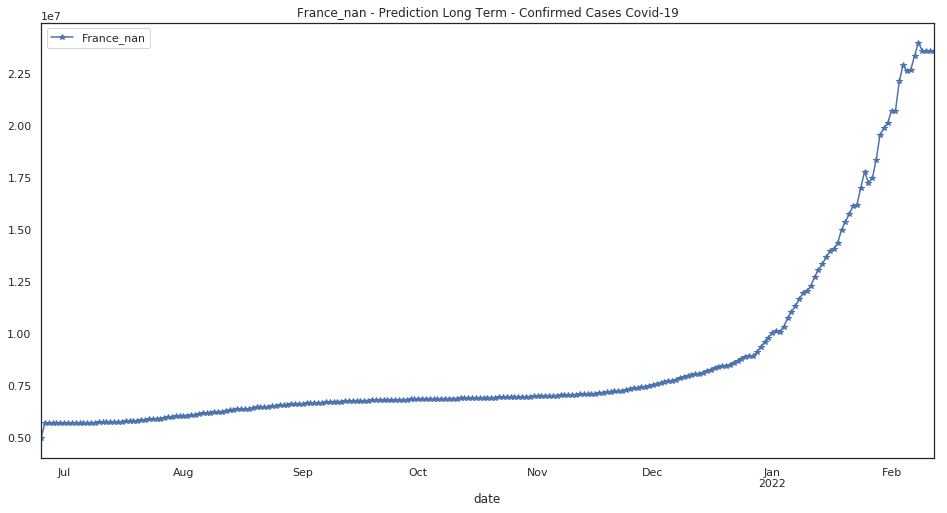

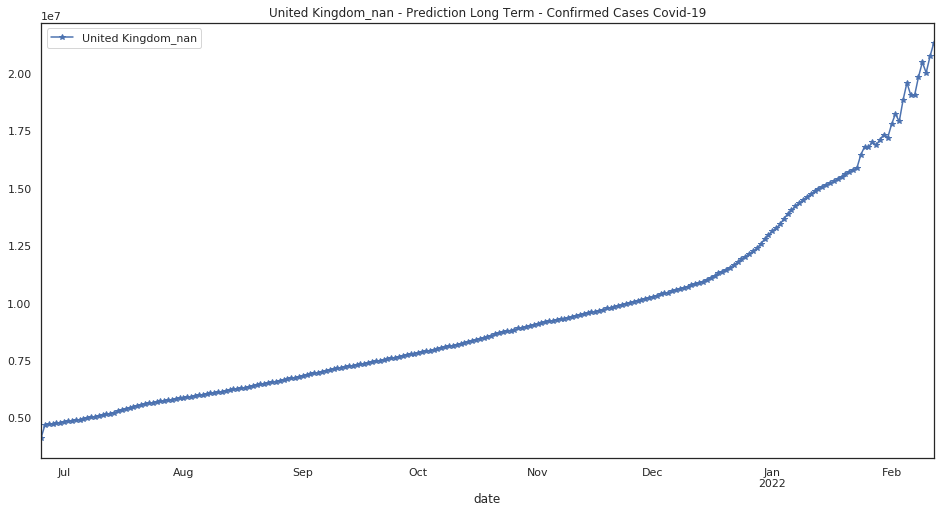

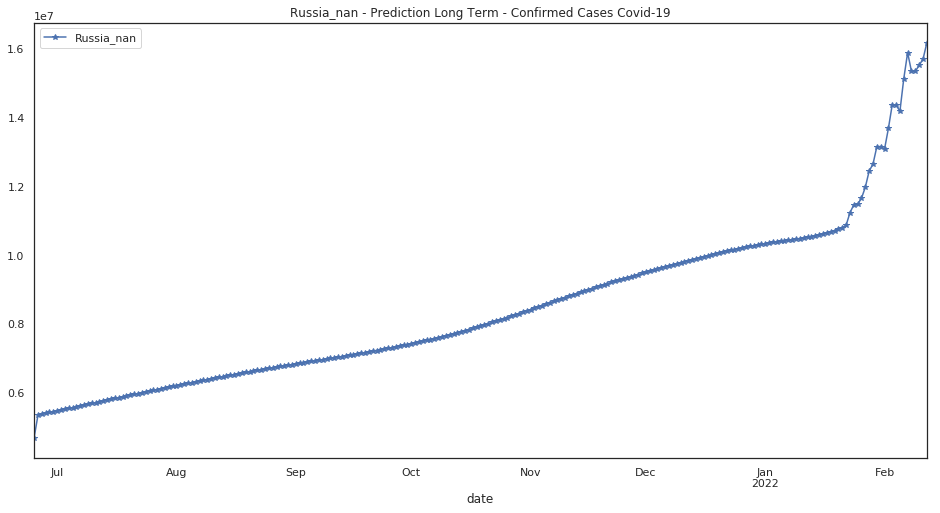

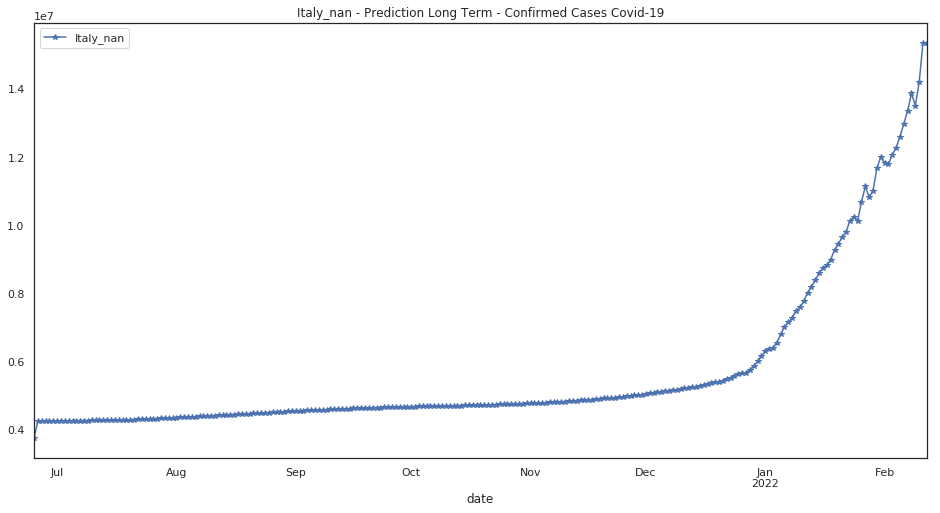

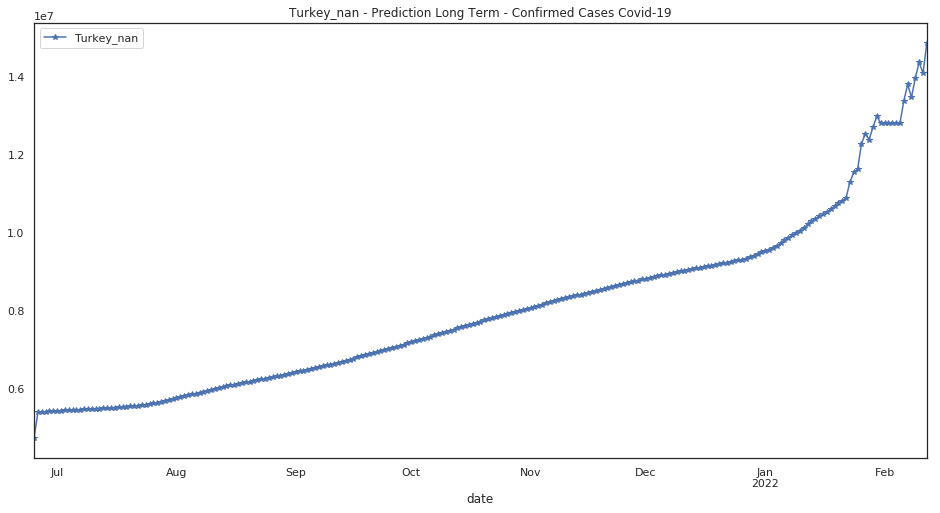

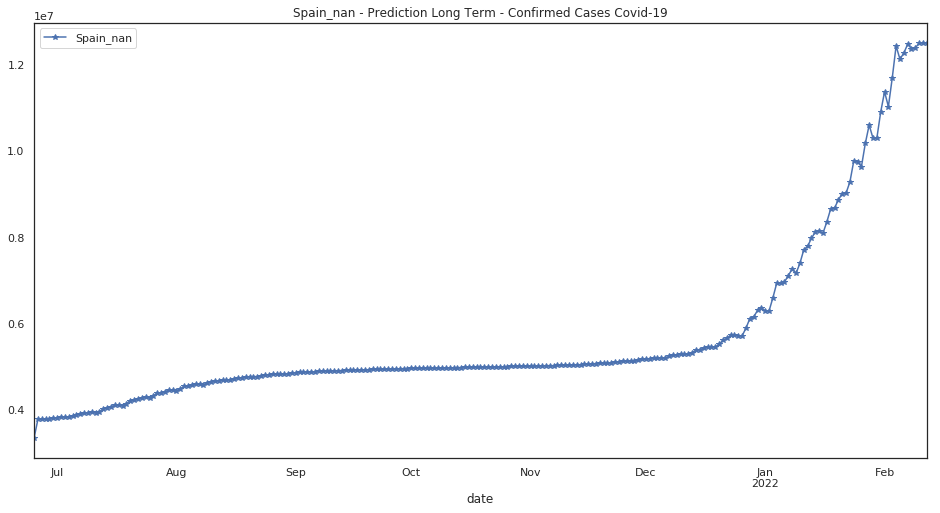

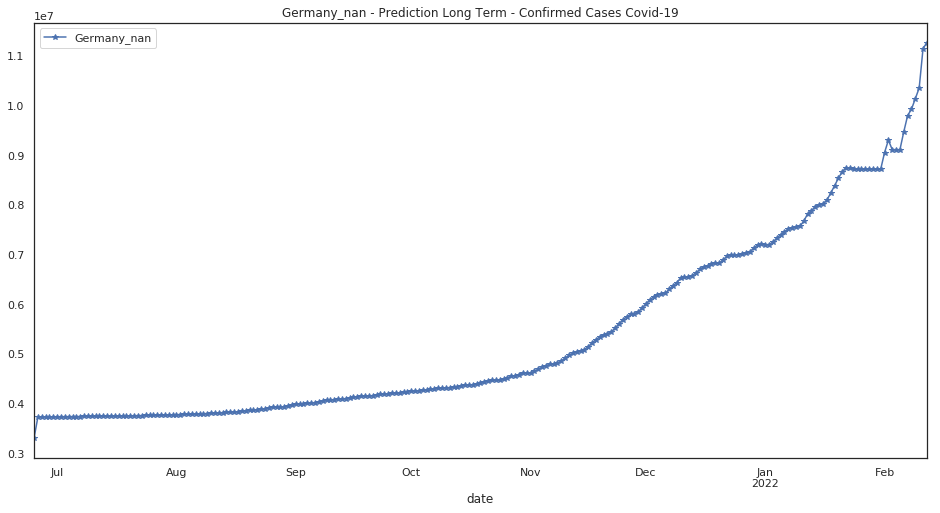

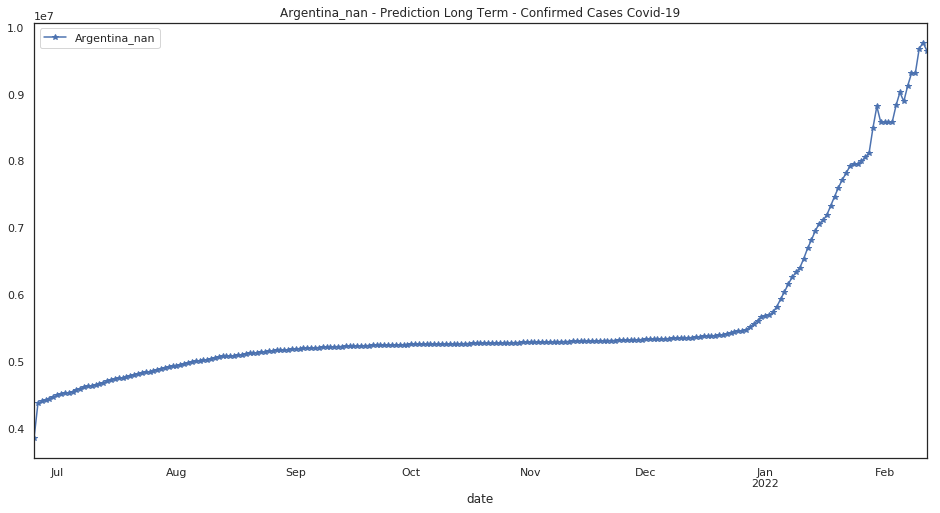

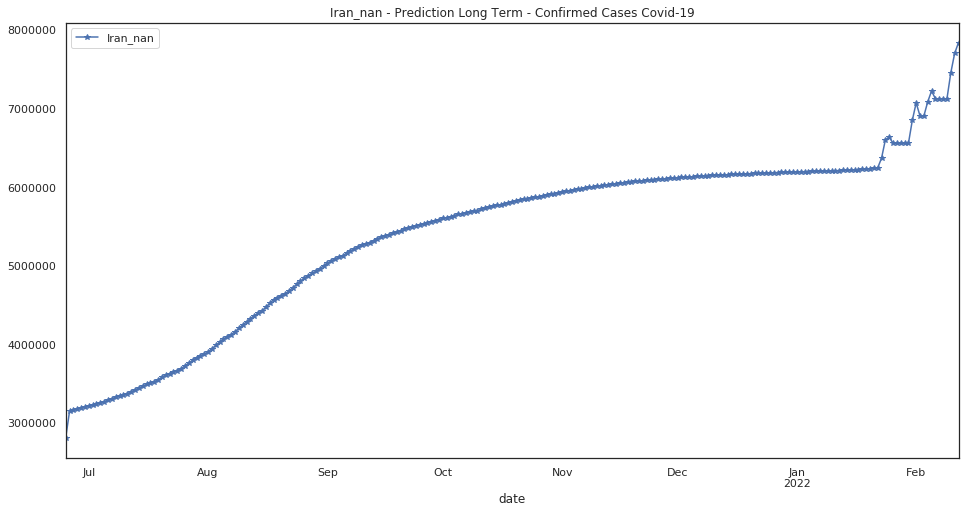

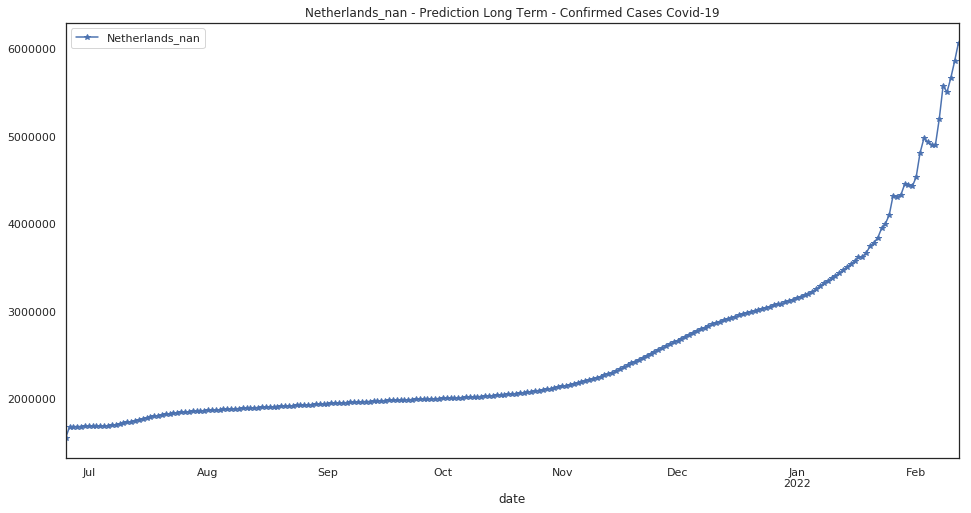

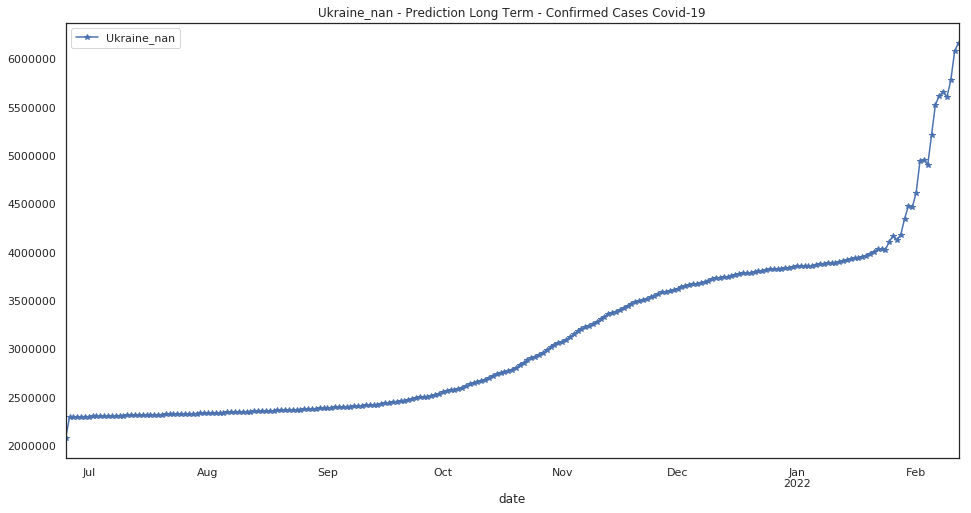

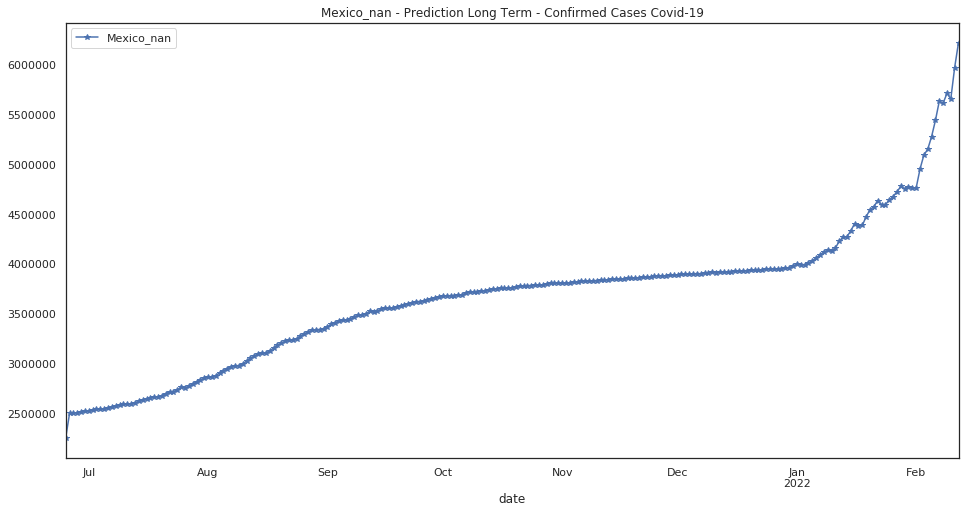

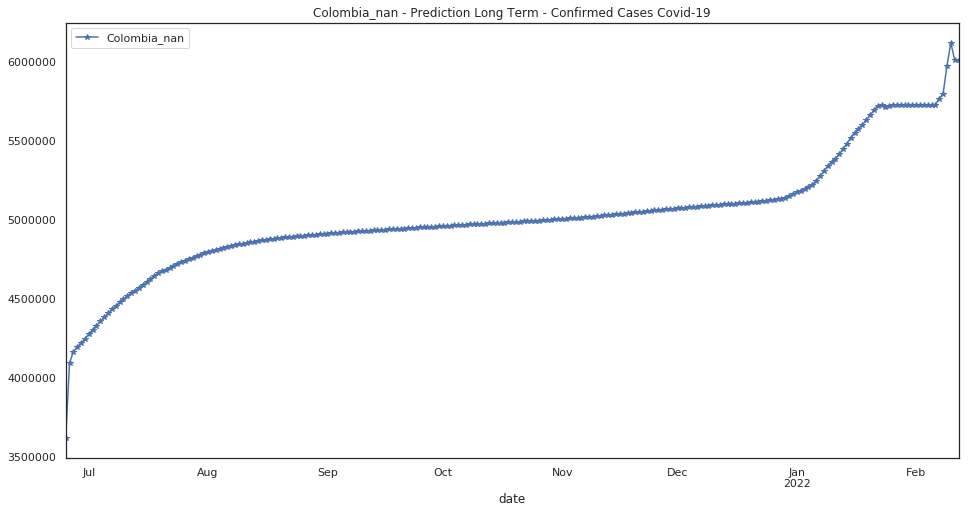

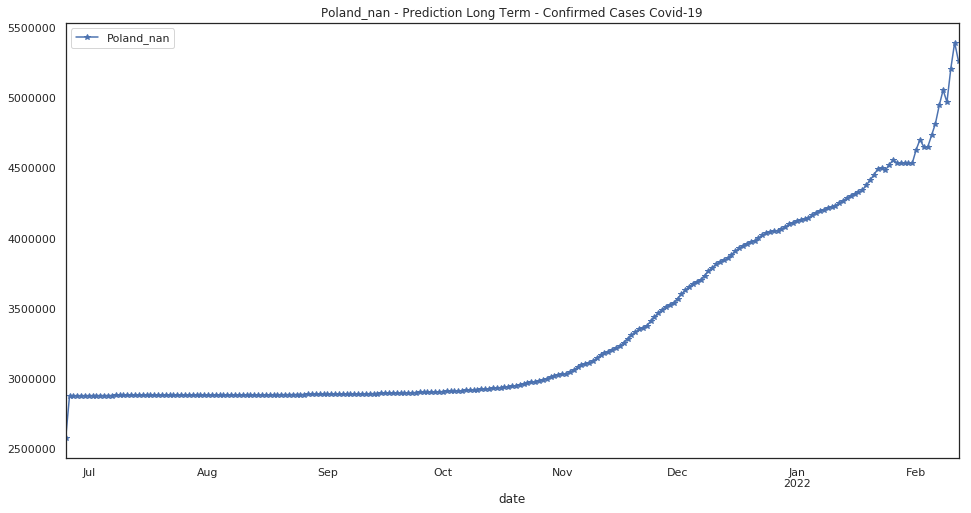

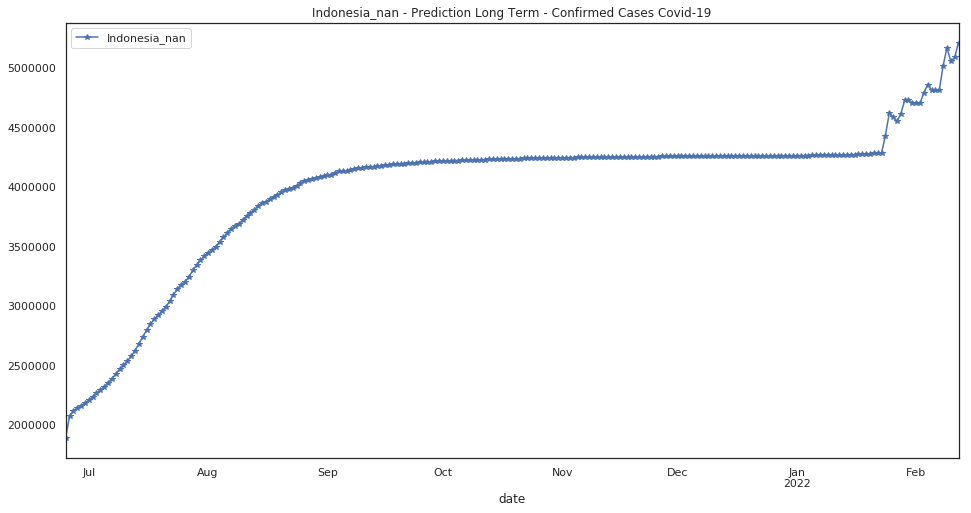

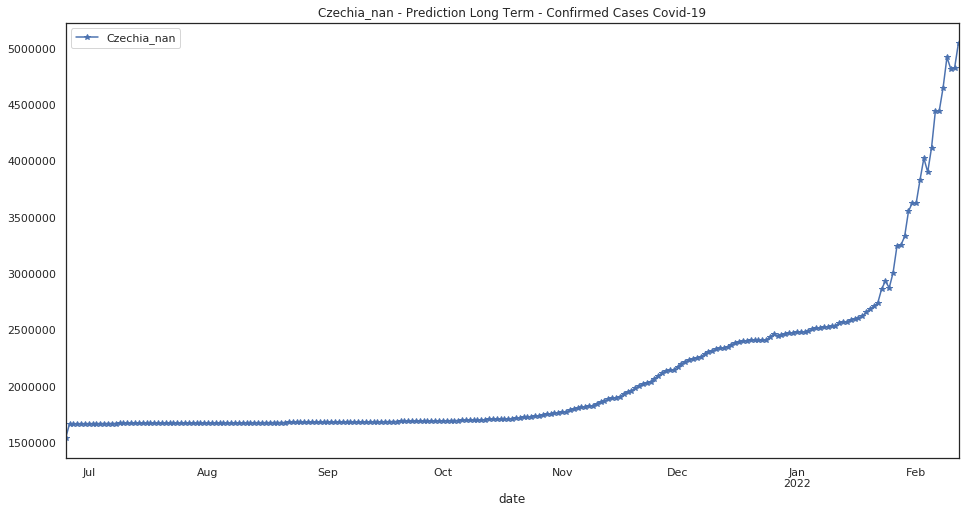

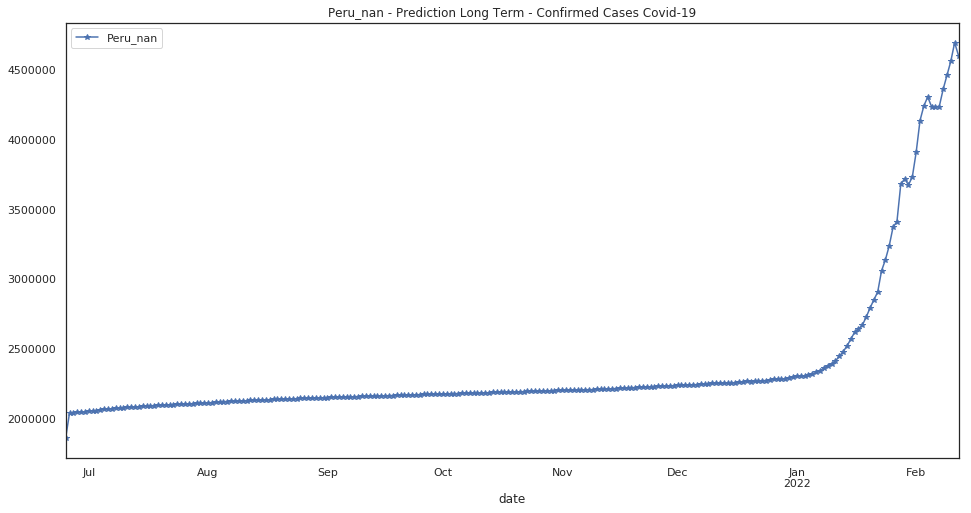

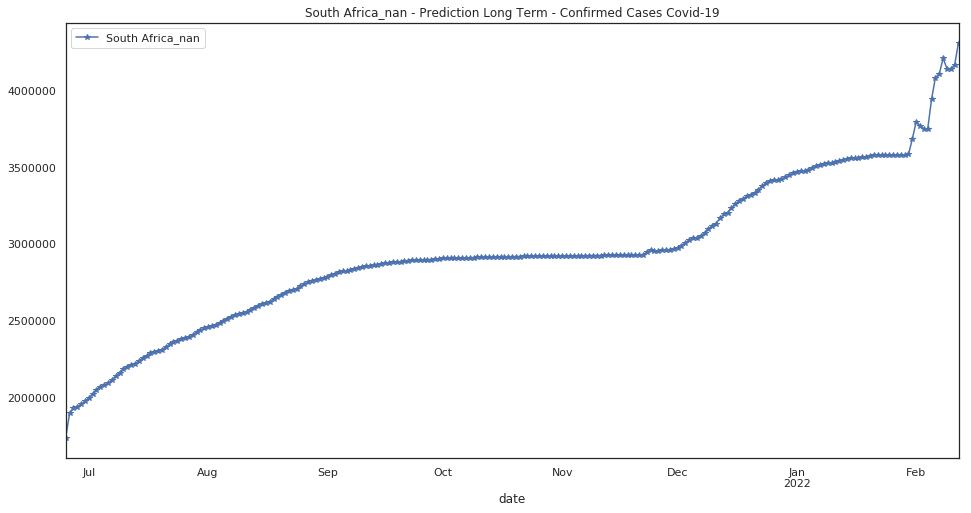

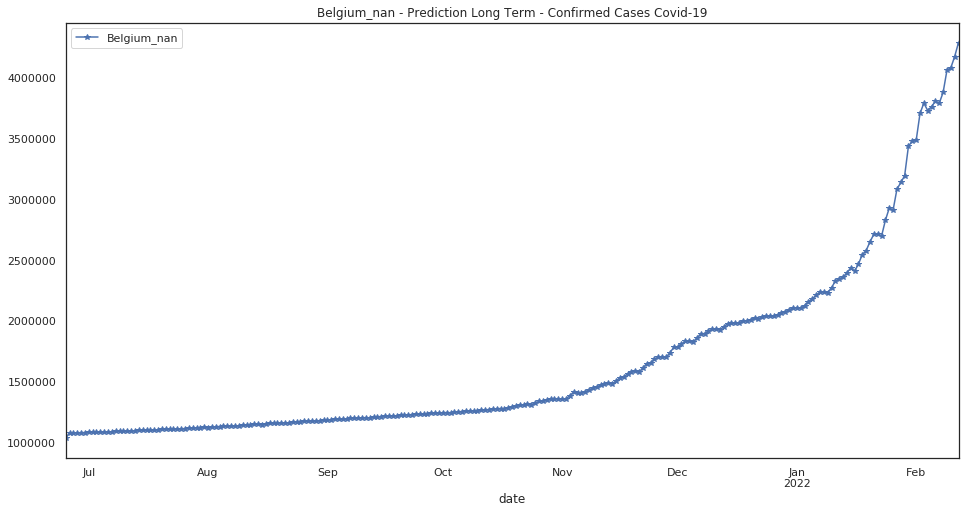

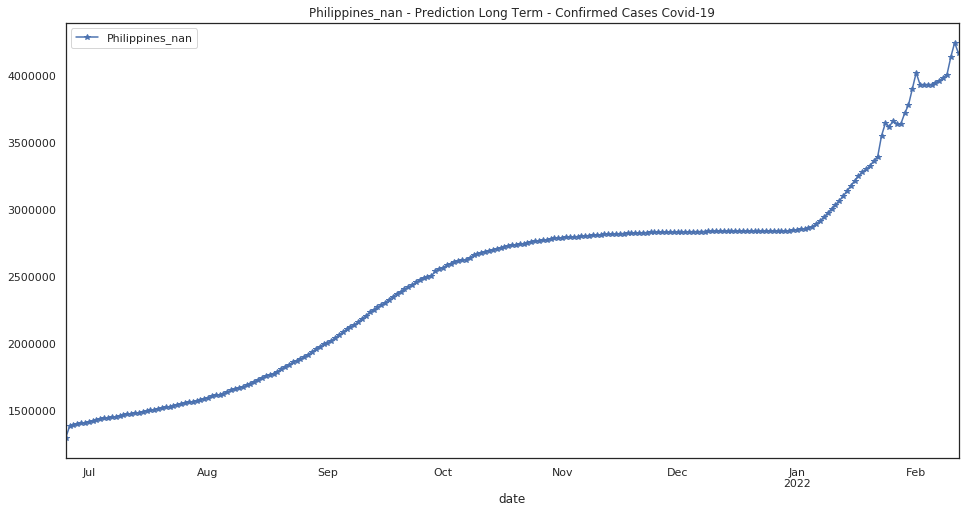

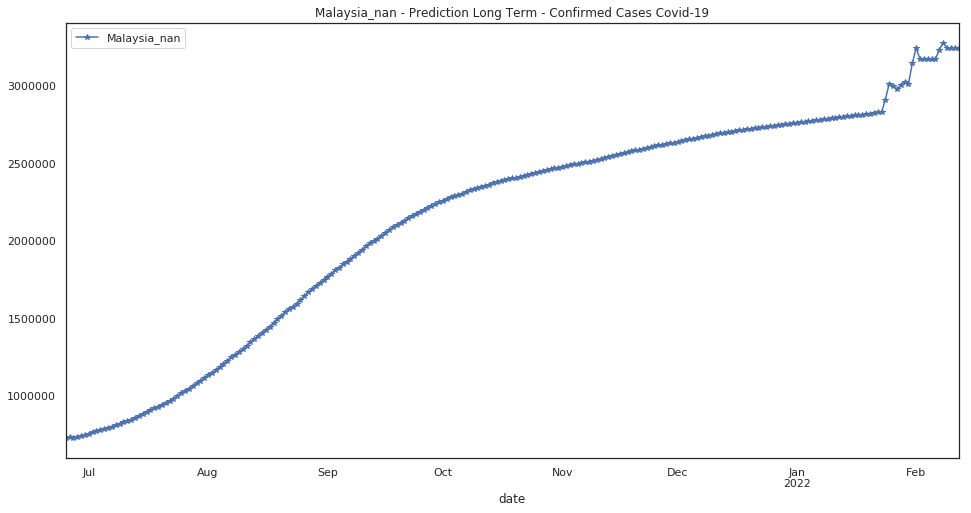

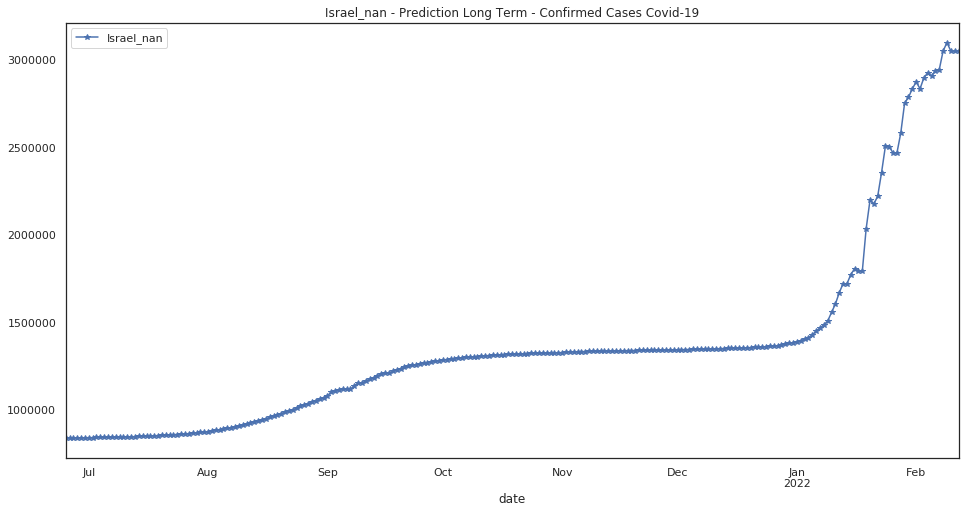

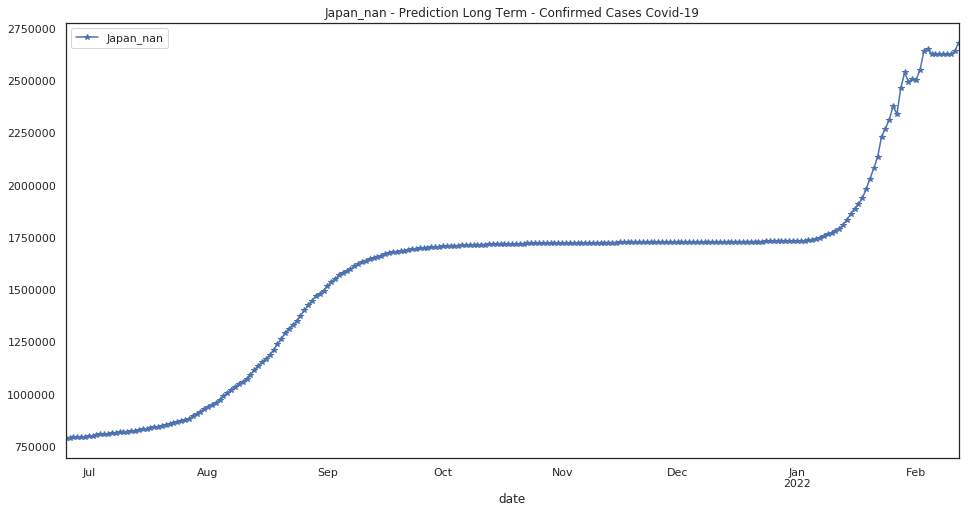

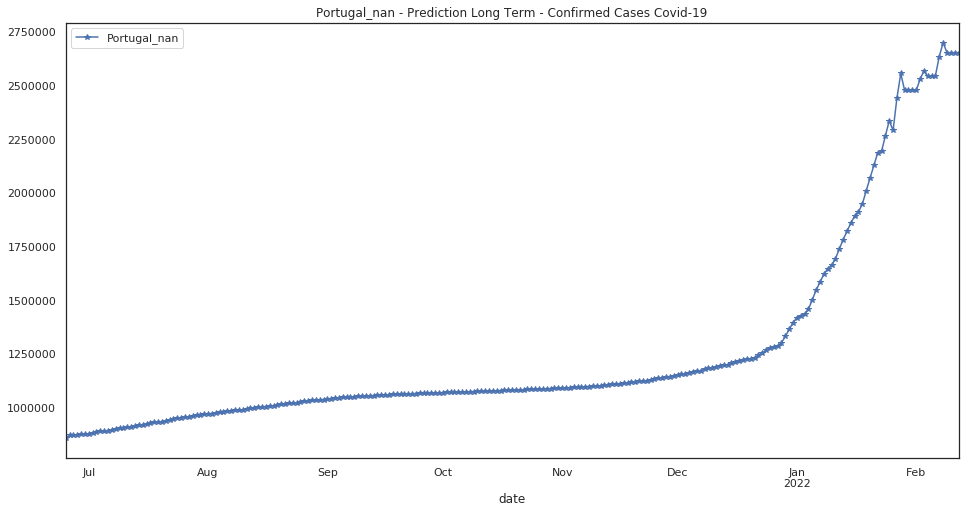

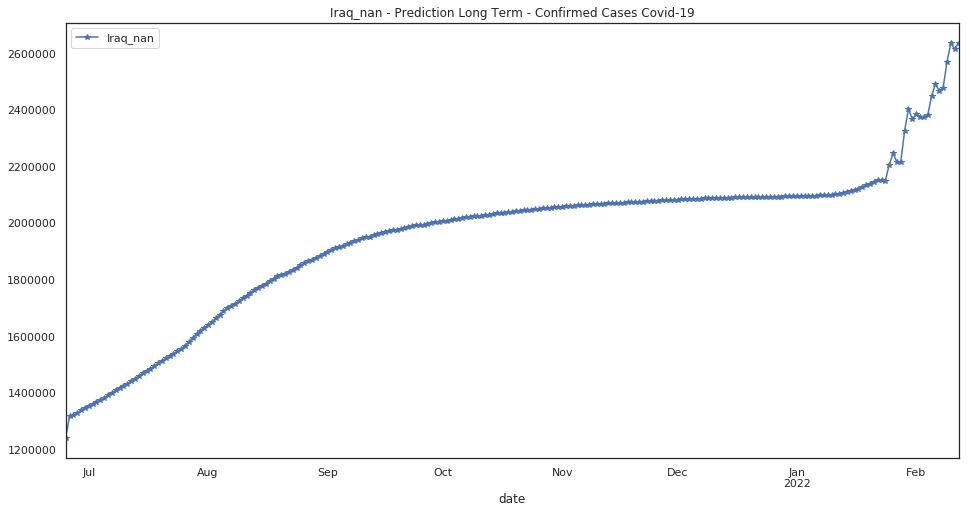

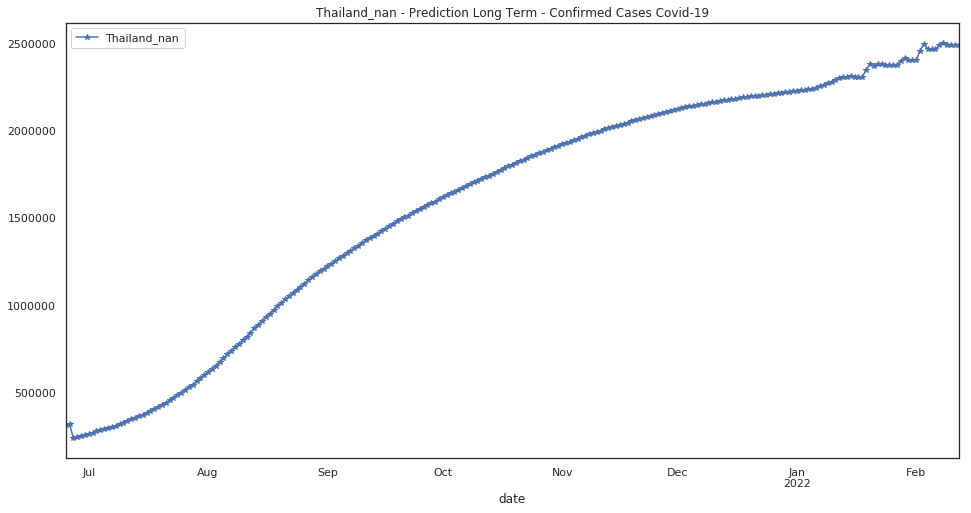

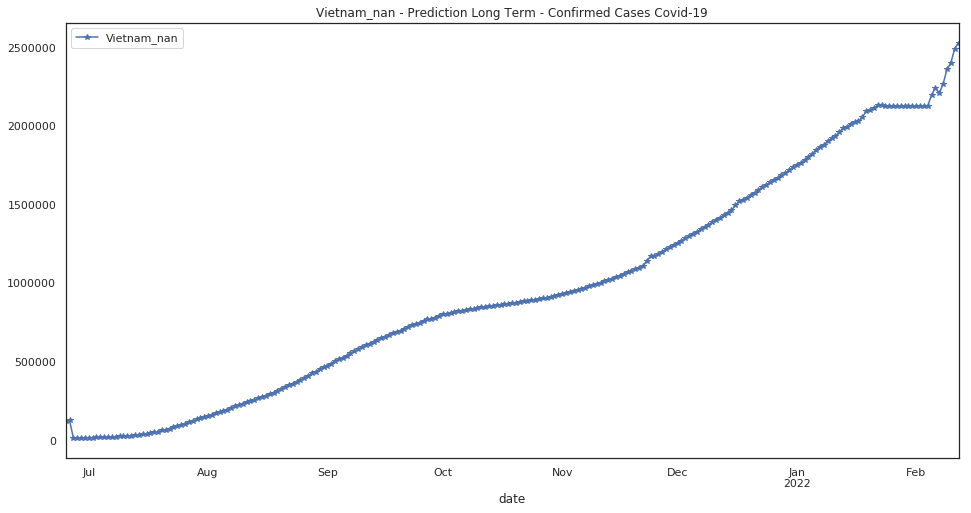

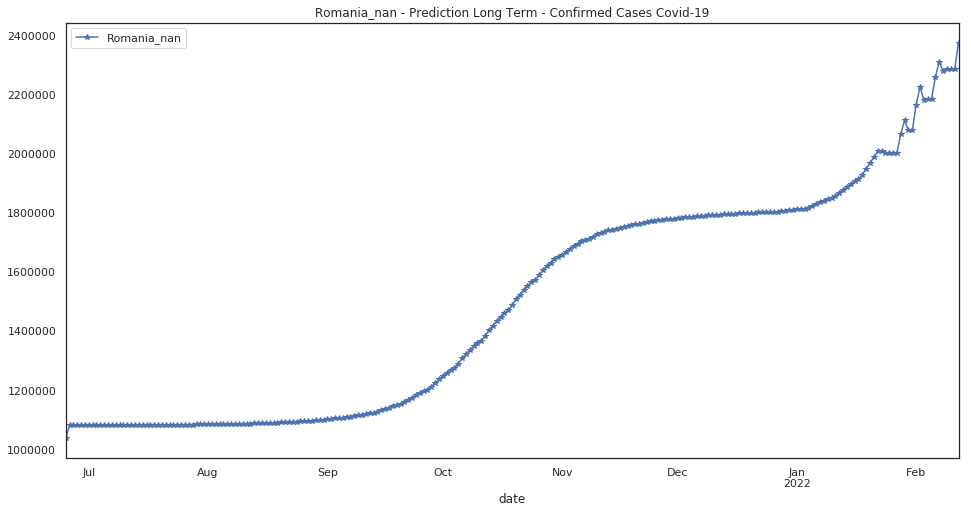

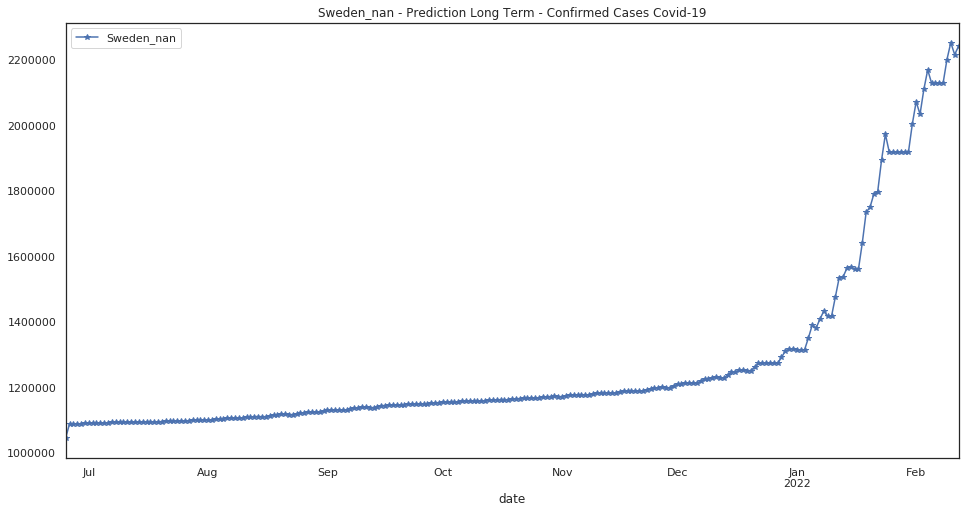

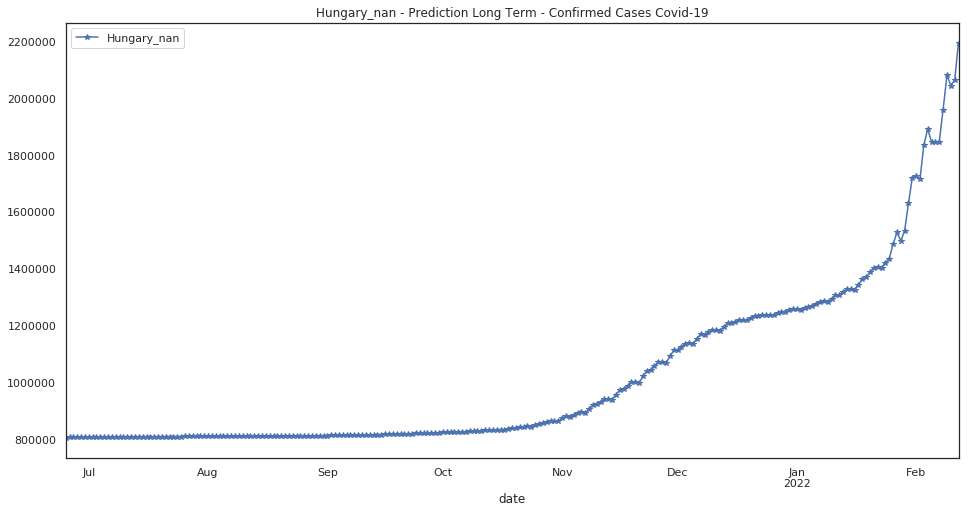

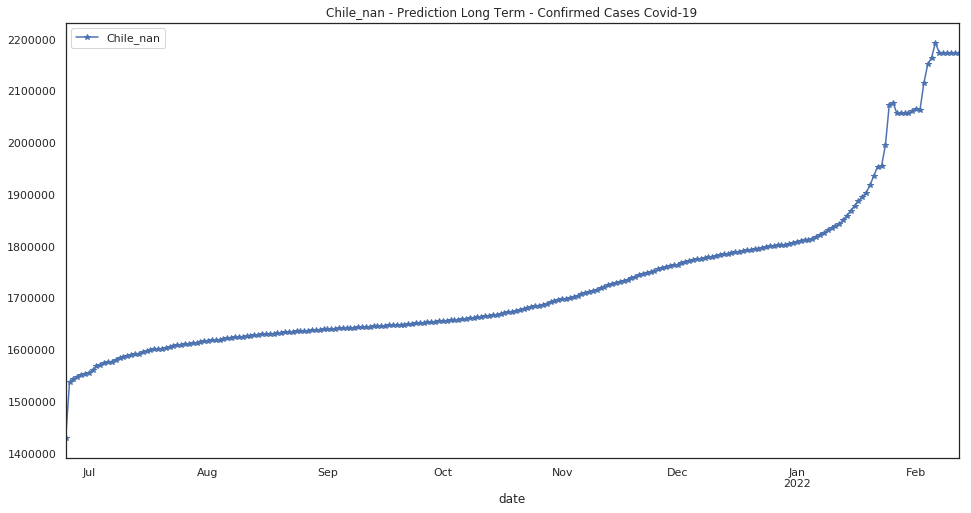

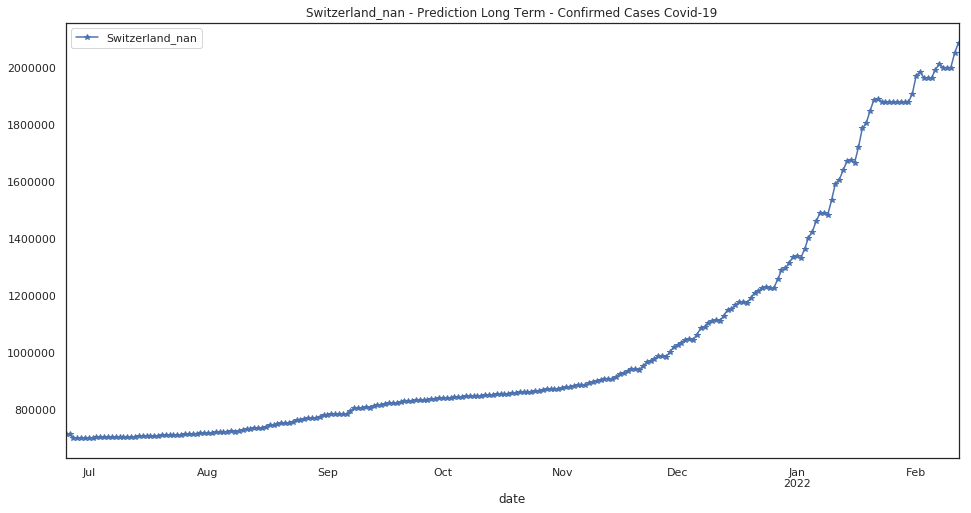

In [78]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

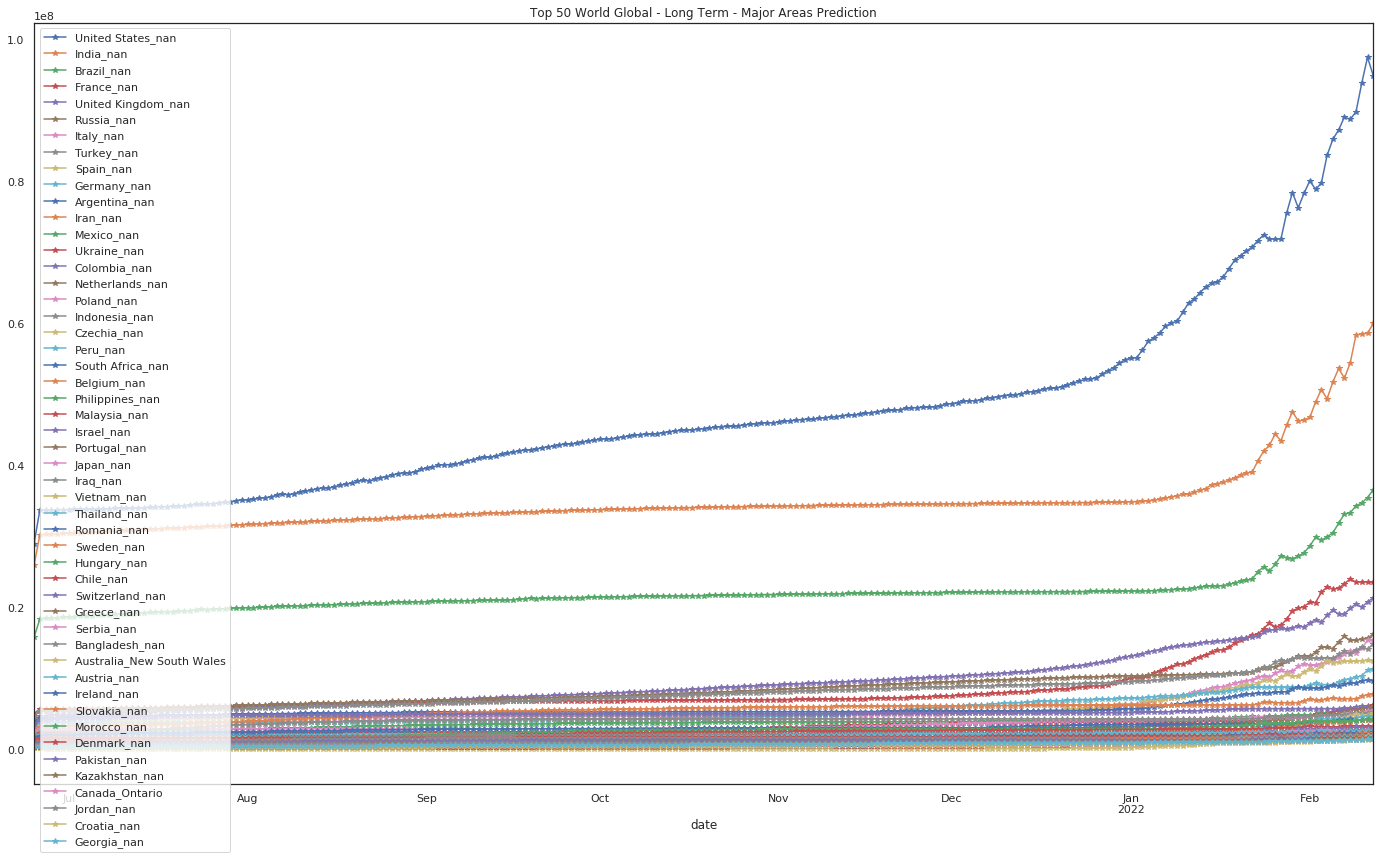

In [79]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

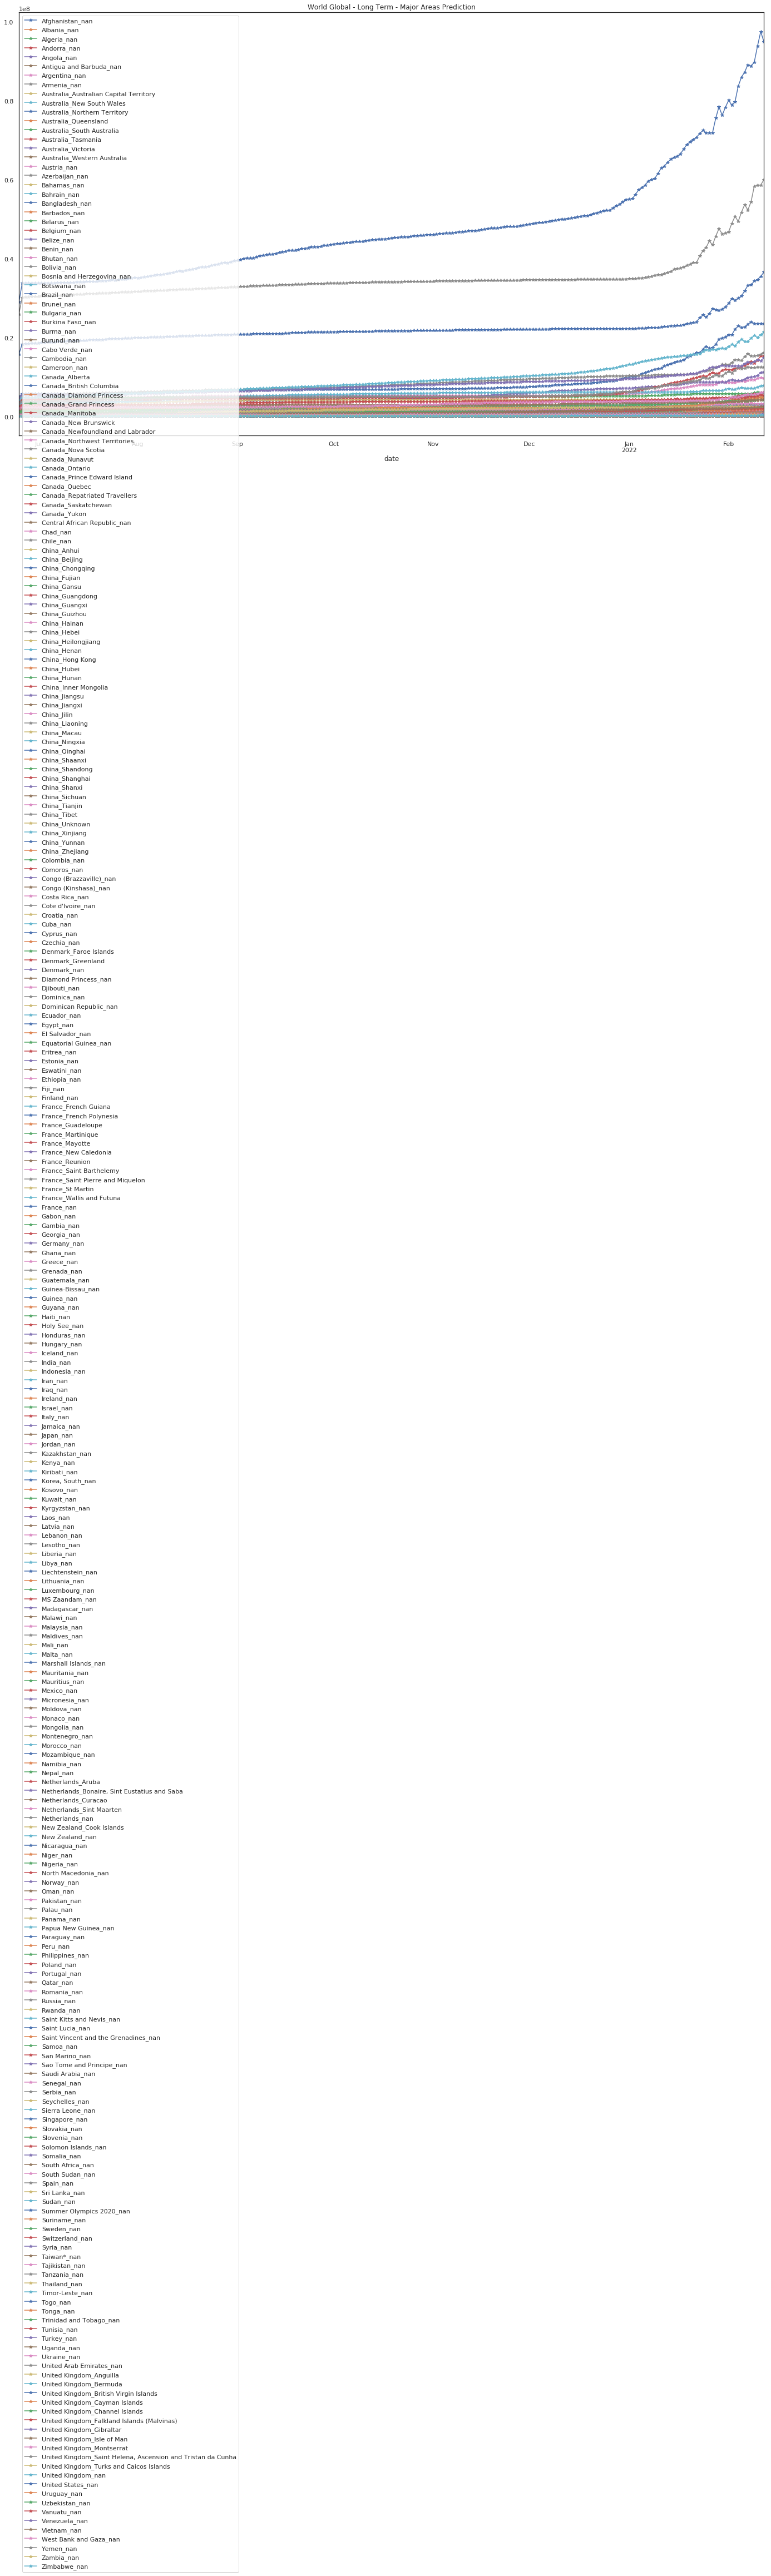

In [80]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [81]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [82]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-08-09         152469.0     135298.0     183879.0      14936.0   
2021-08-10         152689.0     135534.0     184864.0      14946.0   
2021-08-11         152979.0     135760.0     185730.0      14873.0   
2021-08-12         153242.0     136015.0     186594.0      14891.0   
2021-08-13         153459.0     136385.0     187452.0      14908.0   
2021-08-14         153649.0     136757.0     188220.0      14924.0   
2021-08-15         153759.0     137148.0     188856.0      14999.0   
2021-08-16         153883.0     137382.0     189565.0      15020.0   
2021-08-17         153980.0     137862.0     190252.0      14954.0   
2021-08-18         154098.0     138253.0     190971.0      15000.0   
2021-08-19         154152.0     138762.0     191667.0      14976.0   
2021-08-20         154206.0     139284.0     192265.0      15013.0   
2021-08-21         154255.0     139921.0     192799.0      14997.0   
2021-08-22         154270.0     140436.0     193231.0      15044.0   
2021-08-23         154342.0     140892.0     193732.0      15055.0   
2021-08-24         154404.0     141677.0     194258.0      15002.0   
2021-08-25         154467.0     142393.0     194800.0      15056.0   
2021-08-26         154565.0     143266.0     195308.0      15014.0   
2021-08-27         154689.0     144174.0     195822.0      15056.0   
2021-08-28         154741.0     145076.0     196311.0      15025.0   
2021-08-29         154791.0     145870.0     196803.0      15071.0   
2021-08-30         154898.0     146437.0     197226.0      15076.0   
2021-08-31         154955.0     147486.0     197724.0      15032.0   
2021-09-01         155010.0     148323.0     198174.0      15079.0   
2021-09-02         155062.0     149216.0     198574.0      15046.0   
2021-09-03         155126.0     150141.0     198970.0      15055.0   
2021-09-04         155148.0     151100.0     199327.0      15076.0   
2021-09-05         155186.0     151986.0     199676.0      15095.0   
2021-09-06         155283.0     152568.0     199991.0      15106.0   
2021-09-07         155359.0     153368.0     200322.0      15069.0   
...                     ...          ...          ...          ...   
2022-01-14         160382.0     229476.0     226612.0      28899.0   
2022-01-15         160432.0     231642.0     227131.0      29888.0   
2022-01-16         160471.0     233401.0     227693.0      29888.0   
2022-01-17         160569.0     234509.0     228369.0      29888.0   
2022-01-18         160698.0     237063.0     229163.0      29888.0   
2022-01-19         160794.0     239784.0     230444.0      29888.0   
2022-01-20         161018.0     242193.0     231975.0      30188.0   
2022-01-21         161207.0     244804.0     233787.0      32201.0   
2022-01-22         161270.0     247110.0     235950.0      33025.0   
2022-01-23         161310.0     247409.0     236276.0      33025.0   
2022-01-24         162560.0     257817.0     239877.0      33631.0   
2022-01-25         163820.0     267444.0     240632.0      34889.0   
2022-01-26         169510.0     274629.0     242102.0      34889.0   
2022-01-27         169576.0     275553.0     242452.0      34889.0   
2022-01-28         170749.0     274903.0     246282.0      36532.0   
2022-01-29         170744.0     293584.0     247132.0      36820.0   
2022-01-30         170735.0     298865.0     248569.0      36820.0   
2022-01-31         177351.0     299950.0     260822.0      36869.0   
2022-02-01         180217.0     302029.0     269022.0      39263.0   
2022-02-02         181492.0     301932.0     269561.0      39263.0   
2022-02-03         181900.0     301801.0     268989.0      39970.0   
2022-02-04         186357.0     301838.0     269074.0      39970.0   
2022-02-05         192346.0     315248.0     278524.0      39970.0   
2022-02-06         193273.0     319681.0     288116.0      39970.0   
2022-02-07

In [83]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [84]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [85]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [86]:
heatmap_m[:]

region        Lat        Long  \
0                                      Afghanistan_nan  33.939110   67.709953   
1                                          Albania_nan  41.153300   20.168300   
2                                          Algeria_nan  28.033900    1.659600   
3                                          Andorra_nan  42.506300    1.521800   
4                                           Angola_nan -11.202700   17.873900   
5                              Antigua and Barbuda_nan  17.060800  -61.796400   
6                                        Argentina_nan -38.416100  -63.616700   
7                                          Armenia_nan  40.069100   45.038200   
8               Australia_Australian Capital Territory -35.473500  149.012400   
9                            Australia_New South Wales -33.868800  151.209300   
10                        Australia_Northern Territory -12.463400  130.845600   
11                                Australia_Queensland -27.469800  153.025100   
12                           Australia_South Australia -34.928500  138.600700   
13                                  Australia_Tasmania -42.882100  147.327200   
14                                  Australia_Victoria -37.813600  144.963100   
15                         Australia_Western Australia -31.950500  115.860500   
16                                         Austria_nan  47.516200   14.550100   
17                                      Azerbaijan_nan  40.143100   47.576900   
18                                         Bahamas_nan  25.025885  -78.035889   
19                                         Bahrain_nan  26.027500   50.550000   
20                                      Bangladesh_nan  23.685000   90.356300   
21                                        Barbados_nan  13.193900  -59.543200   
22                                         Belarus_nan  53.709800   27.953400   
23                                         Belgium_nan  50.833300    4.469936   
24                                          Belize_nan  17.189900  -88.497600   
25                                           Benin_nan   9.307700    2.315800   
26                                          Bhutan_nan  27.514200   90.433600   
27                                         Bolivia_nan -16.290200  -63.588700   
28                          Bosnia and Herzegovina_nan  43.915900   17.679100   
29                                        Botswana_nan -22.328500   24.684900   
..                                                 ...        ...         ...   
256                                           Togo_nan   8.619500    0.824800   
257                                          Tonga_nan -21.179000 -175.198200   
258                            Trinidad and Tobago_nan  10.691800  -61.222500   
259                                        Tunisia_nan  33.886917    9.537499   
260                                         Turkey_nan  38.963700   35.243300   
261                                  United States_nan  40.000000 -100.000000   
262                                         Uganda_nan   1.373333   32.290275   
263                                        Ukraine_nan  48.379400   31.165600   
264                           United Arab Emirates_nan  23.424076   53.847818   
265                            United Kingdom_Anguilla  18.220600  -63.068600   
266                             United Kingdom_Bermuda  32.307800  -64.750500   
267              United Kingdom_British Virgin Islands  18.420700  -64.640000   
268                      United Kingdom_Cayman Islands  19.313300  -81.254600   
269                     United Kingdom_Channel Islands  49.372300   -2.364400   
270         United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
271                           United Kingdom_Gibraltar  36.140800   -5.353600   
272                         United Kingdom_Isle of Man  54.236100   -4.548100   
273                          United Kingdom_Montserrat  16.742498  -62.187366  

In [87]:
# Fill empty lat,long with 0
heatmap_m['Lat']=heatmap_m['Lat'].fillna(0)
heatmap_m['Long']=heatmap_m['Long'].fillna(0)
#
heatmap_m_fn="heatmap_m_"+str(num_days_R_prediction)+".csv"
heatmap_m.to_csv(r'data/'+heatmap_m_fn, index = False, header=True)

In [88]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat,lng,num,totpred,lastday7DayAvg,today7DayAvg in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]], \
                                                           (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg, \
                                                           (heatmap_m[heatmap_m.columns[ndayarray]]-heatmap_m[heatmap_m.columns[n2dayarray]])/ndaysavg):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' Current7DayAVG='+str(round(today7DayAvg))+' Predicted7DayAVG='+str(round(lastday7DayAvg))+' ConfTotPred='+str(round(totpred))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [89]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                     region        Lat        Long  \
0       6              Argentina_nan -38.416100  -63.616700   
1       9  Australia_New South Wales -33.868800  151.209300   
2      16                Austria_nan  47.516200   14.550100   
3      20             Bangladesh_nan  23.685000   90.356300   
4      23                Belgium_nan  50.833300    4.469936   
5      30                 Brazil_nan -14.235000  -51.925300   
6      51             Canada_Ontario  51.253800  -85.323200   
7      59                  Chile_nan -35.675100  -71.543000   
8      94               Colombia_nan   4.570900  -74.297300   
9     100                Croatia_nan  45.100000   15.200000   
10    101                   Cuba_nan  21.521757  -77.781167   
11    103                Czechia_nan  49.817500   15.473000   
12    106                Denmark_nan  56.263900    9.501800   
13    132                 France_nan  46.227600    2.213700   
14    137                Germany_nan  51.165691   10.451526   
15    139                 Greece_nan  39.074200   21.824300   
16    149                Hungary_nan  47.162500   19.503300   
17    151                  India_nan  20.593684   78.962880   
18    152              Indonesia_nan  -0.789300  113.921300   
19    153                   Iran_nan  32.427908   53.688046   
20    154                   Iraq_nan  33.223191   43.679291   
21    155                Ireland_nan  53.142400   -7.692100   
22    156                 Israel_nan  31.046051   34.851612   
23    157                 Israel_nan  31.046051   34.851612   
24    158                  Italy_nan  41.871940   12.567380   
25    160                  Japan_nan  36.204824  138.252924   
26    161                 Jordan_nan  31.240000   36.510000   
27    162             Kazakhstan_nan  48.019600   66.923700   
28    182               Malaysia_nan   4.210484  101.975766   
29    189                 Mexico_nan  23.634500 -102.552800   
30    195                Morocco_nan  31.791700   -7.092600   
31    203            Netherlands_nan  52.132600    5.291300   
32    212               Pakistan_nan  30.375300   69.345100   
33    217                   Peru_nan  -9.190000  -75.015200   
34    218            Philippines_nan  12.879721  121.774017   
35    219                 Poland_nan  51.919400   19.145100   
36    220               Portugal_nan  39.399900   -8.224500   
37    222                Romania_nan  45.943200   24.966800   
38    223                 Russia_nan  61.524010  105.318756   
39    233                 Serbia_nan  44.016500   21.005900   
40    237               Slovakia_nan  48.669000   19.699000   
41    241           South Africa_nan -30.559500   22.937500   
42    243                  Spain_nan  40.463667   -3.749220   
43    248                 Sweden_nan  60.128161   18.643501   
44    249            Switzerland_nan  46.818200    8.227500   
45    254               Thailand_nan  15.870032  100.992541   
46    260                 Turkey_nan  38.963700   35.243300   
47    261          United States_nan  40.000000 -100.000000   
48    263                Ukraine_nan  48.379400   31.165600   
49    276         United Kingdom_nan  55.378100   -3.436000   
50    281                Vietnam_nan  14.058324  108.277199   

    2021-06-25 00:00:00  2021-06-26 00:00:00  2021-06-27 00:00:00  \
0             3858766.0            4374587.0            4404934.0   
1              118037.0             118064.0               5756.0   
2              669695.0             669846.0             650192.0   
3              865589.0             878804.0             883562.0   
4             1039978.0            1082476.0            1082476.0   
5            15809874.0           18332493.0           18439344.0   
6              585032.0             585252.0             551394.0   
7             1429556.0            1537471.0            1542642.0   
8             3617447.0            4092746.0            4163476.0   
9              420966.0             4

In [90]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat2,lng2,num2,totpred2,lastday7DayAvg2,today7DayAvg2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], \
                                                                (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg, \
                                                                (heatmap_m2[heatmap_m2.columns[ndayarray]]-heatmap_m2[heatmap_m2.columns[n2dayarray]])/ndaysavg):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' Current7DayAvg='+str(round(today7DayAvg2))+' Predicted7DayAvg='+str(round(lastday7DayAvg2))+' ConfTotPred='+str(round(totpred2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [91]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [92]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [93]:
exit()